In [2]:
# Connect Google Colab to Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/ML Project/'

Mounted at /content/drive


# 1. Introduction

In this project, we aim to uncover meaningful insights into global lifestyle patterns by analyzing a diverse dataset of world citizens. This work is part of the WHO-LIFE initiative, which seeks to understand how factors such as health, financial habits, environmental awareness, and cultural influences shape people’s everyday decisions. Our goal is to apply data science and machine learning techniques not just to explore the data, but also to surface actionable insights that reflect real-world behaviors.

We have structured our project into several key phases:

  1. **Data Exploration and Understanding**:

  In this step, we perform an in-depth EDA to understand the composition of our dataset, detect patterns, and identify anomalies. This helps inform the preprocessing strategy and guides our feature selection.

  2. **Data Preprocessing**:

  This phase includes a meticulous cleaning of both categorical and numerical features. We address inconsistencies, standardize values, impute missing data, and prepare the dataset for downstream analysis. Preprocessing is crucial in ensuring that the clustering models are trained on high-quality inputs.

  3. **Additional Insights**:

  We conduct exploratory analyses that ask deeper questions about human behavior. For example:
  
  Are eco-conscious individuals more financially conservative?

  Is well-being more correlated with exercise or with stress management?

  How do lifestyle trends vary across continents? We also integrate external data (e.g., GDP per capita, population stats) to enrich the context and deepen our analysis.

  4. **Descriptive Modeling (Clustering)**:

  Finally, we use unsupervised learning techniques (e.g., KMeans) to segment the global population into distinct lifestyle clusters. This helps us identify groups of individuals who share similar traits, from wellness levels to spending habits, allowing us to describe and compare global lifestyle profiles.

Each section of this notebook has been carefully annotated with markdown cells like this one, replacing the need for a traditional report. Our goal is to create a readable, reproducible, and well-documented workflow that clearly conveys both technical choices and insights.




# 2. Import libraries and data


We prepare the environment by importing the necessary Python libraries and loading the dataset for further exploration.



---


We start by importing a suite of libraries commonly used in data science workflows:

  * `pandas` and `numpy`: Core libraries for data handling and numerical operations.

  * `matplotlib.pyplot` and `seaborn`: Used for generating visualizations, with `seaborn`'s theme set to "Dark2" for consistent and visually appealing plots tailored for presentations (`context='talk'`).

  * `sklearn.preprocessing`: Includes scalers such as `RobustScaler` and `StandardScaler`, essential for normalizing data before clustering.

  * `KNNImputer`: Enables handling of missing values using k-nearest neighbors imputation.

  * `KMeans` and `AgglomerativeClustering`: Core algorithms for partition-based and hierarchical clustering respectively.

  * `silhouette_score`: A metric used to evaluate the quality of clustering results.

  * `tqdm`: Provides progress bars for long-running loops, improving code usability during iterative tasks.

  * `scipy.cluster.hierarchy`: Supports dendrogram creation for hierarchical clustering visualization.

Additionally, we suppress less relevant warning messages using Python’s built-in warnings module, to create a cleaner output.

In [3]:
# Import the standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

sns.set()
sns.set_theme(context='talk', palette='Dark2')

# Importing this with to handle pesky warning signs - use with care
import warnings
warnings.simplefilter("ignore")

The dataset `world_citizens.csv` is then loaded into a `pandas` DataFrame using a semicolon (`;`) as a delimiter, which is common in many European CSV formats.

We also create a working copy of the data to ensure that the original data remains untouched during processing.

In [4]:
# Load the dataset
df = pd.read_csv(path + 'Data/world_citizens.csv', sep=";")
print(f"Dataset loaded : {df.shape[0]} rows × {df.shape[1]} columns")

# Create a copy of the original dataset
data = df.copy()

Dataset loaded : 8327 rows × 22 columns


# 3. Data Exploration and Understanding

In this section, we take a first look at the data to understand its structure, types of features, and check for any null values or issues. This helps us prepare for cleaning and modeling later.

---


We begin with a general overview of the dataset to assess the number of entries, features, and their respective data types:

In [5]:
# Quick check for data types and missing values
print("\nBasic dataset information:")
df.info()


Basic dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8327 entries, 0 to 8326
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   avg_monthly_entertainment_expenses  8077 non-null   object
 1   avg_weekly_exercise_hours           8119 non-null   object
 2   citizen_id                          8327 non-null   int64 
 3   city                                8327 non-null   object
 4   country                             8327 non-null   object
 5   date_of_birth                       8327 non-null   object
 6   eco_consciousness_score             8119 non-null   object
 7   education_level                     8036 non-null   object
 8   environmental_awareness_rating      8294 non-null   object
 9   financial_wellness_index            8078 non-null   object
 10  hapiness_level                      8327 non-null   object
 11  health_consciousness_rating 

To understand the actual values in the datase, we preview the first few rows:

In [6]:
data.head()

avg_monthly_entertainment_expenses avg_weekly_exercise_hours  citizen_id  \
0                              8,873                         0           1   
1                            10,9348                    0,1298           2   
2                            29,9206                    0,1129           3   
3                            36,0014                    0,0419           4   
4                             6,0075                    1,2697           5   

     city      country date_of_birth eco_consciousness_score education_level  \
0  Palmas       Brazil    15/02/1982                       0          5,5454   
1   Taupo  New Zealand    07/11/1989                       0           4,915   
2   Nauen      Germany    13/03/1972                       0          9,4307   
3   Kusel      Germany    28/04/1982                  0,0134          8,5129   
4    Rize       Turkey    05/09/1996                       0          6,0902   

  environmental_awareness_rating financial_wellness_index  ...  \
0                         0,5576                  264,346  ...   
1                         0,5998                  209,972  ...   
2                         0,6302                  21,6053  ...   
3                         0,6066                  87,0453  ...   
4                         1,1385                  95,4032  ...   

  investment_portfolio_value investments_risk_appetite  \
0                     0,1313                    6,7866   
1                          0                    7,2836   
2                     5,1244                      4,18   
3                     6,1273                    7,1364   
4                      6,214                    4,3797   

  investments_risk_tolerance last_year_charity_donations marital_status  \
0                     22,955                           0                  
1                    17,0296                           0                  
2                     3,9274                           0                  
3                     6,0943                      0,1132                  
4                     3,1951                           0                  

      name social_media_influence_score stress_management_score title  \
0  Mafalda                       2,6469                  3,0448   Ms.   
1    Olive                       2,1466                  1,8311  Mrs.   
2   Esther                      10,2169                  3,9353   Ms.   
3    Ramon                       4,9333                     NaN   Mr.   
4    Koray                       8,2687                  2,2987   Mr.   

  well_being_level  
0           3,9098  
1           4,4571  
2           4,3552  
3           5,7737  
4           2,5274  

[5 rows x 22 columns]

Using `data.describe(include='all')`, we generate summary statistics for all columns:

In [7]:
print("\nSummary statistics:")
data.describe(include = 'all')


Summary statistics:


avg_monthly_entertainment_expenses avg_weekly_exercise_hours  \
count                                8077                      8119   
unique                               7922                      4809   
top                                9,2026                         0   
freq                                    3                      1281   
mean                                  NaN                       NaN   
std                                   NaN                       NaN   
min                                   NaN                       NaN   
25%                                   NaN                       NaN   
50%                                   NaN                       NaN   
75%                                   NaN                       NaN   
max                                   NaN                       NaN   

         citizen_id      city country date_of_birth eco_consciousness_score  \
count   8327.000000      8327    8327          8327                    8119   
unique          NaN      3733      22          5711                    1842   
top             NaN  Tauranga   Spain    18/02/1996                       0   
freq            NaN        24     446             6                    2696   
mean    4164.000000       NaN     NaN           NaN                     NaN   
std     2403.942179       NaN     NaN           NaN                     NaN   
min        1.000000       NaN     NaN           NaN                     NaN   
25%     2082.500000       NaN     NaN           NaN                     NaN   
50%     4164.000000       NaN     NaN           NaN                     NaN   
75%     6245.500000       NaN     NaN           NaN                     NaN   
max     8327.000000       NaN     NaN           NaN                     NaN   

       education_level environmental_awareness_rating  \
count             8036                           8294   
unique            7702                           5074   
top                  0                         0,6526   
freq                49                              7   
mean               NaN                            NaN   
std                NaN                            NaN   
min                NaN                            NaN   
25%                NaN                            NaN   
50%                NaN                            NaN   
75%                NaN                            NaN   
max                NaN                            NaN   

       financial_wellness_index  ... investment_portfolio_value  \
count                      8078  ...                       8202   
unique                     7671  ...                       7051   
top                       -0,05  ...                          0   
freq                        177  ...                       1019   
mean                        NaN  ...                        NaN   
std                         NaN  ...                        NaN   
min                         NaN  ...                        NaN   
25%                         NaN  ...                        NaN   
50%                         NaN  ...                        NaN   
75%                         NaN  ...                        NaN   
max                         NaN  ...                        NaN   

       investments_risk_appetite investments_risk_tolerance  \
count                       8077                       8160   
unique                      7283                       7759   
top                            0                     5,3439   
freq                         380                          4   
mean                         NaN                        NaN   
std                          NaN                        NaN   
min                          NaN                        NaN   
25%                          NaN                        NaN   
50%                          NaN                        NaN   
75%                          NaN                        NaN   
max                   

We check for missing and duplicated values:

In [8]:
# Checking for missing values
missing = data.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Missing values:
 avg_monthly_entertainment_expenses    250
avg_weekly_exercise_hours             208
eco_consciousness_score               208
education_level                       291
environmental_awareness_rating         33
financial_wellness_index              249
health_consciousness_rating           250
investment_portfolio_value            125
investments_risk_appetite             250
investments_risk_tolerance            167
last_year_charity_donations           125
stress_management_score               293
well_being_level                      125
dtype: int64


In [9]:
# Checking for duplicate values
duplicates = data.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


Before starting the analysis, we group the variables into different types  numerical, categorical, datetime, and ID features. This helps organise the preprocessing steps and choose the right methods for each type.

In [10]:
numerical_features=["last_year_charity_donations","financial_wellness_index","investment_portfolio_value","social_media_influence_score","investments_risk_appetite","investments_risk_tolerance",
                    "avg_monthly_entertainment_expenses","avg_weekly_exercise_hours","stress_management_score","eco_consciousness_score","well_being_level","environmental_awareness_rating","health_consciousness_rating","education_level"]
categorical_features=["name","title","city","country","hapiness_level","marital_status"]
datetime_features=["date_of_birth"]
id_features=["citizen_id"]


 # 4. Exploratory Data Analysis and Data Preprocessing

## Duplicate Data Cleaning

 As checked for duplicate rows but didn’t find any, then we set `citizen_id` as the index because it is a unique ID for each person. Then we will check for duplicates again.

In [11]:
data.set_index("citizen_id", inplace = True)
data.head()

avg_monthly_entertainment_expenses avg_weekly_exercise_hours  \
citizen_id                                                                
1                                       8,873                         0   
2                                     10,9348                    0,1298   
3                                     29,9206                    0,1129   
4                                     36,0014                    0,0419   
5                                      6,0075                    1,2697   

              city      country date_of_birth eco_consciousness_score  \
citizen_id                                                              
1           Palmas       Brazil    15/02/1982                       0   
2            Taupo  New Zealand    07/11/1989                       0   
3            Nauen      Germany    13/03/1972                       0   
4            Kusel      Germany    28/04/1982                  0,0134   
5             Rize       Turkey    05/09/1996                       0   

           education_level environmental_awareness_rating  \
citizen_id                                                  
1                   5,5454                         0,5576   
2                    4,915                         0,5998   
3                   9,4307                         0,6302   
4                   8,5129                         0,6066   
5                   6,0902                         1,1385   

           financial_wellness_index hapiness_level  ...  \
citizen_id                                          ...   
1                           264,346         medium  ...   
2                           209,972         medium  ...   
3                           21,6053         medium  ...   
4                           87,0453         medium  ...   
5                           95,4032         medium  ...   

           investment_portfolio_value investments_risk_appetite  \
citizen_id                                                        
1                              0,1313                    6,7866   
2                                   0                    7,2836   
3                              5,1244                      4,18   
4                              6,1273                    7,1364   
5                               6,214                    4,3797   

           investments_risk_tolerance last_year_charity_donations  \
citizen_id                                                          
1                              22,955                           0   
2                             17,0296                           0   
3                              3,9274                           0   
4                              6,0943                      0,1132   
5                              3,1951                           0   

           marital_status     name social_media_influence_score  \
citizen_id                                                        
1                          Mafalda                       2,6469   
2                            Olive                       2,1466   
3                           Esther                      10,2169   
4                            Ramon                       4,9333   
5                            Koray                       8,2687   

           stress_management_score title well_being_level  
citizen_id                                                 
1                           3,0448   Ms.           3,9098  
2                           1,8311  Mrs.           4,4571  
3                           3,9353   Ms.           4,3552  
4                              NaN   Mr.           5,7737  
5                           2,2987   Mr.           2,5274  

[5 rows x 21 columns]

In [12]:
data.duplicated().sum()

np.int64(5)

We still identified 5 duplicated rows (10 total entries including both original and duplicate records), so we inspected the duplicates in detail:

In [13]:
#locate the duplicate rows with .loc, showing both of the duplicates (the original and the duplicated for each case)
data.loc[data.duplicated(keep=False), :]

avg_monthly_entertainment_expenses avg_weekly_exercise_hours  \
citizen_id                                                                
429                                   11,5322                    0,0889   
438                                   11,5322                    0,0889   
540                                   47,2653                    3,4504   
549                                   47,2653                    3,4504   
641                                    4,9573                    0,0214   
660                                    4,9573                    0,0214   
752                                    5,9118                    0,0715   
761                                    5,9118                    0,0715   
863                                    7,8511                     0,051   
872                                    7,8511                     0,051   

                       city        country date_of_birth  \
citizen_id                                                 
429                   Tweed      Australia    05/07/1982   
438                   Tweed      Australia    05/07/1982   
540              Versailles         France    26/01/1981   
549              Versailles         France    26/01/1981   
641                 Kronoby        Finland    13/02/1966   
660                 Kronoby        Finland    13/02/1966   
752              Manchester  United States    26/04/2000   
761              Manchester  United States    26/04/2000   
863         Chichimequillas         Mexico    25/05/1985   
872         Chichimequillas         Mexico    25/05/1985   

           eco_consciousness_score education_level  \
citizen_id                                           
429                         0,0066          8,1441   
438                         0,0066          8,1441   
540                              0           3,054   
549                              0           3,054   
641                         0,0035          2,6357   
660                         0,0035          2,6357   
752                              0          4,2444   
761                              0          4,2444   
863                          0,008          2,5868   
872                          0,008          2,5868   

           environmental_awareness_rating financial_wellness_index  \
citizen_id                                                           
429                                0,5706                  120,793   
438                                0,5706                  120,793   
540                                3,0163                  95,9212   
549                                3,0163                  95,9212   
641                                0,4742                   167,01   
660                                0,4742                   167,01   
752                                0,5477                  141,108   
761                                0,5477                  141,108   
863                                0,6178                  156,527   
872                                0,6178                  156,527   

           hapiness_level  ... investment_portfolio_value  \
citizen_id                 ...                              
429                medium  ...                     7,6876   
438                medium  ...                     7,6876   
540                medium  ...                      8,114   
549                medium  ...                      8,114   
641                medium  ...                          0   
660                medium  ...                          0   
752                medium  ...                     1,4241   
761                medium  ...                     1,4241   
863                medium  ...                          0   
872                medium  ...                          0   

           investments_risk_appetite investments_risk_tolerance  \
citizen_id                                                        
429                           0,

We remove the duplicates by dropping them:

In [14]:
# Removing the duplicates
data.drop_duplicates(inplace=True)
data.duplicated().sum()

np.int64(0)

Finally, we restored the original structure of the DataFrame to include `citizen_id` as a column again:

In [15]:
data = data.reset_index(drop = False)
data.head()

citizen_id avg_monthly_entertainment_expenses avg_weekly_exercise_hours  \
0           1                              8,873                         0   
1           2                            10,9348                    0,1298   
2           3                            29,9206                    0,1129   
3           4                            36,0014                    0,0419   
4           5                             6,0075                    1,2697   

     city      country date_of_birth eco_consciousness_score education_level  \
0  Palmas       Brazil    15/02/1982                       0          5,5454   
1   Taupo  New Zealand    07/11/1989                       0           4,915   
2   Nauen      Germany    13/03/1972                       0          9,4307   
3   Kusel      Germany    28/04/1982                  0,0134          8,5129   
4    Rize       Turkey    05/09/1996                       0          6,0902   

  environmental_awareness_rating financial_wellness_index  ...  \
0                         0,5576                  264,346  ...   
1                         0,5998                  209,972  ...   
2                         0,6302                  21,6053  ...   
3                         0,6066                  87,0453  ...   
4                         1,1385                  95,4032  ...   

  investment_portfolio_value investments_risk_appetite  \
0                     0,1313                    6,7866   
1                          0                    7,2836   
2                     5,1244                      4,18   
3                     6,1273                    7,1364   
4                      6,214                    4,3797   

  investments_risk_tolerance last_year_charity_donations marital_status  \
0                     22,955                           0                  
1                    17,0296                           0                  
2                     3,9274                           0                  
3                     6,0943                      0,1132                  
4                     3,1951                           0                  

      name social_media_influence_score stress_management_score title  \
0  Mafalda                       2,6469                  3,0448   Ms.   
1    Olive                       2,1466                  1,8311  Mrs.   
2   Esther                      10,2169                  3,9353   Ms.   
3    Ramon                       4,9333                     NaN   Mr.   
4    Koray                       8,2687                  2,2987   Mr.   

  well_being_level  
0           3,9098  
1           4,4571  
2           4,3552  
3           5,7737  
4           2,5274  

[5 rows x 22 columns]

## Categorical Features Cleaning

In [16]:
data[categorical_features].describe().T

count unique       top  freq
name            8322   3576      Emma    26
title           8322      4       Mr.  4032
city            8322   3733  Tauranga    24
country         8322     22     Spain   446
hapiness_level  8322      1    medium  8322
marital_status  8322      1            8322

### Country

In [17]:
# Count how many entries belong to each country
data['country'].value_counts()

country
Spain             446
Netherlands       423
France            415
United Kingdom    410
Turkey            410
Brazil            410
United States     405
Mexico            405
New Zealand       397
Finland           395
Ukraine           391
Germany           387
Canada            384
Australia         381
Switzerland       380
Norway            379
Denmark           377
Iran              373
Ireland           372
India             371
Serbia            368
                   43
Name: count, dtype: int64

We wanted to check if the rows with blank countries had a city, so we could assign the country to where that city is from.

In [18]:
# Find rows where the 'country' column is blank or contains only spaces
data[data['country'] == '  ']

citizen_id avg_monthly_entertainment_expenses avg_weekly_exercise_hours  \
295          296                             9,9203                     0,036   
403          404                             40,549                     0,035   
465          467                             9,9865                    3,8026   
756          760                             5,8265                    0,0619   
865          870                             7,8674                    0,0713   
991          997                            44,8958                    0,1385   
995         1001                            20,0264                         0   
1250        1256                             7,9081                    2,7561   
1404        1410                            40,5889                    0,0384   
1506        1512                              33,69                    0,0228   
1643        1649                            23,6271                     0,286   
1873        1879                            43,1303                    1,5229   
1904        1910                            33,2475                    0,4276   
1945        1951                            46,7523                    0,3476   
2025        2031                             7,7549                    4,2805   
2654        2660                             9,9627                    0,1517   
2710        2716                             29,238                         0   
2775        2781                            19,3612                    0,1881   
3432        3438                             8,3605                   -1,2984   
3625        3631                            15,6837                    0,6464   
3752        3758                                NaN                         0   
3808        3814                            42,3336                    0,0821   
3940        3946                            37,5799                    0,0027   
4299        4305                              42,11                    0,0316   
4331        4337                            17,3951                    0,2114   
4436        4442                             8,1471                    4,3612   
5088        5094                            26,2735                    4,2491   
5180        5186                                NaN                    0,0132   
5306        5312                            11,4926                    0,2535   
5693        5699                            38,3568                    0,0793   
5762        5768                            10,3194                    0,0014   
6391        6397                              6,285                    0,0123   
6522        6528                            16,4579                      3,62   
6604        6610                            42,2063                   -2,2383   
6606        6612                            35,1085                    0,0437   
6613        6619                             8,9042                    0,0701   
6946        6952                             8,5163                    3,4846   
7275        7281                            37,3468                     1,435   
7312        7318                            21,2572                    0,3944   
7764        7770                             8,7502                     1,948   
7822        7828                             5,5413                    1,4364   
7889        7895                             7,5439                    3,4733   
7955        7961                             35,743                    3,2021   

                             city country date_of_birth  \
295                     Uetendorf            29/06/1994   
403                      Bayreuth            01/09/2000   
465                    MaracanaÃº            07/12/2024   
756                      Zavodske            11/06/2005   
865                             ?            11/02/1993   
991                       Hierden            16/12/1996   
995        Korsun-Shevchenki

We then check all cities with a blank country to see if the same city appears elsewhere with a valid country, so we can use that value to fill in the missing one

In [19]:
#Create a city-to-country mapping from valid data
city_country_map = data[data['country'].str.strip() != ''].groupby('city')['country'].agg(lambda x: x.mode()[0]).to_dict()

#Loop through rows where country is blank
for idx in data[data['country'] == '  '].index:
    city = data.at[idx, 'city']
    if city in city_country_map:
        data.at[idx, 'country'] = city_country_map[city]

#check if any blank values remain
print("Blank country entries after filling:", (data['country'] == '  ').sum())

Blank country entries after filling: 19


In [20]:
data[data['country'] == '  ']

citizen_id avg_monthly_entertainment_expenses avg_weekly_exercise_hours  \
295          296                             9,9203                     0,036   
403          404                             40,549                     0,035   
756          760                             5,8265                    0,0619   
991          997                            44,8958                    0,1385   
1506        1512                              33,69                    0,0228   
1873        1879                            43,1303                    1,5229   
3625        3631                            15,6837                    0,6464   
3808        3814                            42,3336                    0,0821   
4299        4305                              42,11                    0,0316   
5088        5094                            26,2735                    4,2491   
5180        5186                                NaN                    0,0132   
6391        6397                              6,285                    0,0123   
6522        6528                            16,4579                      3,62   
6606        6612                            35,1085                    0,0437   
6613        6619                             8,9042                    0,0701   
6946        6952                             8,5163                    3,4846   
7312        7318                            21,2572                    0,3944   
7764        7770                             8,7502                     1,948   
7822        7828                             5,5413                    1,4364   

                             city country date_of_birth  \
295                     Uetendorf            29/06/1994   
403                      Bayreuth            01/09/2000   
756                      Zavodske            11/06/2005   
991                       Hierden            16/12/1996   
1506                      Bryggja            29/03/1998   
1873                     Eptingen            03/01/1960   
3625                       Termen            11/12/1994   
3808                     Guntakal            02/03/1994   
4299                       Kiliya            31/12/1991   
5088         Marcelino RodrÃ­guez            20/02/2003   
5180                        Horst            20/05/1976   
6391                   Bonstetten            18/02/1988   
6522                     FoldrÃ¸y            19/11/1999   
6606                      Biezwil            01/01/1976   
6613                    ItaboraÃ­            24/05/1982   
6946  Villa Cacalilao (Cacalilao)            16/11/1975   
7312                 EnnetbÃ¼rgen            24/03/2000   
7764                    Mar'yinka            30/01/1980   
7822                     Chittoor            06/05/2000   

     eco_consciousness_score education_level environmental_awareness_rating  \
295                   0,0272          10,016                         0,5993   
403                   0,0119          3,4263                         0,7543   
756                   0,0185          1,3089                         5,2151   
991                   0,0338         12,9441                         1,7812   
1506                 -1,1811          5,8955                         0,6642   
1873                  0,0016          8,2628                         0,7112   
3625                  0,0052          6,2221                         0,6474   
3808                  0,0205           7,005                         0,8365   
4299                  0,0121           7,642                         0,6068   
5088                       0          9,3243                         0,7112   
5180                       0         10,4694                         0,9097   
6391                  0,0041          2,6333                         0,6076   
6522                  0,0031           9,118                         0,6139   
6606                  0,0216          6,3203                         0,5765   
6613               

Since only the cities without a valid country remain, we will now assign them to their respective countries.

In [21]:
# Dictionary with original city names as they appear in your data
city_to_country = {
    'Uetendorf': 'Switzerland',
    'Bayreuth': 'Germany',
    'Zavodske': 'Ukraine',
    'Hierden': 'Netherlands',
    'Bryggja': 'Norway',
    'Eptingen': 'Switzerland',
    'Termen': 'Switzerland',
    'Guntakal': 'India',
    'Kiliya': 'Ukraine',
    'Marcelino RodrÃ\xadguez': 'Mexico',
    'Horst': 'Netherlands',
    'Bonstetten': 'Switzerland',
    'FoldrÃ¸y': 'Norway',
    'Biezwil': 'Switzerland',
    'ItaboraÃ\xad': 'Brazil',
    'Villa Cacalilao (Cacalilao)': 'Mexico',
    'EnnetbÃ¼rgen': 'Switzerland',
    "Mar'yinka": 'Ukraine',
    'Chittoor': 'India'
}

In [22]:
# Update only matching rows in the 'country' column using exact keys
data['country'] = data['city'].map(city_to_country).fillna(data['country'])

# Check if any blank values remain
print("Blank country entries after filling:", (data['country'] == '  ').sum())

Blank country entries after filling: 0


### Continent

We will then assign each country to it's respective continent for reginal analysis.

In [23]:
country_to_continent_map = {
    'Spain': 'Europe',
    'Netherlands': 'Europe',
    'France': 'Europe',
    'United Kingdom': 'Europe',
    'Turkey': 'Asia',
    'Brazil': 'South America',
    'United States': 'North America',
    'Mexico': 'North America',
    'New Zealand': 'Oceania',
    'Finland': 'Europe',
    'Ukraine': 'Europe',
    'Germany': 'Europe',
    'Canada': 'North America',
    'Australia': 'Oceania',
    'Switzerland': 'Europe',
    'Norway': 'Europe',
    'Denmark': 'Europe',
    'Iran': 'Asia',
    'Ireland': 'Europe',
    'India': 'Asia',
    'Serbia': 'Europe'
}

In [24]:
data['continent'] = data['country'].map(country_to_continent_map).fillna('Unknown')

### Title and Marital Status


We will strategically use 'title' and 'marital_status' to get 'gender', as gender provides clearer insights for analysis.


In [25]:
# Check all unqiue values for title
data["title"].unique()

array(['Ms.', 'Mrs.', 'Mr.', 'Mx.'], dtype=object)

We will now get marital status from the unique titles and fill the cloumn appropiately.

In [26]:
# Set entire marital_status column to null
data['marital_status'] = np.nan

In [27]:
# Fill marital_status for Ms. and Mrs.
data.loc[data['title'] == 'Ms.', 'marital_status'] = 'Single'
data.loc[data['title'] == 'Mrs.', 'marital_status'] = 'Married'

# Calculate the proportion of married individuals among Ms. and Mrs.
marriage_proportion = data['marital_status'].value_counts(normalize=True)['Married']
print(f"Proportion of married individuals: {marriage_proportion:.2f}")


Proportion of married individuals: 0.50


In [28]:
# Filter rows where marital_status is still missing
mask = data['marital_status'].isna() & data['title'].isin(['Mr.', 'Mx.'])

# Randomly assign marital status based on observed proportion
data.loc[mask, 'marital_status'] = np.random.choice(['Married', 'Single'],
                                                     size=mask.sum(),
                                                     p=[marriage_proportion, 1 - marriage_proportion])

Marital Status Counts:

marital_status
Married    4211
Single     4111
Name: count, dtype: int64


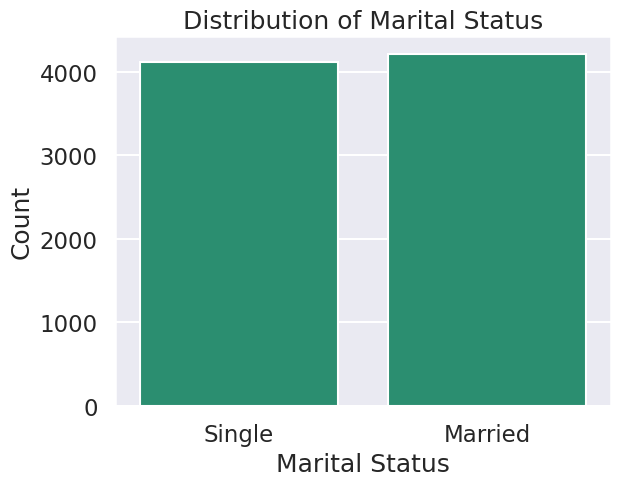

In [29]:
# Show marital status value counts and visualize them
print("Marital Status Counts:\n")
print(data["marital_status"].value_counts())

sns.countplot(data=data, x='marital_status')
plt.title("Distribution of Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.show()

Now we will convert title to gender attributes. For example, 'Mr' becomes 'M', 'Ms'/'Mrs' become 'F' and 'Mx' become 'Neutral'.

In [30]:
data["title"] = data["title"].replace({"Mr.":"M","Ms.":"F","Mrs.":"F","Mx.":"Neutral"})
data.rename(columns={"title":"gender"}, inplace=True) #Rename the column
data["gender"].unique() #To verify it's features

array(['F', 'M', 'Neutral'], dtype=object)

Gender Counts:

gender
F          4090
M          4032
Neutral     200
Name: count, dtype: int64


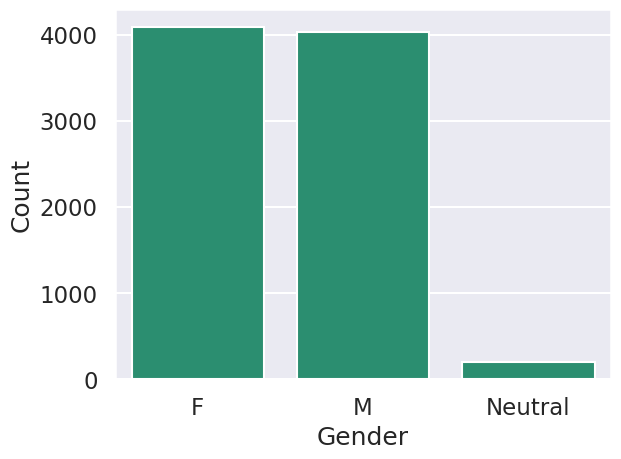

In [31]:
# Show gender value counts and visualize them
print("Gender Counts:\n")
print(data["gender"].value_counts())

sns.countplot(data=data, x='gender')
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [32]:
# Remove title from categorical feature and add gender
categorical_features.remove("title")
categorical_features.append("gender")

### Date Of Birth

Similar to title and marital column we convert date of birth to age for better usability in analysis and modeling

In [33]:
# Convert the DOB column to age and drop the date_of_birth column (assuming 01/01/2025)
data["date_of_birth"] = pd.to_datetime(data["date_of_birth"]) # First convert the data type from object to datetime
data["age"] = 2025 - data["date_of_birth"].dt.year

In [34]:
# Drop DOB column
data.drop(columns=["date_of_birth"], inplace=True)

In [35]:
data["age"].describe()

count    8322.000000
mean       36.928383
std        13.183868
min         1.000000
25%        28.000000
50%        35.000000
75%        44.000000
max       115.000000
Name: age, dtype: float64

We will now remove ages below 18 and above 100 to focus on realistic adult participants, as the data involves financial behavior, wellness, and lifestyle metrics that are not relevant for children or extremely old age outliers.

In [36]:
data = data[(data["age"] >= 18) & (data["age"] <= 100)]

### City, Happiness Level & Name

So after careful examining we decided we will not be using the `name`, `city`, and `hapiness_level` columns for further analysis. These columns either contain high-cardinality values or lack meaningful patterns for modeling, so we've decided to drop them.

Name will have no use for us, city already served its purpose for mapping the countries and hapiness level only had one value which would not be usefull.

In [37]:
# Count the values for hapiness level
data["hapiness_level"].value_counts()

hapiness_level
medium    8172
Name: count, dtype: int64

In [38]:
data.drop(columns=['city', 'hapiness_level', 'name'], inplace=True)


# Remove from categorical list
for col in ['name', 'hapiness_level', 'city']:
    if col in categorical_features:
        categorical_features.remove(col)

### Education Level and Financial Wellness Index

These two columns, `education_level` and `financial_wellness_index` are originally numerical variables but we wanted to create a categorical versions to use later in our clustering and analysis.



---


Firstly, we are converting European-style decimal notation to Python-compatible float format using string replacement:

In [39]:
for col in ['education_level', 'financial_wellness_index']:
    data[col] = (
        data[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

In [40]:
data[['education_level', 'financial_wellness_index']].describe()

education_level  financial_wellness_index
count      7886.000000               7925.000000
mean          6.289263                106.286572
std           2.919618                 64.391084
min           0.000000                 -0.050000
25%           4.040275                 87.045300
50%           6.352250                 99.797400
75%           8.565475                113.805000
max          14.244000                458.451000

Now we will handle missing values of both `education_level` and `financial_wellness_index` seperately in the best possible ways.

**Education Level**

First by using group-wise medians based on age, assuming educational level correlates with age.

Any remaining nulls are imputed using the global median.

In [41]:
# Fill nulls with grouped medians
data['education_level'] = data['education_level'].fillna(
    data.groupby('age')['education_level'].transform('median')
)

# Fallback to global median for remaining NaNs
global_median = data['education_level'].median()
data['education_level'] = data['education_level'].fillna(global_median)

To enhance interpretability, we map the education levels into meaningful categories:

In [42]:
# Define the categorization function
def categorize_education(level):
    if level <= 1:
        return "No formal education"
    elif level <= 4:
        return "Primary School"
    elif level <= 8:
        return "Middle School"
    elif level <= 10:
        return "High School"
    elif level <= 12:
        return "Bachelor's"
    elif level <= 15:
        return "Master's or Higher"
    else:
        return np.nan

# Apply function and store in a new column
data['education_category'] = data['education_level'].apply(categorize_education)

# Define the correct order for categories
education_order = [
    "No formal education",
    "Primary School",
    "Middle School",
    "High School",
    "Bachelor's",
    "Master's or Higher"
]

# Convert new column to ordered categorical type
data['education_category'] = pd.Categorical(data['education_category'], categories=education_order, ordered=True)

**Financial Wellness Index**

We convert the values from string to float, and clip all the negative values to zero.

We also fill the missing values via random sampling from the existing distribution to retain realistic variance.

In [43]:
# Replace any negative values in financial_wellness_index with 0
data['financial_wellness_index'] = data['financial_wellness_index'].clip(lower=0)

# Fill missing values with random samples to preserve the distribution and avoid unusal spikes.
def random_sample_impute(series):
    missing = series.isnull()
    n_missing = missing.sum()

    sampled = series.dropna().sample(n=n_missing, replace=True, random_state=42)
    sampled.index = series[missing].index

    return series.fillna(sampled)

data['financial_wellness_index'] = random_sample_impute(data['financial_wellness_index'])

We group financial scores into three simplified tiers:

In [44]:
# Convert financial wellness index into categorical levels: Low, Medium, and High for better interpretation
def convert_to_financial_wellness_level(x):
    if x <= 70:
        return 'Low'
    elif x <= 130:
        return 'Medium'
    else:
        return 'High'

data['financial_wellness_category'] = data['financial_wellness_index'].apply(convert_to_financial_wellness_level)

In [45]:
# Verify category assignments for education and financial wellness
data[['education_level', 'education_category',
      'financial_wellness_index', 'financial_wellness_category',
      'age']].head(10)

education_level education_category  financial_wellness_index  \
0           5.5454      Middle School                  264.3460   
1           4.9150      Middle School                  209.9720   
2           9.4307        High School                   21.6053   
3           8.5129        High School                   87.0453   
4           6.0902      Middle School                   95.4032   
5           7.6603      Middle School                  122.1580   
6          10.9448         Bachelor's                   85.0948   
7           3.4500     Primary School                  130.6530   
8           6.4521      Middle School                   67.5734   
9           7.2794      Middle School                   22.3799   

  financial_wellness_category  age  
0                        High   43  
1                        High   36  
2                         Low   53  
3                      Medium   43  
4                      Medium   29  
5                      Medium   27  
6                      Medium   44  
7                        High   30  
8                         Low   31  
9                         Low   25

The following visualizations are created to support data quality checks and analysis:

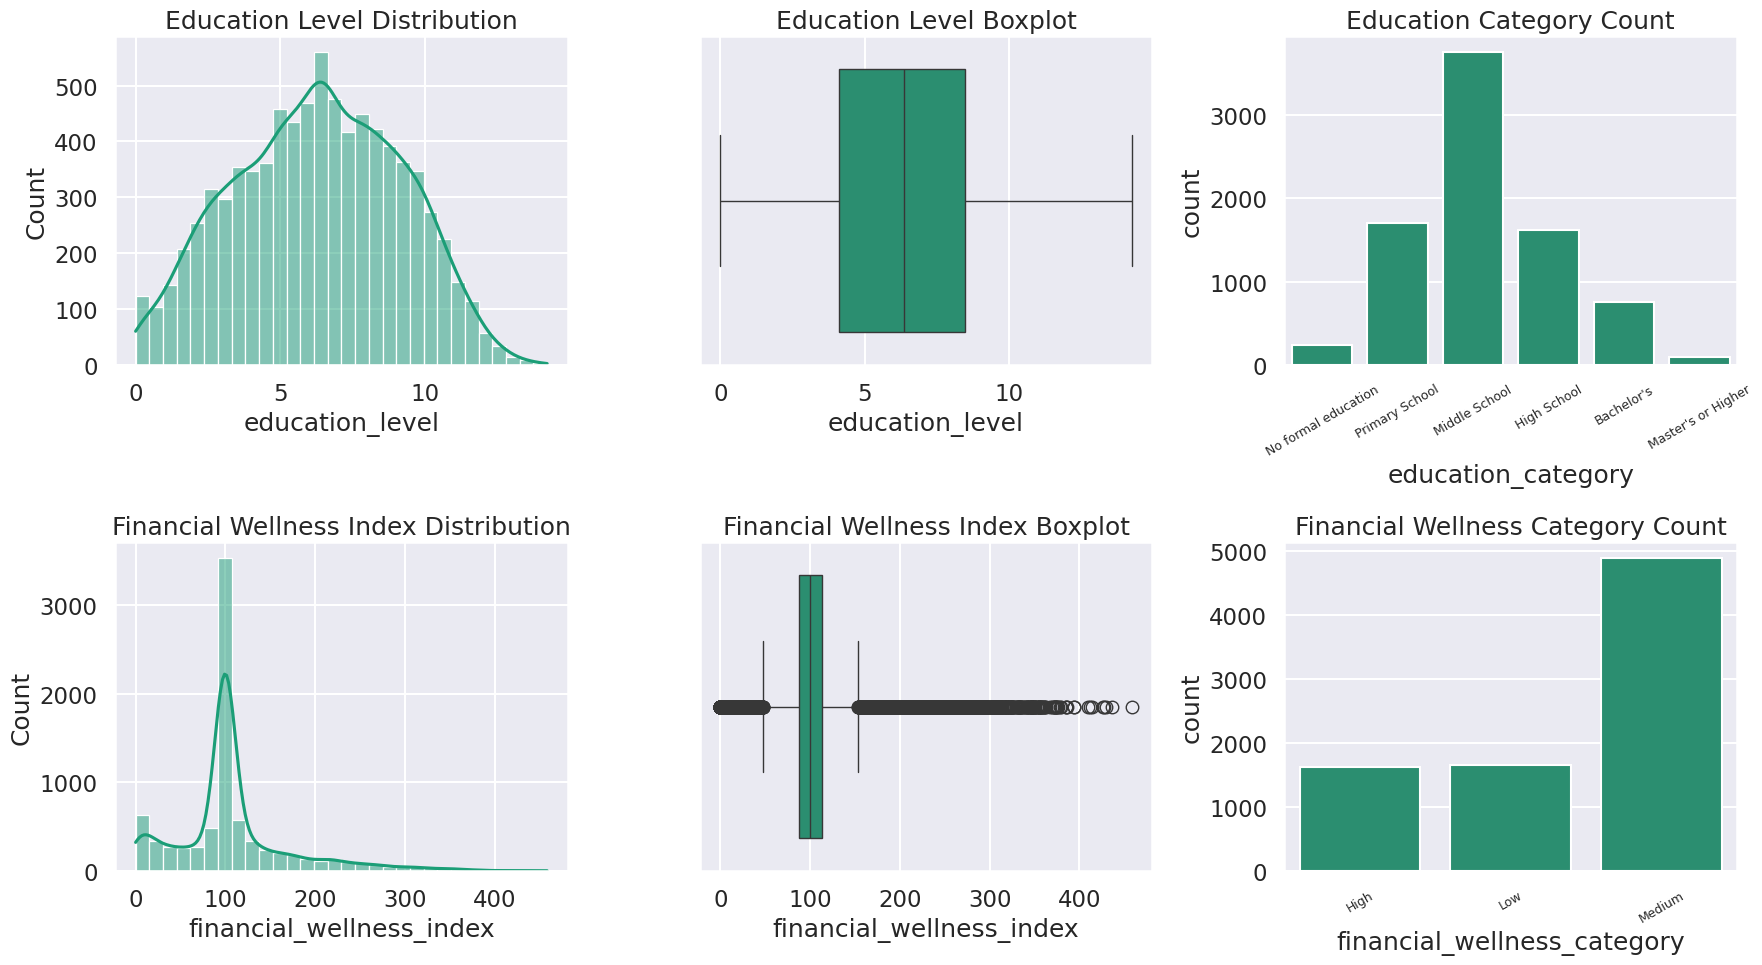

In [46]:
# Plot distribution, boxplot, and category count for both education and financial wellness.
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

sns.histplot(data['education_level'], bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Education Level Distribution')

sns.boxplot(x=data['education_level'], ax=axs[0, 1])
axs[0, 1].set_title('Education Level Boxplot')

sns.countplot(data=data, x='education_category', ax=axs[0, 2])
axs[0, 2].set_title('Education Category Count')
axs[0, 2].tick_params(axis='x', rotation=30, labelsize=9)

sns.histplot(data['financial_wellness_index'], bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Financial Wellness Index Distribution')

sns.boxplot(x=data['financial_wellness_index'], ax=axs[1, 1])
axs[1, 1].set_title('Financial Wellness Index Boxplot')

sns.countplot(data=data, x='financial_wellness_category', ax=axs[1, 2])
axs[1, 2].set_title('Financial Wellness Category Count')
axs[1, 2].tick_params(axis='x', rotation=30, labelsize=9)

plt.tight_layout()
plt.show()

**Education Level**

  * **Distribution** plot confirms a right-skewed bell shape centered around middle school to high school levels.

  * **Boxplot** shows central tendency and spread.

  * **Category Count** plot shows that most individuals fall in the “Middle School” and “Primary School” groups.

**Financial Wellness Index**

  * **Distribution** shows a right-skew with a spike around common index values, supporting the decision to categorize.

  * **Boxplot** reveals heavy-tailed outliers, another reason for categorization.

  * **Category Count** shows that the majority fall into the Medium financial wellness bracket, with smaller groups in High and Low tiers.

## Numerical Features Cleaning

In this section we will go column by column taking care of nulls, outliers, skewness and other things that might need to be worked on , along with exploratory data analysis. Also, keep in mind that whenever we use a function to scale the data we create a new column with "scaled" so we can later use it for modelling. Our goal is to normalize the data and minimize the outliers, which we will check with histplots and boxplots for each column.

In [47]:
# Create a for loop to convert every numerical feature to float
for feature in numerical_features:
    data[feature] = (
        data[feature]
        .astype(str)  # Ensure it's a string first
        .str.replace(',', '.')  # Replace commas with dots
        .astype(float)
        )

In [48]:
#pair grid for numerical features (aprox. 10 minutes to run!)
#g= sns.PairGrid(data[numerical_features])
#g.map_upper(sns.histplot)
#g.map_lower(sns.kdeplot)
#g.map_diag(sns.histplot, kde=True)
#plt.show()

Using the pairgrid we can just get an overall overview of our data. Just from this plot we can see we have a lot of right skewness and can start to think how we are going to deal with it

In [49]:
data[numerical_features].describe().T

count        mean        std     min  \
last_year_charity_donations         8048.0    0.381591   0.765184  0.0000   
financial_wellness_index            8172.0  106.234129  64.189972  0.0000   
investment_portfolio_value          8050.0   12.420477  21.231746  0.0000   
social_media_influence_score        8172.0    6.099268   4.325992  0.0000   
investments_risk_appetite           7925.0    4.377007   2.646153  0.0000   
investments_risk_tolerance          8012.0    7.308825   3.679396  1.3937   
avg_monthly_entertainment_expenses  7927.0   21.596337  17.430907  0.0000   
avg_weekly_exercise_hours           7965.0    0.705633   1.182336 -5.5794   
stress_management_score             7887.0    3.318718   1.114644  0.3192   
eco_consciousness_score             7966.0    0.131752   0.358680 -1.4167   
well_being_level                    8050.0    4.764525   1.934727  1.1376   
environmental_awareness_rating      8140.0    0.827895   0.651972  0.0376   
health_consciousness_rating         7933.0    1.451597   1.395930  0.0000   
education_level                     8172.0    6.291799   2.868611  0.0000   

                                          25%       50%         75%       max  
last_year_charity_donations          0.000000   0.01040    0.310425    5.5991  
financial_wellness_index            87.132400  99.81570  113.754750  458.4510  
investment_portfolio_value           3.294850   8.60450   13.264575  294.9500  
social_media_influence_score         3.166325   4.40060    8.204975   42.1768  
investments_risk_appetite            1.853800   4.81390    6.874600    8.6995  
investments_risk_tolerance           4.796950   6.22060    8.543125   29.5132  
avg_monthly_entertainment_expenses   8.128350  11.98960   38.777350  135.4200  
avg_weekly_exercise_hours            0.022400   0.10950    1.023500    8.7017  
stress_management_score              2.560100   3.15010    3.979250    8.7123  
eco_consciousness_score              0.000000   0.00780    0.024475    3.2475  
well_being_level                     3.413150   4.31915    5.614075   14.1143  
environmental_awareness_rating       0.540800   0.63120    0.774850    7.4025  
health_consciousness_rating          0.685800   0.80620    1.761200   10.0530  
education_level                      4.122275   6.35960    8.474700   14.2440

We will start with understanding the relationship of numerical features with each other so we can choose how to deal with them.

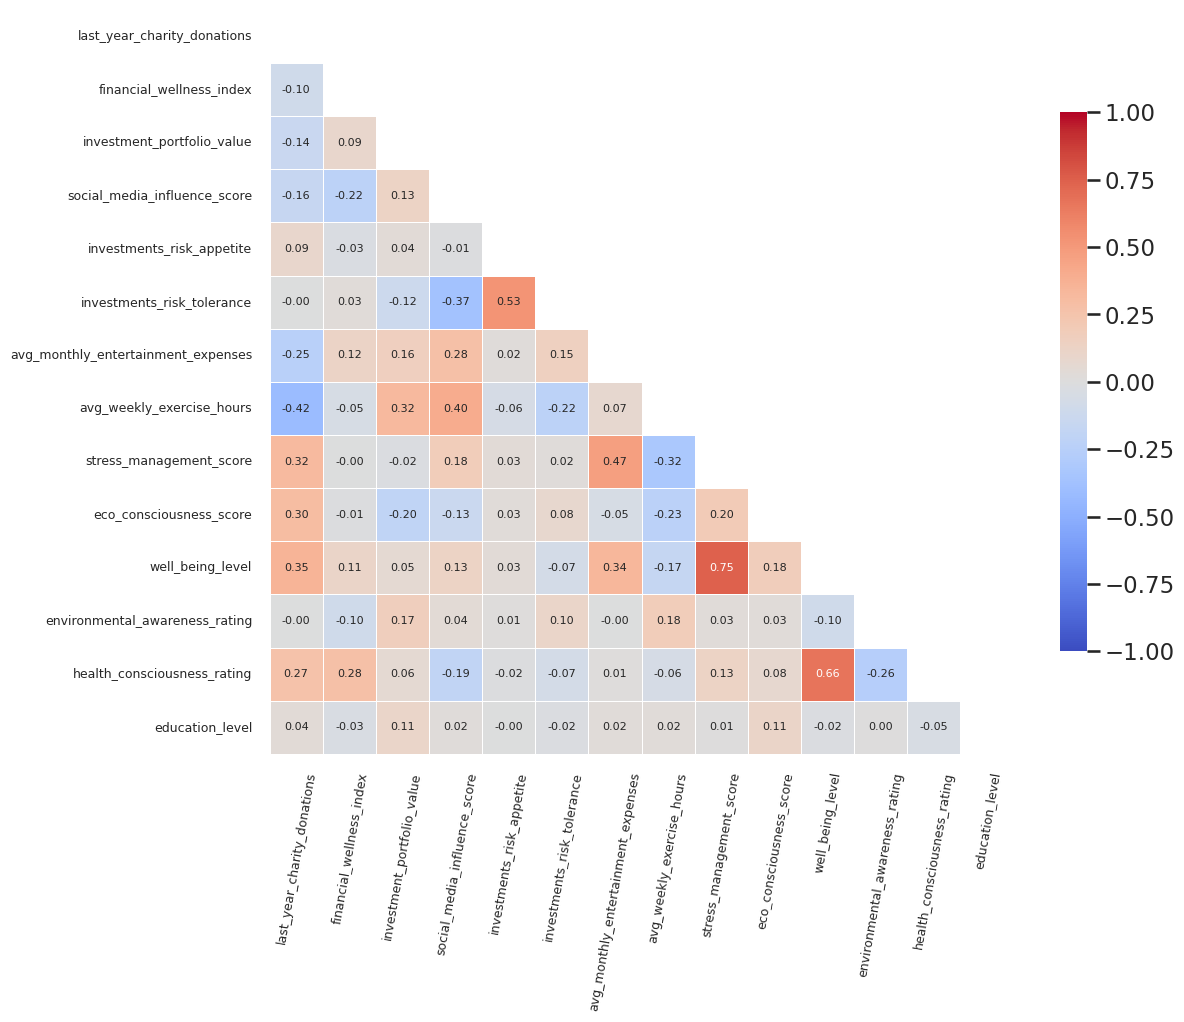

In [50]:
# Spearman correlation heatmap between numerical features
mask = np.triu(np.ones_like(data[numerical_features].corr("spearman")))
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(data[numerical_features].corr("spearman"),
        mask=mask,annot=True,fmt=".2f",cmap='coolwarm',square=True,vmin=-1,
        vmax=1,annot_kws={"size": 8},cbar_kws={"shrink": 0.7},linewidths=0.5)
    plt.xticks(rotation=80, fontsize=9)
    plt.yticks(fontsize=9)

As we saw from the heatmap there is strong correlation between `Well-being Level` vs `Stress Management Score`,`Well-being Level` vs `Health Consciousness Rating`, and `Investments Risk Appetite` vs `Risk Tolerance`. So we plot them as scatterplot to further understand any potential trends, clusters and outliers.

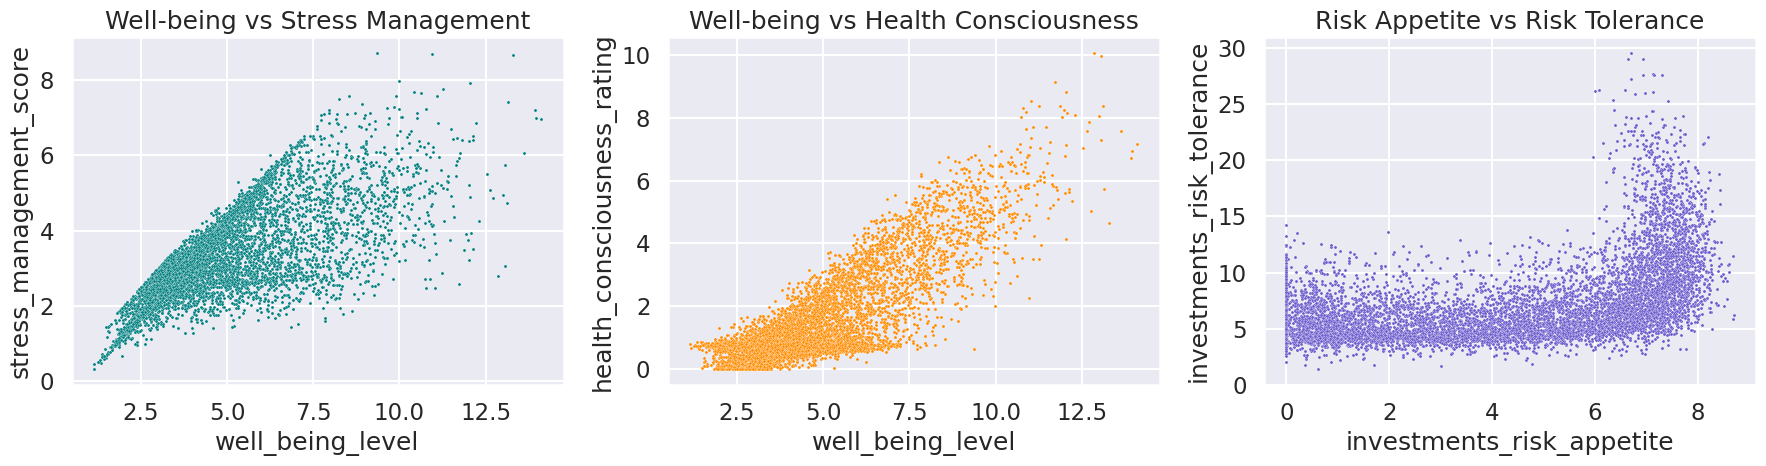

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Well-being vs. Stress Management
sns.scatterplot(data=data,x='well_being_level',y='stress_management_score',ax=axs[0],s=5,color='teal')
axs[0].set_title('Well-being vs Stress Management')

# Well-being vs Health Consciousness
sns.scatterplot(data=data,x='well_being_level',y='health_consciousness_rating',ax=axs[1],s=5,color='darkorange')
axs[1].set_title('Well-being vs Health Consciousness')

# Risk Appetite vs Risk Tolerance
sns.scatterplot(data=data,x='investments_risk_appetite',y='investments_risk_tolerance',ax=axs[2],s=5,color='slateblue')
axs[2].set_title('Risk Appetite vs Risk Tolerance')

plt.tight_layout()
plt.show()


### Environmental Awareness Rating

In [52]:
data['environmental_awareness_rating'].describe()

count    8140.000000
mean        0.827895
std         0.651972
min         0.037600
25%         0.540800
50%         0.631200
75%         0.774850
max         7.402500
Name: environmental_awareness_rating, dtype: float64

In [53]:
data['environmental_awareness_rating'].isnull().sum()

np.int64(32)

In [54]:
#Fix null values
data['environmental_awareness_rating'] = data['environmental_awareness_rating'].fillna(
    data['environmental_awareness_rating'].median()
)

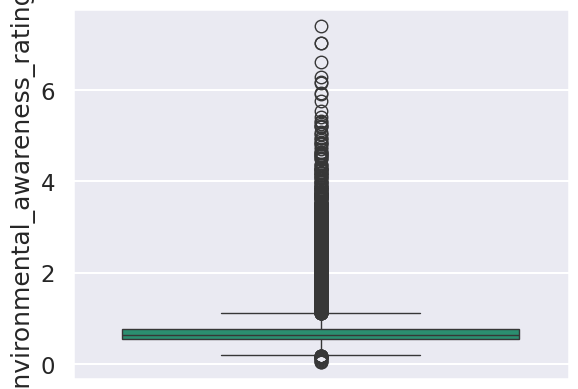

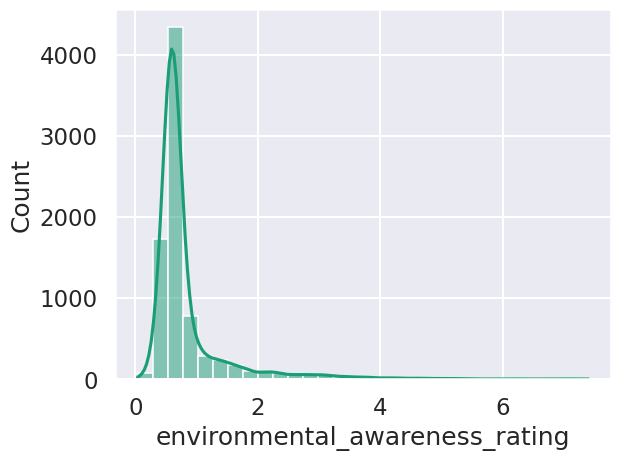

In [55]:
sns.boxplot(data['environmental_awareness_rating'])
plt.show()
sns.histplot(data['environmental_awareness_rating'], bins=30, kde=True)
plt.show()

From this histplot we noticed that it had a very long tail and that it was super skewed to the right, so from now on we decided the best approach for this type of cases was to use the log function.

In [56]:
# check how many outliers
Q1 = data['environmental_awareness_rating'].quantile(0.25)  # 25th percentile
Q3 = data['environmental_awareness_rating'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers

outliers = data[(data['environmental_awareness_rating'] < lower_bound) |
                (data['environmental_awareness_rating'] > upper_bound)]

print(outliers.count())

citizen_id                            1149
avg_monthly_entertainment_expenses    1114
avg_weekly_exercise_hours             1114
country                               1149
eco_consciousness_score               1127
education_level                       1149
environmental_awareness_rating        1149
financial_wellness_index              1149
health_consciousness_rating           1107
investment_portfolio_value            1137
investments_risk_appetite             1105
investments_risk_tolerance            1123
last_year_charity_donations           1134
marital_status                        1149
social_media_influence_score          1149
stress_management_score               1113
gender                                1149
well_being_level                      1132
continent                             1149
age                                   1149
education_category                    1149
financial_wellness_category           1149
dtype: int64


In [57]:
#Log transform to scale (log1p handles 0 safely)
data['environmental_awareness_rating_scaled'] = np.log1p(data['environmental_awareness_rating'])

We decided to use the log-transform to reduce right skew and handle extreme values because log1p handles 0s safely

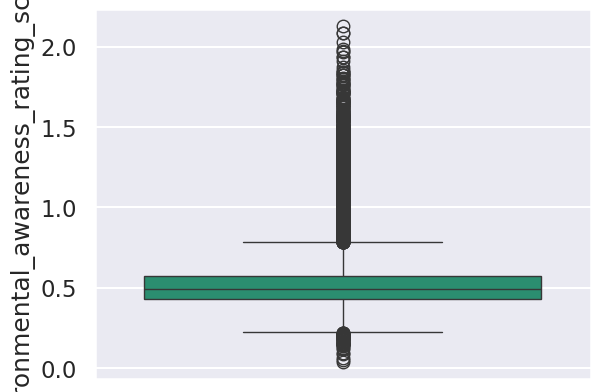

In [58]:
#boxplot
sns.boxplot(data['environmental_awareness_rating_scaled'])
plt.show()

In [59]:
#Scale using RobustScaler
scaler = RobustScaler()
data['environmental_awareness_rating_scaled'] = scaler.fit_transform(data[['environmental_awareness_rating_scaled']])

Applied RobustScaler to reduce influence of outliers while preserving data structure

In [60]:
#check how many above 10
sum(data['environmental_awareness_rating_scaled'] > 10)
#drop them
data = data[data['environmental_awareness_rating_scaled'] <= 10]

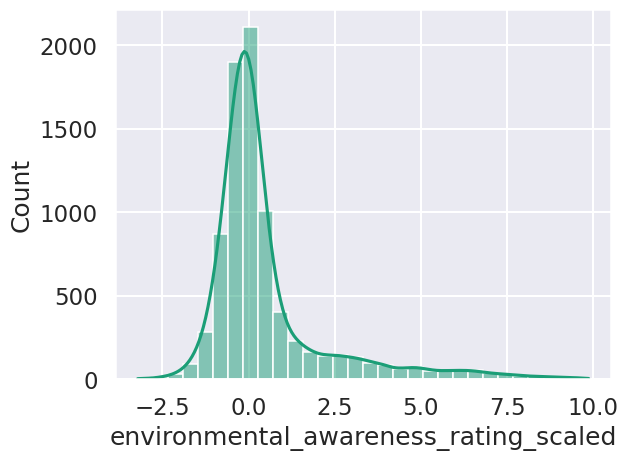

In [61]:
sns.histplot(data['environmental_awareness_rating_scaled'], bins=30, kde=True)
plt.show()

### Health Consciousness Rating

In [62]:
data['health_consciousness_rating'].isnull().sum()

np.int64(238)

In [63]:
#Fill nulls with grouped medians
data['health_consciousness_rating'] = data['health_consciousness_rating'].fillna(
    data.groupby('well_being_level')['health_consciousness_rating'].transform('median')
)

#Fallback to global median for remaining NaNs
global_median = data['health_consciousness_rating'].median()
data['health_consciousness_rating'] = data['health_consciousness_rating'].fillna(global_median)


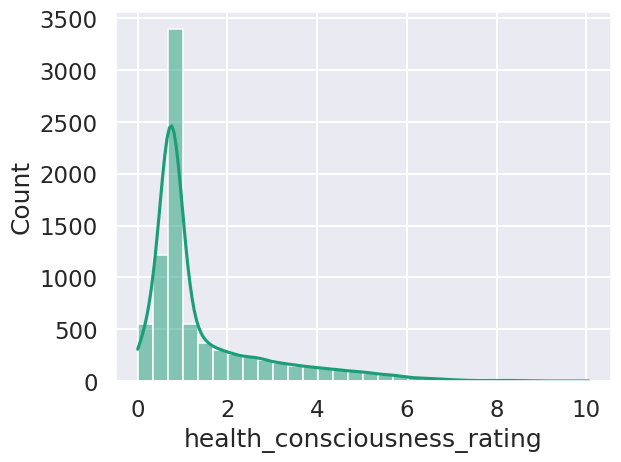

In [64]:
#histplot
sns.histplot(data['health_consciousness_rating'], bins=30, kde=True)
plt.show()

In [65]:
#Log transform (log1p handles 0 safely)
data['health_consciousness_rating_scaled'] = np.log1p(data['health_consciousness_rating'])

In [66]:
#Scale using RobustScaler
scaler = RobustScaler()
data['health_consciousness_rating_scaled'] = scaler.fit_transform(data[['health_consciousness_rating_scaled']])

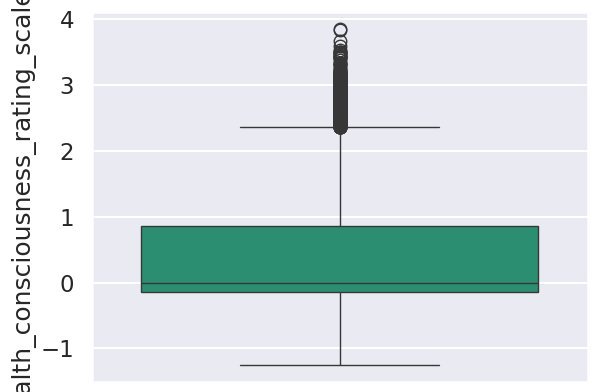

In [67]:
sns.boxplot(data['health_consciousness_rating_scaled'])
plt.show()

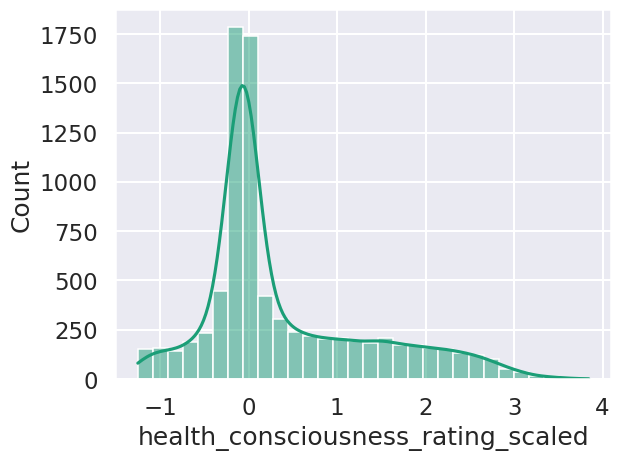

In [68]:
#histplot
sns.histplot(data['health_consciousness_rating_scaled'], bins=30, kde=True)
plt.show()

In [69]:
#check data type
data['health_consciousness_rating_scaled'].dtype

dtype('float64')

### Avg Monthly Entertainment Expenses

In [70]:
data['avg_monthly_entertainment_expenses'].describe()

count    7918.000000
mean       21.604733
std        17.434872
min         0.000000
25%         8.128325
50%        11.995050
75%        38.779000
max       135.420000
Name: avg_monthly_entertainment_expenses, dtype: float64

MISSING VALUES

In [71]:
#check for missing values
data['avg_monthly_entertainment_expenses'].isnull().sum()

np.int64(244)

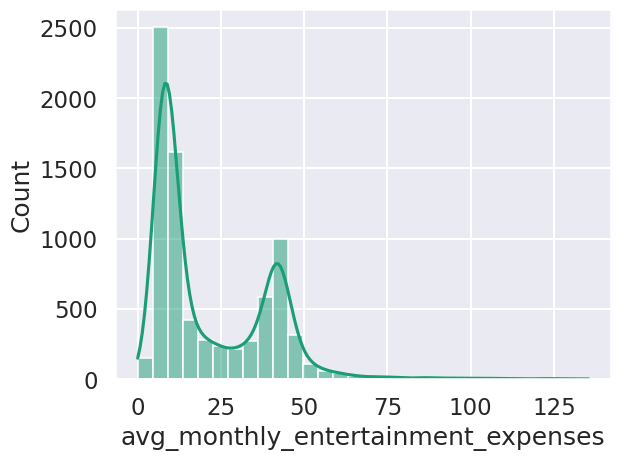

In [72]:
#histplot
sns.histplot(data['avg_monthly_entertainment_expenses'], bins=30, kde=True)
plt.show()

In [73]:
#Fill nulls with grouped medians
data['avg_monthly_entertainment_expenses'] = data['avg_monthly_entertainment_expenses'].fillna(
    data.groupby('stress_management_score')['avg_monthly_entertainment_expenses'].transform('median')
)

#Fallback to global median for remaining NaNs
global_median = data['avg_monthly_entertainment_expenses'].median()
data['avg_monthly_entertainment_expenses'] = data['avg_monthly_entertainment_expenses'].fillna(global_median)

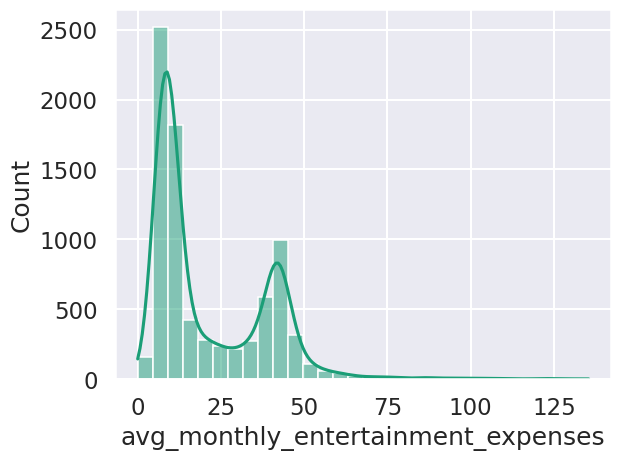

In [74]:
#histplot
sns.histplot(data['avg_monthly_entertainment_expenses'], bins=30, kde=True)
plt.show()

In [75]:
#check for outliers
data['avg_monthly_entertainment_expenses'].describe()

count    8162.000000
mean       21.359713
std        17.272204
min         0.000000
25%         8.183200
50%        11.994500
75%        38.296100
max       135.420000
Name: avg_monthly_entertainment_expenses, dtype: float64

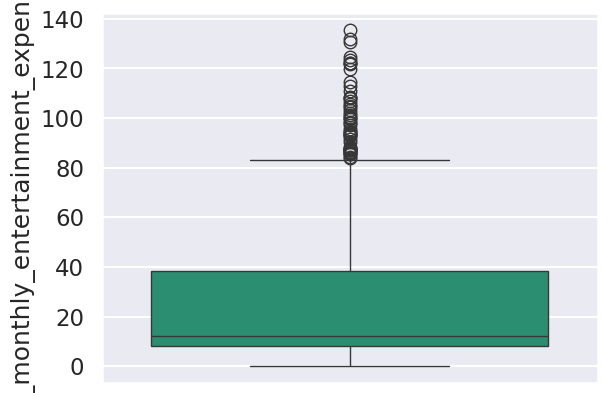

In [76]:
#boxplot
sns.boxplot(data['avg_monthly_entertainment_expenses'])
plt.show()

In [77]:
Q1 = data['avg_monthly_entertainment_expenses'].quantile(0.25)  # 25th percentile
Q3 = data['avg_monthly_entertainment_expenses'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = data[(data['avg_monthly_entertainment_expenses'] < lower_bound) |
                (data['avg_monthly_entertainment_expenses'] > upper_bound)]

print(outliers.count())

citizen_id                               53
avg_monthly_entertainment_expenses       53
avg_weekly_exercise_hours                53
country                                  53
eco_consciousness_score                  50
education_level                          53
environmental_awareness_rating           53
financial_wellness_index                 53
health_consciousness_rating              53
investment_portfolio_value               52
investments_risk_appetite                51
investments_risk_tolerance               52
last_year_charity_donations              52
marital_status                           53
social_media_influence_score             53
stress_management_score                  51
gender                                   53
well_being_level                         49
continent                                53
age                                      53
education_category                       53
financial_wellness_category              53
environmental_awareness_rating_s

In [78]:
data['avg_monthly_entertainment_expenses'] = data['avg_monthly_entertainment_expenses'].clip(lower_bound, upper_bound)

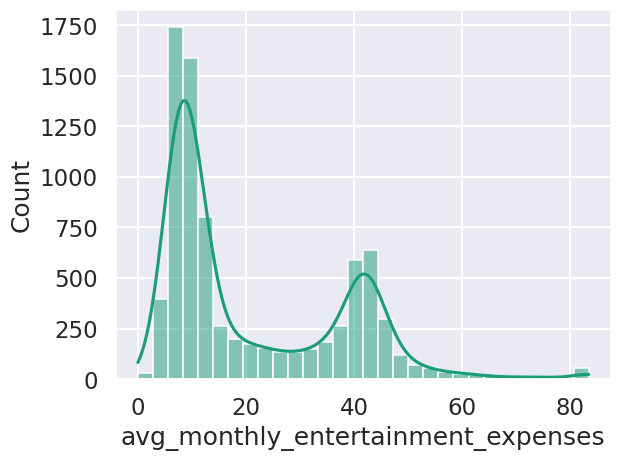

In [79]:
#histplot
sns.histplot(data['avg_monthly_entertainment_expenses'], bins=30, kde=True)
plt.show()

### Avg Weekly Exercise Hours

In [80]:
# Describe
data['avg_weekly_exercise_hours'].describe()

count    7955.000000
mean        0.705825
std         1.182614
min        -5.579400
25%         0.022400
50%         0.109300
75%         1.024250
max         8.701700
Name: avg_weekly_exercise_hours, dtype: float64

In [81]:
#check nulls
data['avg_weekly_exercise_hours'].isnull().sum()

np.int64(207)

In [82]:
#Fill nulls with median value (best for skewed data)
data['avg_weekly_exercise_hours'] = data['avg_weekly_exercise_hours'].fillna(
    data['avg_weekly_exercise_hours'].median()
)

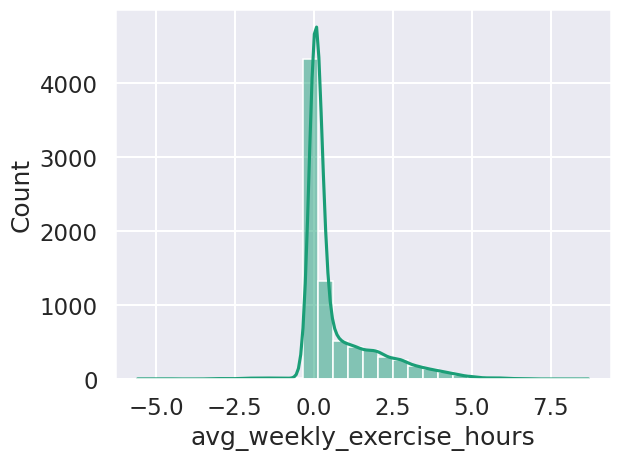

In [83]:
sns.histplot(data['avg_weekly_exercise_hours'], bins=30, kde=True)
plt.show()

We notice that we have negative hours for a varaible that shoult had negative values, so we decide do cap the lower bound to 0 since its the minimal possible value.

In [84]:
#lower bound to 0
data['avg_weekly_exercise_hours'] = data['avg_weekly_exercise_hours'].clip(lower=0)

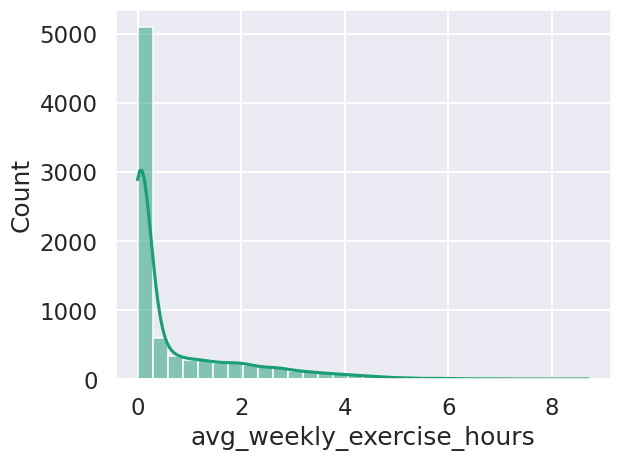

In [85]:
sns.histplot(data['avg_weekly_exercise_hours'], bins=30, kde=True)
plt.show()

In [86]:
Q1 = data['avg_weekly_exercise_hours'].quantile(0.25)  # 25th percentile
Q3 = data['avg_weekly_exercise_hours'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = data[(data['avg_weekly_exercise_hours'] < lower_bound) |
                (data['avg_weekly_exercise_hours'] > upper_bound)]

print(outliers.count())
print(upper_bound)
print(lower_bound)

citizen_id                               842
avg_monthly_entertainment_expenses       842
avg_weekly_exercise_hours                842
country                                  842
eco_consciousness_score                  819
education_level                          842
environmental_awareness_rating           842
financial_wellness_index                 842
health_consciousness_rating              842
investment_portfolio_value               826
investments_risk_appetite                816
investments_risk_tolerance               824
last_year_charity_donations              831
marital_status                           842
social_media_influence_score             842
stress_management_score                  814
gender                                   842
well_being_level                         832
continent                                842
age                                      842
education_category                       842
financial_wellness_category              842
environmen

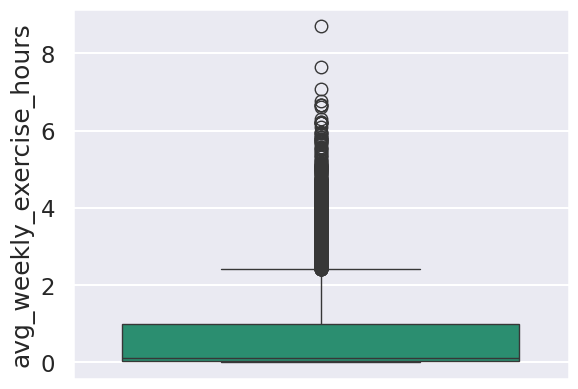

In [87]:
sns.boxplot(data['avg_weekly_exercise_hours'])
plt.show()

In [88]:
# Log transformation (add 1 to handle zeros)
data['avg_weekly_exercise_hours_scaled'] = np.log1p(data['avg_weekly_exercise_hours'])

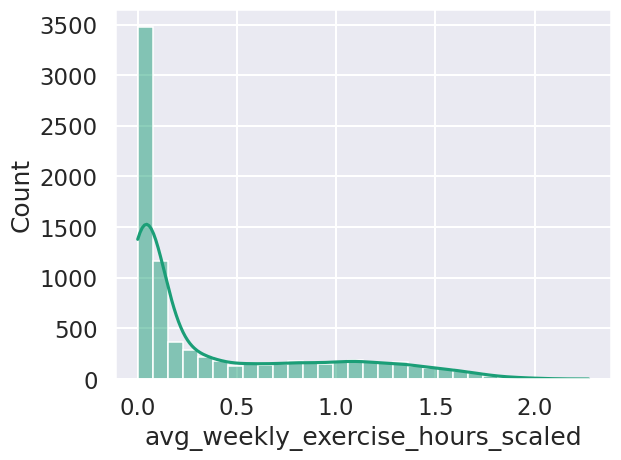

In [89]:
sns.histplot(data['avg_weekly_exercise_hours_scaled'], bins=30, kde=True)
plt.show()

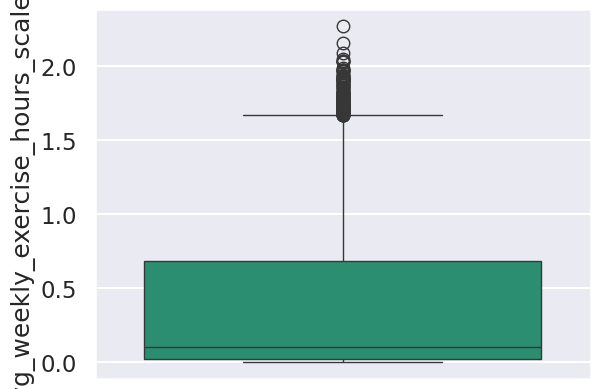

In [90]:
sns.boxplot(data['avg_weekly_exercise_hours_scaled'])
plt.show()

In [91]:
#how many above 2
sum(data['avg_weekly_exercise_hours_scaled'] > 2)
#drop them
data = data[data['avg_weekly_exercise_hours_scaled'] <= 2]

### Stress Management Score

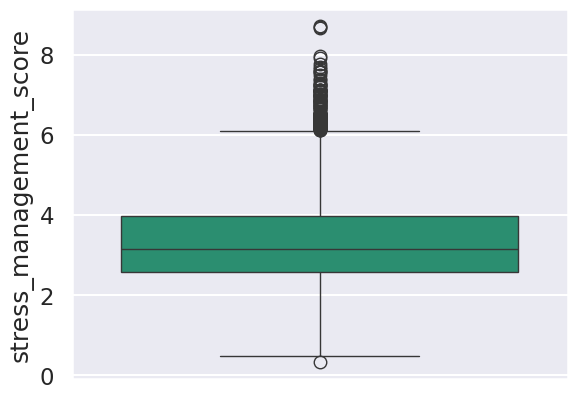

In [92]:
sns.boxplot(data['stress_management_score'])
plt.show()

In [93]:
data["stress_management_score"].isnull().sum()

np.int64(285)

The highest correlations we had on all the columns was 0.75 between stress management score and well being level, so we will use it to fill the nulls

In [94]:
#highest correlation is with well being level, 0.75
#Fill nulls with grouped medians
data['stress_management_score'] = data['stress_management_score'].fillna(
    data.groupby('well_being_level')['stress_management_score'].transform('median')
)

#Fallback to global median for remaining NaNs
global_median = data['stress_management_score'].median()
data['stress_management_score'] = data['stress_management_score'].fillna(global_median)

In [95]:
data["stress_management_score"].describe()

count    8154.000000
mean        3.314757
std         1.097674
min         0.319200
25%         2.585950
50%         3.151700
75%         3.940050
max         8.712300
Name: stress_management_score, dtype: float64

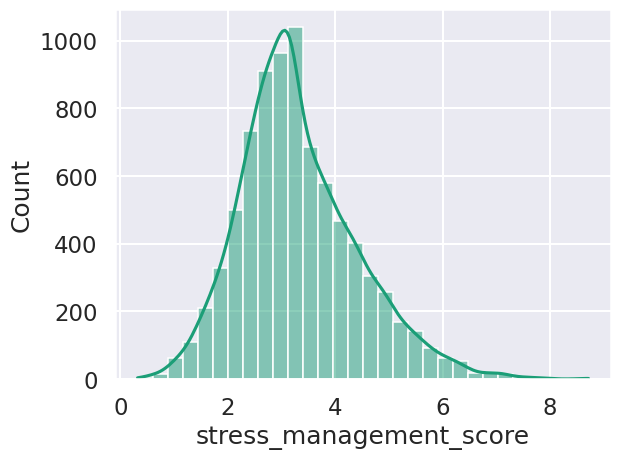

In [96]:
sns.histplot(data['stress_management_score'], bins=30, kde=True)
plt.show()

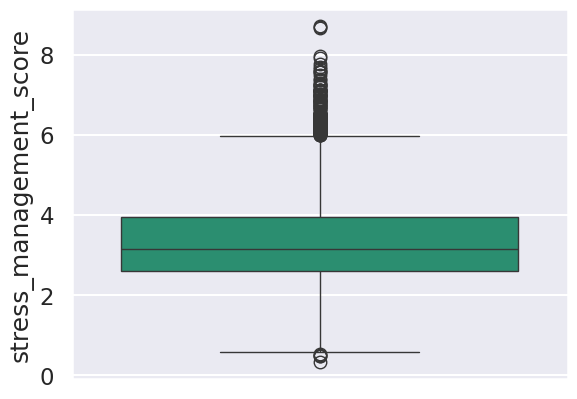

In [97]:
sns.boxplot(data['stress_management_score'])
plt.show()

In [98]:
Q1 = data['stress_management_score'].quantile(0.25)  # 25th percentile
Q3 = data['stress_management_score'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = data[(data['stress_management_score'] < lower_bound) |
                (data['stress_management_score'] > upper_bound)]

#count how many values above 8 and below the lower bound (0.43389999) and drop them
data= data[data['stress_management_score'] <= 8]
data= data[data['stress_management_score'] >= 0.43389999]


### Eco Consciousness Score (Dropped)

In [99]:
data['eco_consciousness_score'].isnull().sum()

np.int64(204)

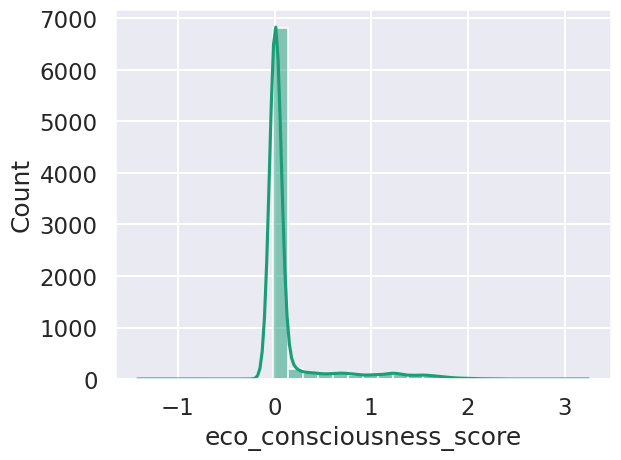

In [100]:
sns.histplot(data['eco_consciousness_score'], bins=30, kde=True)
plt.show()

In [101]:
#describe
data['eco_consciousness_score'].describe()

count    7946.000000
mean        0.131844
std         0.358597
min        -1.416700
25%         0.000000
50%         0.007800
75%         0.024500
max         3.247500
Name: eco_consciousness_score, dtype: float64

Remove the values below zero.

In [102]:
#lower bound to 0
data['eco_consciousness_score'] = data['eco_consciousness_score'].clip(lower=0)
#Log transform in-place (log1p handles 0 safely)
data['eco_consciousness_score'] = np.log1p(data['eco_consciousness_score'])

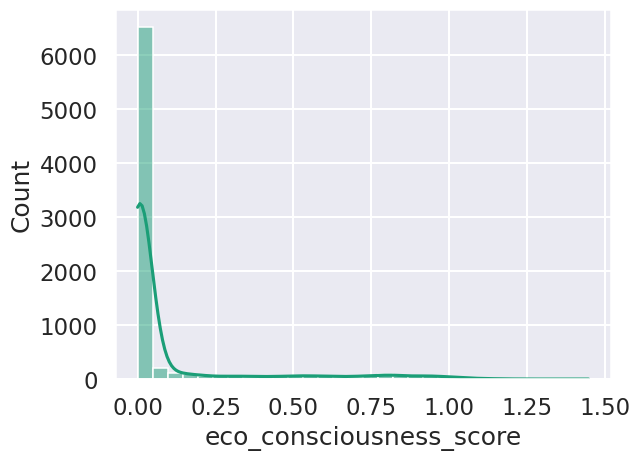

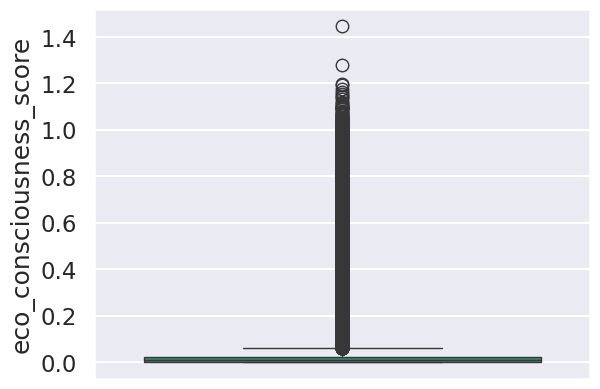

In [103]:
sns.histplot(data['eco_consciousness_score'], bins=30, kde=True)
plt.show()
sns.boxplot(data['eco_consciousness_score'])
plt.show()

In [104]:
Q1 = data['eco_consciousness_score'].quantile(0.25)  # 25th percentile
Q3 = data['eco_consciousness_score'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = data[(data['eco_consciousness_score'] < lower_bound) |
                (data['eco_consciousness_score'] > upper_bound)]

print(outliers.count())

citizen_id                               1348
avg_monthly_entertainment_expenses       1348
avg_weekly_exercise_hours                1348
country                                  1348
eco_consciousness_score                  1348
education_level                          1348
environmental_awareness_rating           1348
financial_wellness_index                 1348
health_consciousness_rating              1348
investment_portfolio_value               1334
investments_risk_appetite                1299
investments_risk_tolerance               1313
last_year_charity_donations              1325
marital_status                           1348
social_media_influence_score             1348
stress_management_score                  1348
gender                                   1348
well_being_level                         1318
continent                                1348
age                                      1348
education_category                       1348
financial_wellness_category       

In [105]:
# Clip only beyond a wider range (e.g. 2.5 * IQR instead of 1.5)
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR
data['eco_consciousness_score'] = data['eco_consciousness_score'].clip(lower_bound, upper_bound)

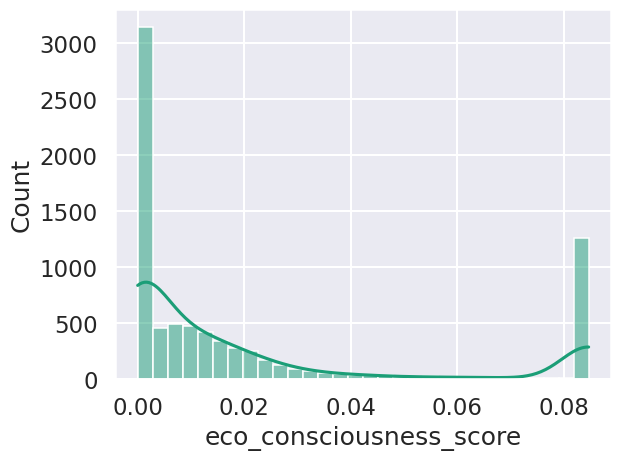

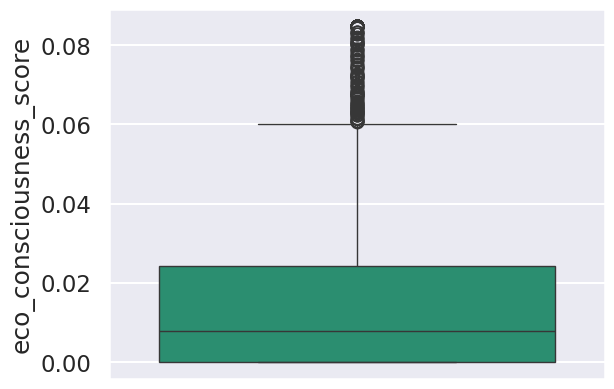

In [106]:
sns.histplot(data['eco_consciousness_score'], bins=30, kde=True)
plt.show()
sns.boxplot(data['eco_consciousness_score'])
plt.show()

In [107]:
#drop column
data.drop('eco_consciousness_score', axis=1, inplace=True)
numerical_features.remove('eco_consciousness_score')

After looking at the data and doing some cleaning, we decided to drop the eco_consciousness_score column. Most of the values were close to zero, and some were even negative, which didn’t make sense. It also didn’t have a strong connection with other features, so we felt it wasn’t useful for our analysis.

### Well Being Level

In [108]:
data["well_being_level"].isnull().sum()

np.int64(121)

In [109]:
data["well_being_level"].describe()

count    8029.000000
mean        4.764056
std         1.931625
min         1.153900
25%         3.415700
50%         4.319700
75%         5.614300
max        14.114300
Name: well_being_level, dtype: float64

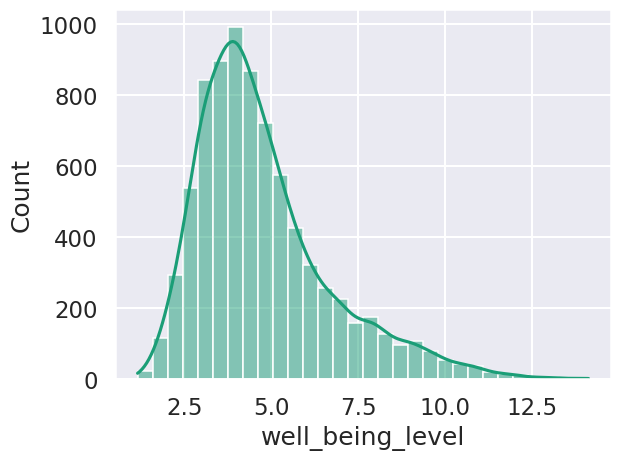

In [110]:
sns.histplot(data['well_being_level'], bins=30, kde=True)
plt.show()

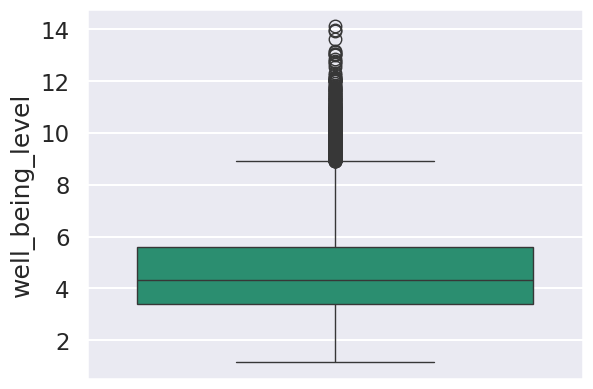

In [111]:
sns.boxplot(data['well_being_level'])
plt.show()

We decided to use the KNN imputer to fill in the missing values for well_being_level using stress_management_score and health_consciousness_rating, since these features are related (0.75 and 0.67) and can help estimate the missing values more accurately.

In [112]:
#use the knn inputer to fill the missing values with the stress_managemnet_score and health_consciousness_rating

cols = ['well_being_level', 'stress_management_score', 'health_consciousness_rating']

# Step 2: Apply KNN imputer
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(data[cols])

# Step 3: Update only 'well_being_level' (first column of result)
data['well_being_level'] = imputed_array[:, 0]

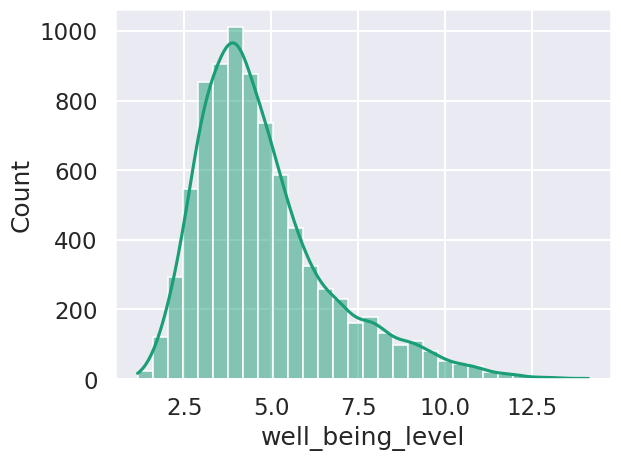

In [113]:
sns.histplot(data['well_being_level'], bins=30, kde=True)
plt.show()

In [114]:
data['well_being_level'].describe()

count    8150.000000
mean        4.768807
std         1.933070
min         1.153900
25%         3.422525
50%         4.323200
75%         5.623875
max        14.114300
Name: well_being_level, dtype: float64

In [115]:
# Calculate IQR
Q1 = data['well_being_level'].quantile(0.25)
Q3 = data['well_being_level'].quantile(0.75)
IQR = Q3 - Q1

# Define wider bounds (2.5x IQR)
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

# Clip the values
data['well_being_level'] = data['well_being_level'].clip(lower_bound, upper_bound)

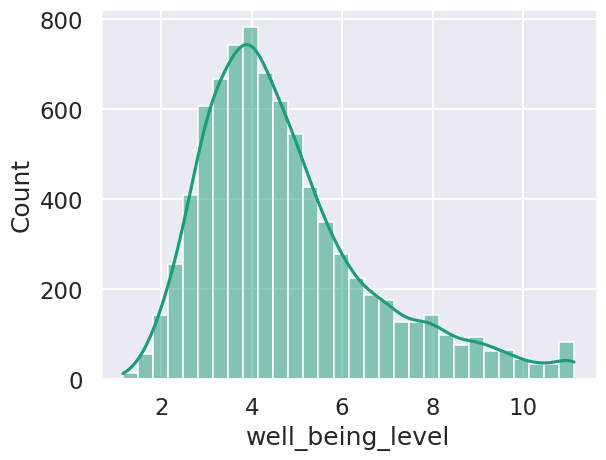

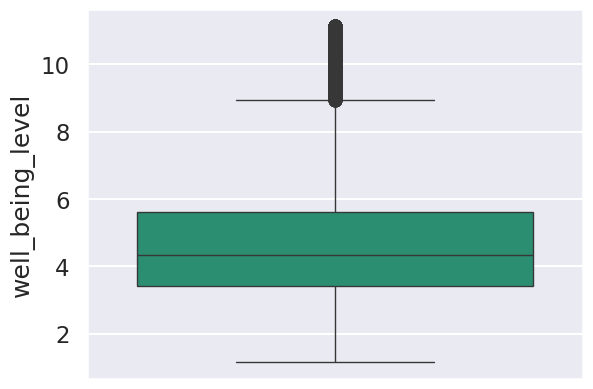

In [116]:
sns.histplot(data['well_being_level'], bins=30, kde=True)
plt.show()
sns.boxplot(data['well_being_level'])
plt.show()

### Last Year Charity Donations (Dropped)

In [117]:
data["last_year_charity_donations"].isnull().sum()

np.int64(124)

In [118]:
data["last_year_charity_donations"].describe()

count    8026.000000
mean        0.380160
std         0.762389
min         0.000000
25%         0.000000
50%         0.010300
75%         0.308350
max         5.599100
Name: last_year_charity_donations, dtype: float64

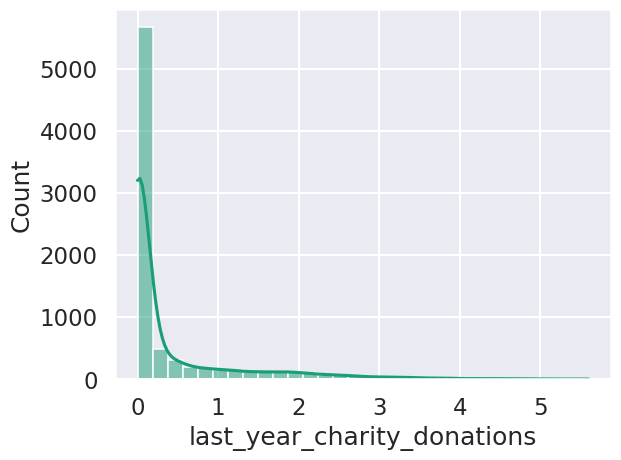

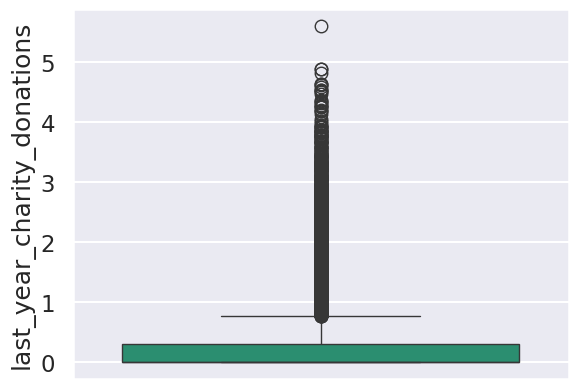

In [119]:
sns.histplot(data['last_year_charity_donations'], bins=30, kde=True)
plt.show()
sns.boxplot(data['last_year_charity_donations'])
plt.show()

In [120]:
data['last_year_charity_donations'] = data.groupby('country')['last_year_charity_donations'].transform(
    lambda x: x.fillna(x.median())
)

In [121]:
Q1 = data['last_year_charity_donations'].quantile(0.25)  # 25th percentile
Q3 = data['last_year_charity_donations'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = data[(data['last_year_charity_donations'] < lower_bound) |
                (data['last_year_charity_donations'] > upper_bound)]

print(outliers.count())

citizen_id                               1398
avg_monthly_entertainment_expenses       1398
avg_weekly_exercise_hours                1398
country                                  1398
education_level                          1398
environmental_awareness_rating           1398
financial_wellness_index                 1398
health_consciousness_rating              1398
investment_portfolio_value               1379
investments_risk_appetite                1358
investments_risk_tolerance               1376
last_year_charity_donations              1398
marital_status                           1398
social_media_influence_score             1398
stress_management_score                  1398
gender                                   1398
well_being_level                         1398
continent                                1398
age                                      1398
education_category                       1398
financial_wellness_category              1398
environmental_awareness_rating_sca

In [122]:
#multiply all the rows by 1000 to check real values (it was in thousands)
data['last_year_charity_donations'] = data['last_year_charity_donations'] * 1000

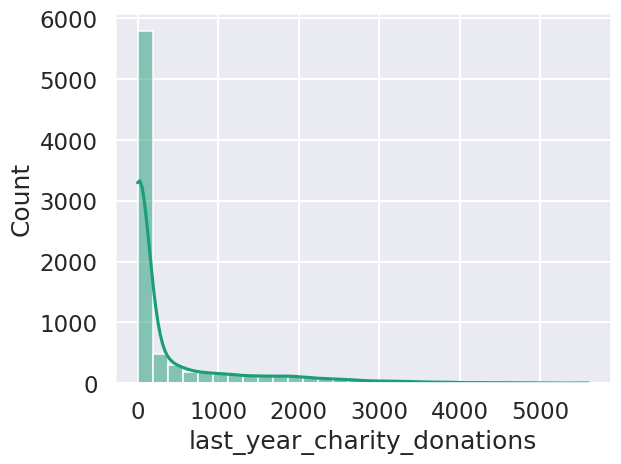

In [123]:
sns.histplot(data['last_year_charity_donations'], bins=30, kde=True)
plt.show()

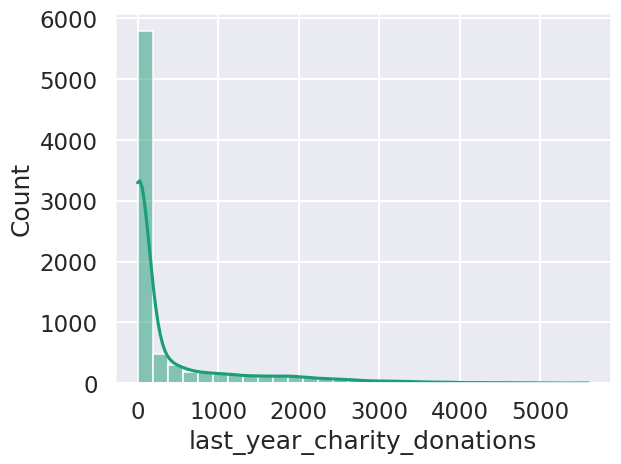

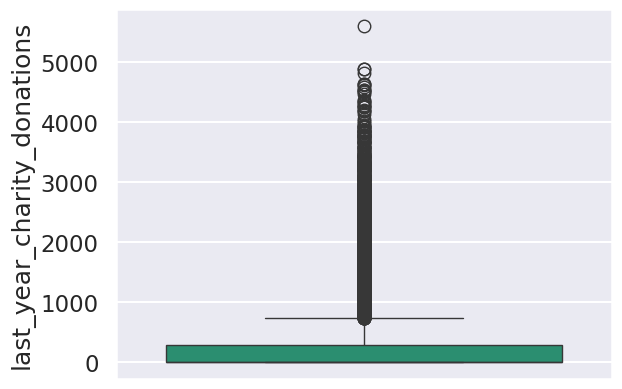

In [124]:
sns.histplot(data['last_year_charity_donations'], bins=30, kde=True)
plt.show()
sns.boxplot(data['last_year_charity_donations'])
plt.show()

In [125]:
#drop the column
data.drop('last_year_charity_donations', axis=1, inplace=True)
numerical_features.remove('last_year_charity_donations')

Like the eco consciousness score, we decided that this column is also not useful for our analysis as it was very skewed, so we decided to drop it.

### Investment Portfolio Value

In [126]:
data["investment_portfolio_value"].isnull().sum()

np.int64(122)

In [127]:
data["investment_portfolio_value"].describe()

count    8028.000000
mean       12.427846
std        21.257472
min         0.000000
25%         3.294425
50%         8.595200
75%        13.260825
max       294.950000
Name: investment_portfolio_value, dtype: float64

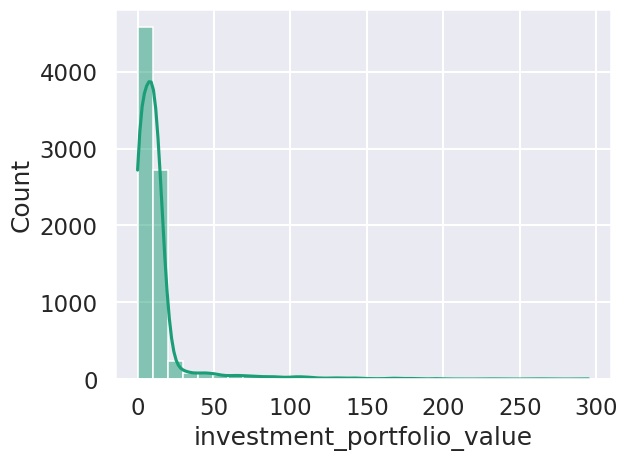

In [128]:
sns.histplot(data['investment_portfolio_value'], bins=30, kde=True)
plt.show()

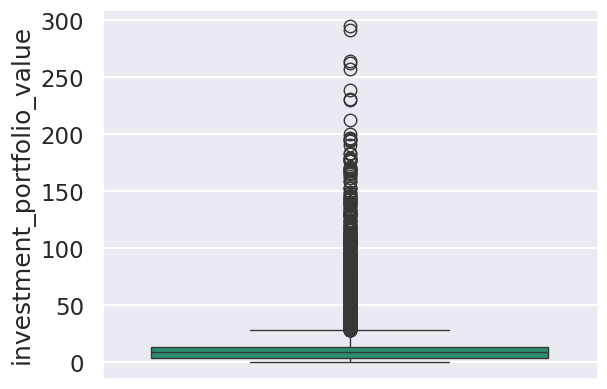

In [129]:
sns.boxplot(data['investment_portfolio_value'])
plt.show()

In [130]:
data['investment_portfolio_value'] = data.groupby('country')['investment_portfolio_value'].transform(
    lambda x: x.fillna(x.median())
)

In [131]:
upper_bound = data['investment_portfolio_value'].quantile(0.995)  # 99.5th percentile

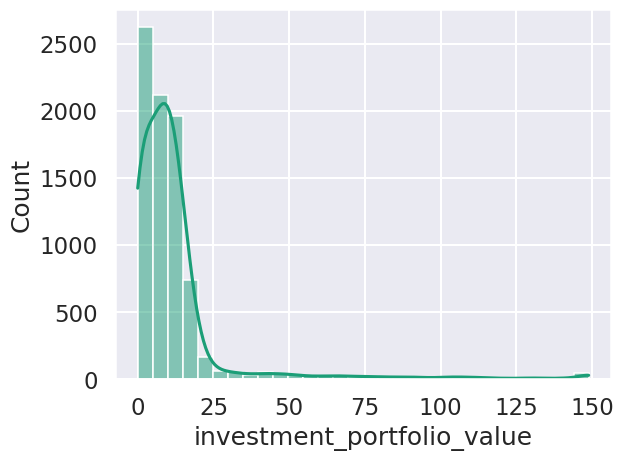

In [132]:
data['investment_portfolio_value'] = data['investment_portfolio_value'].clip(upper=upper_bound)
sns.histplot(data['investment_portfolio_value'], bins=30, kde=True)
plt.show()

In [133]:
data['investment_portfolio_value_scaled'] = np.log1p(data['investment_portfolio_value'])

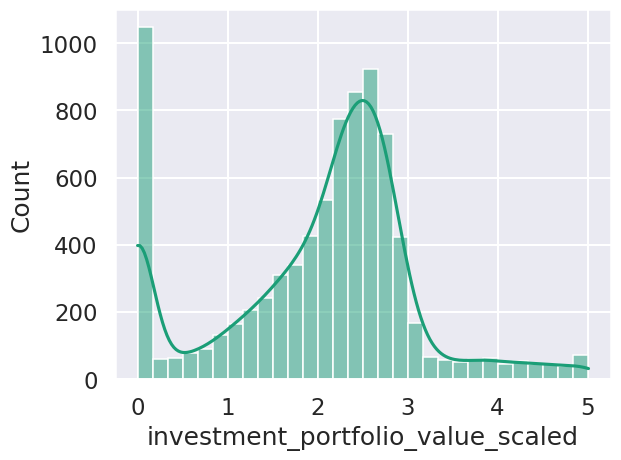

In [134]:
sns.histplot(data['investment_portfolio_value_scaled'], bins=30, kde=True)
plt.show()

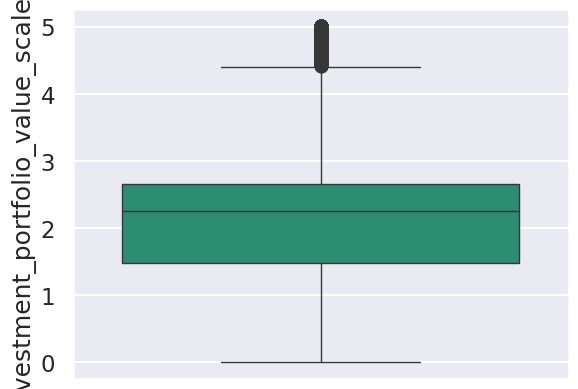

In [135]:
sns.boxplot(data['investment_portfolio_value_scaled'])
plt.show()

### Social Media Influence Score

In [136]:
data["social_media_influence_score"].isnull().sum()

np.int64(0)

In [137]:
data["social_media_influence_score"].describe()

count    8150.000000
mean        6.101341
std         4.328048
min         0.003500
25%         3.166625
50%         4.400600
75%         8.206925
max        42.176800
Name: social_media_influence_score, dtype: float64

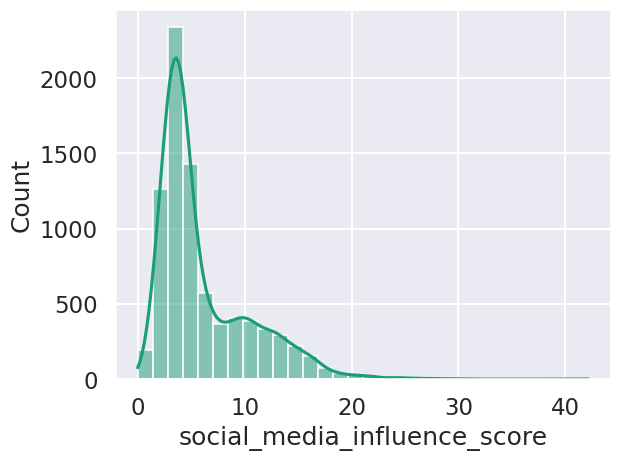

In [138]:
sns.histplot(data['social_media_influence_score'], bins=30, kde=True)
plt.show()

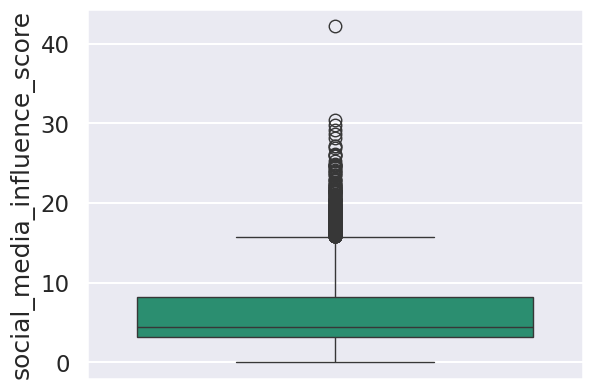

In [139]:
sns.boxplot(data['social_media_influence_score'])
plt.show()

In [140]:
#drop the highest value
data = data[data['social_media_influence_score'] != data['social_media_influence_score'].max()]

In [141]:
Q1 = data['social_media_influence_score'].quantile(0.25)  # 25th percentile
Q3 = data['social_media_influence_score'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = data[(data['social_media_influence_score'] < lower_bound) |
                (data['social_media_influence_score'] > upper_bound)]

print(outliers.count())
print(upper_bound)
print(lower_bound)

citizen_id                               311
avg_monthly_entertainment_expenses       311
avg_weekly_exercise_hours                311
country                                  311
education_level                          311
environmental_awareness_rating           311
financial_wellness_index                 311
health_consciousness_rating              311
investment_portfolio_value               311
investments_risk_appetite                303
investments_risk_tolerance               304
marital_status                           311
social_media_influence_score             311
stress_management_score                  311
gender                                   311
well_being_level                         311
continent                                311
age                                      311
education_category                       311
financial_wellness_category              311
environmental_awareness_rating_scaled    311
health_consciousness_rating_scaled       311
avg_weekly

In [142]:
#using the log scaler
data['social_media_influence_score_scaled'] = np.log1p(data['social_media_influence_score'])

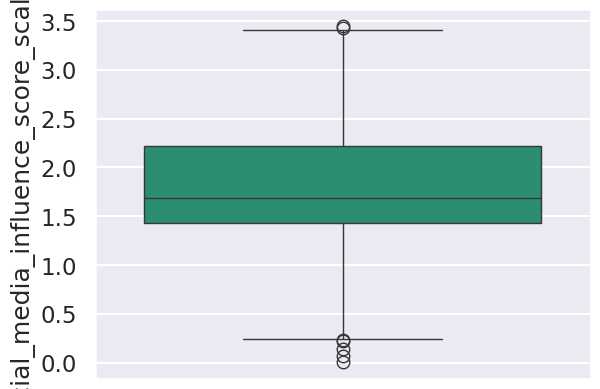

In [143]:
sns.boxplot(data['social_media_influence_score_scaled'])
plt.show()

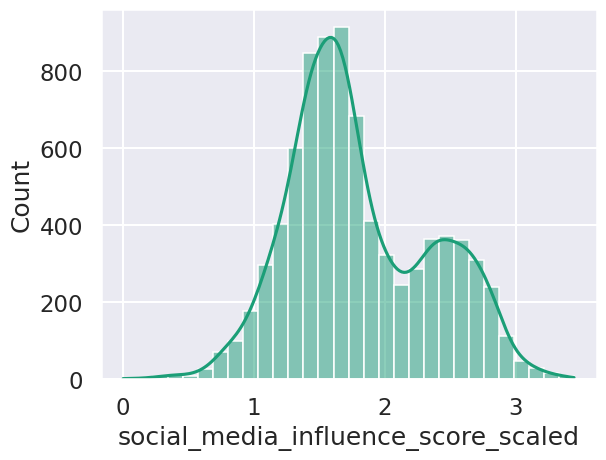

In [144]:
sns.histplot(data['social_media_influence_score_scaled'], bins=30, kde=True)
plt.show()

### Investment Risk Appetite

In [145]:
data["investments_risk_appetite"].isnull().sum()

np.int64(247)

In [146]:
data["investments_risk_appetite"].describe()

count    7902.000000
mean        4.377868
std         2.645865
min         0.000000
25%         1.854450
50%         4.813200
75%         6.874825
max         8.699500
Name: investments_risk_appetite, dtype: float64

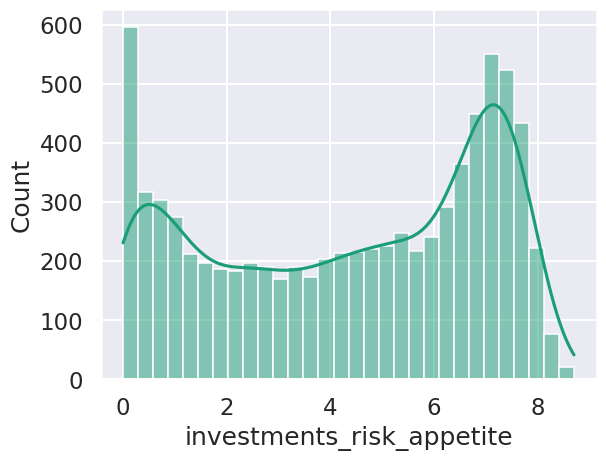

In [147]:
sns.histplot(data['investments_risk_appetite'], bins=30, kde=True)
plt.show()

In [148]:
#Fill nulls with grouped medians from the column with highest correlation
data['investments_risk_appetite'] = data['investments_risk_appetite'].fillna(
    data.groupby('investments_risk_tolerance')['investments_risk_appetite'].transform('median')
)

#Fallback to global median for remaining NaNs
global_median = data['investments_risk_appetite'].median()
data['investments_risk_appetite'] = data['investments_risk_appetite'].fillna(global_median)

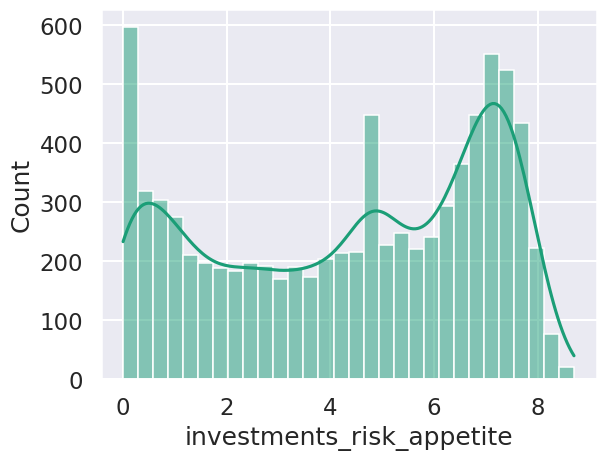

In [149]:
sns.histplot(data['investments_risk_appetite'], bins=30, kde=True)
plt.show()

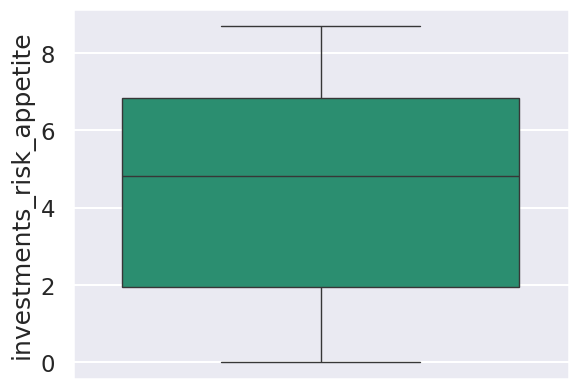

In [150]:
sns.boxplot(data['investments_risk_appetite'])
plt.show()

### Investment Risk Tolerance

In [151]:
data["investments_risk_tolerance"].isnull().sum()

np.int64(159)

In [152]:
data["investments_risk_tolerance"].describe()

count    7990.000000
mean        7.302446
std         3.666706
min         1.393700
25%         4.796850
50%         6.220600
75%         8.534000
max        29.513200
Name: investments_risk_tolerance, dtype: float64

In [153]:
#Fill nulls with grouped medians
data['investments_risk_tolerance'] = data['investments_risk_tolerance'].fillna(
    data.groupby('investments_risk_appetite')['investments_risk_tolerance'].transform('median')
)

#Fallback to global median for remaining NaNs
global_median = data['investments_risk_tolerance'].median()
data['investments_risk_tolerance'] = data['investments_risk_tolerance'].fillna(global_median)

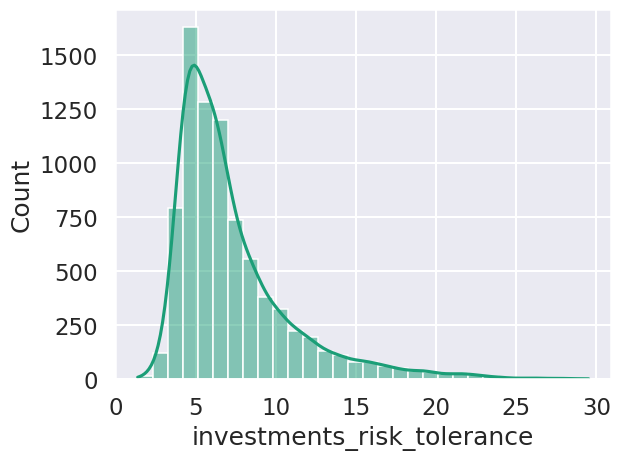

In [154]:
sns.histplot(data['investments_risk_tolerance'], bins=30, kde=True)
plt.show()

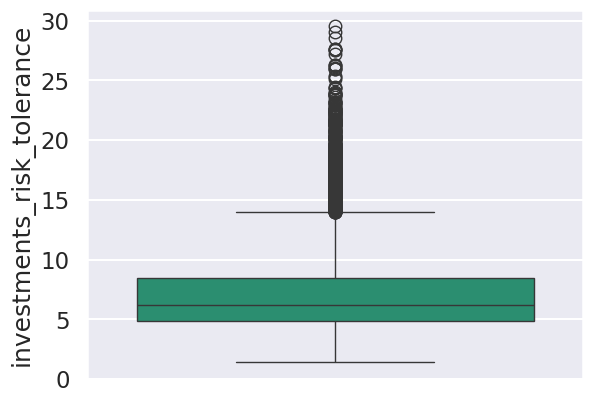

In [155]:
sns.boxplot(data['investments_risk_tolerance'])
plt.show()

In [156]:
# Scale it using log
data['investments_risk_tolerance_scaled'] = np.log1p(data['investments_risk_tolerance'])

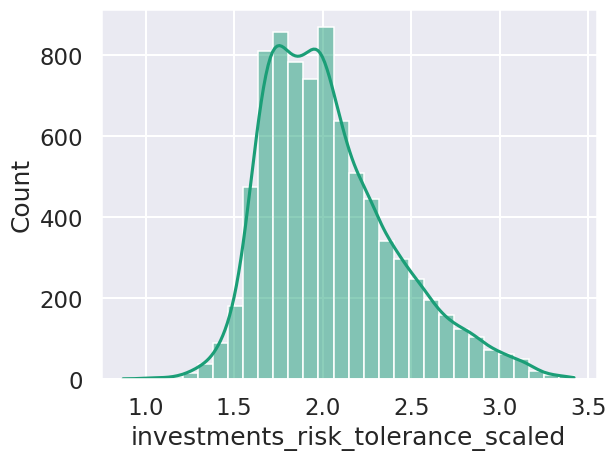

In [157]:
sns.histplot(data['investments_risk_tolerance_scaled'], bins=30, kde=True)
plt.show()

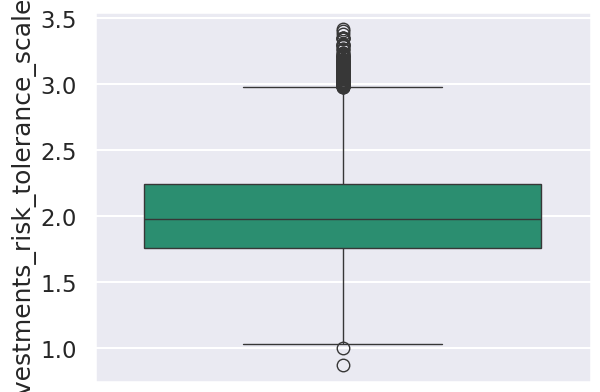

In [158]:
sns.boxplot(data['investments_risk_tolerance_scaled'])
plt.show()

# 5. Additional Insights

## Comparing lifestyle trends across the world

We analyzed key lifestyle metrics across continents to identify regional differences in behaviors, attitudes, and wellness.

Lifestyle Averages by Continent:
                well_being_level  avg_weekly_exercise_hours  \
continent                                                    
Asia                       4.84                       0.72   
Europe                     4.73                       0.69   
North America              4.78                       0.70   
Oceania                    4.80                       0.68   
South America              4.82                       0.82   

               financial_wellness_index  stress_management_score  \
continent                                                          
Asia                             107.40                     3.33   
Europe                           106.30                     3.30   
North America                    104.97                     3.33   
Oceania                          105.65                     3.31   
South America                    108.79                     3.36   

               social_media_influence_score  investmen

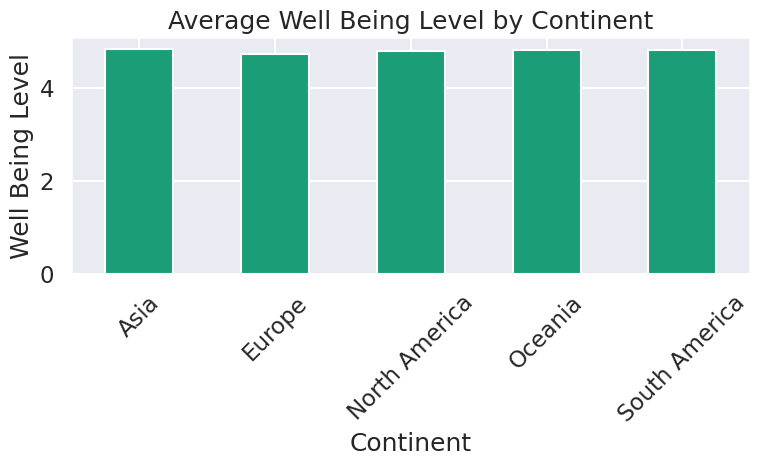

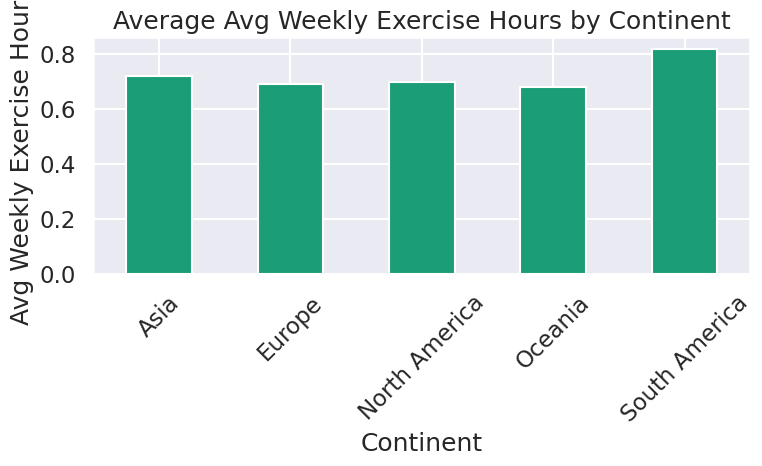

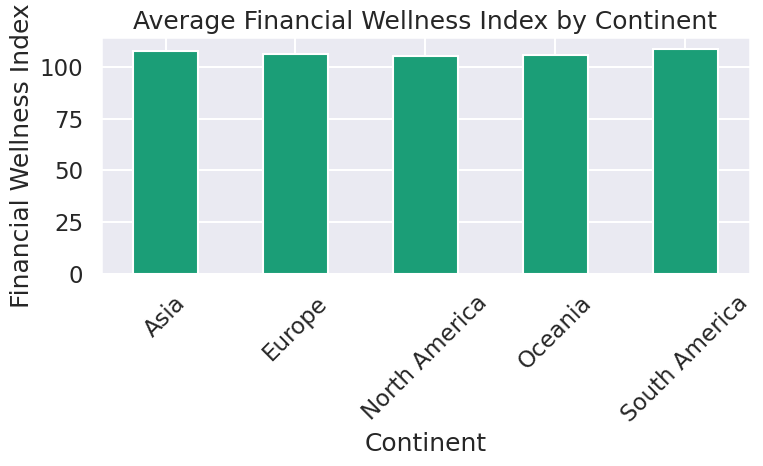

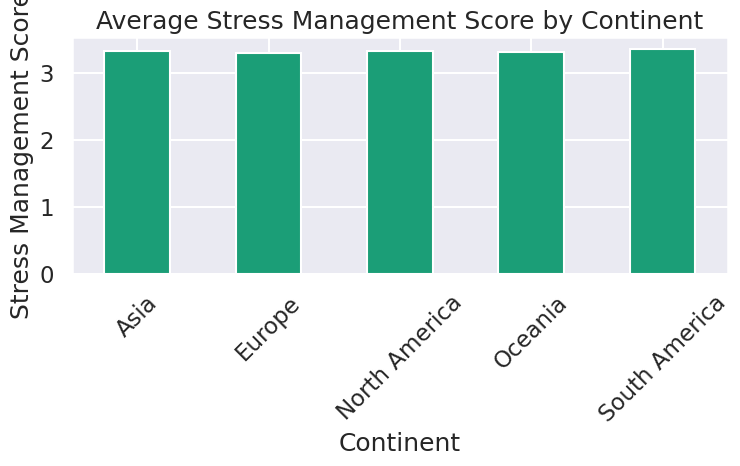

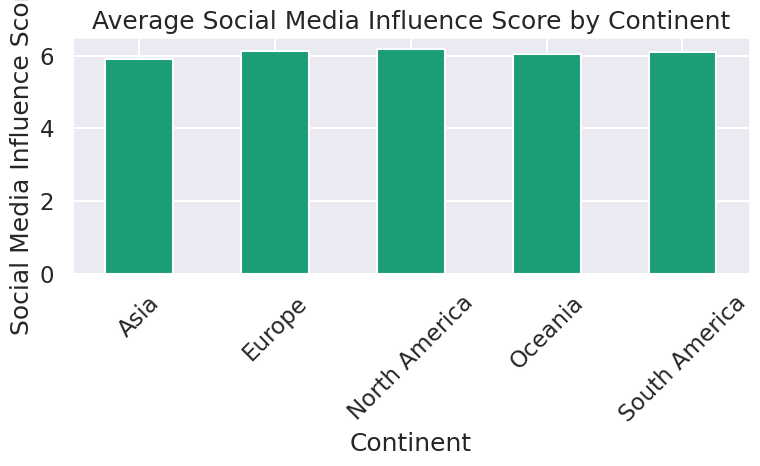

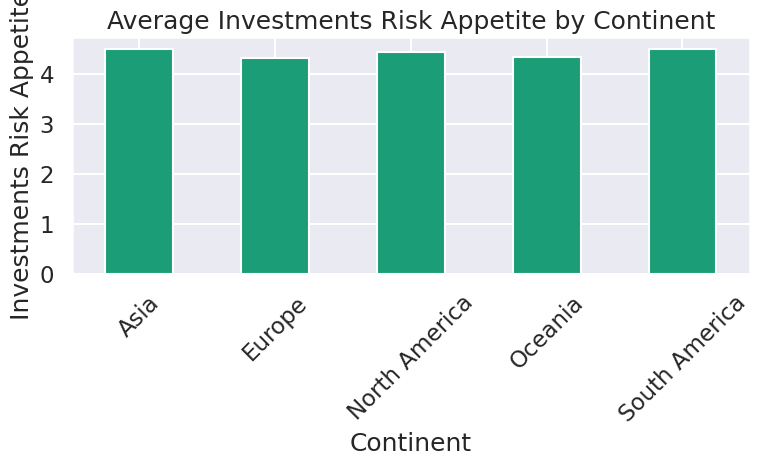

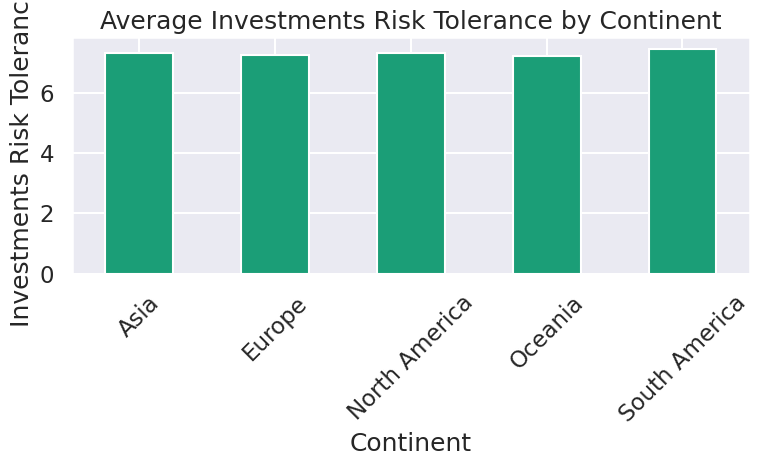

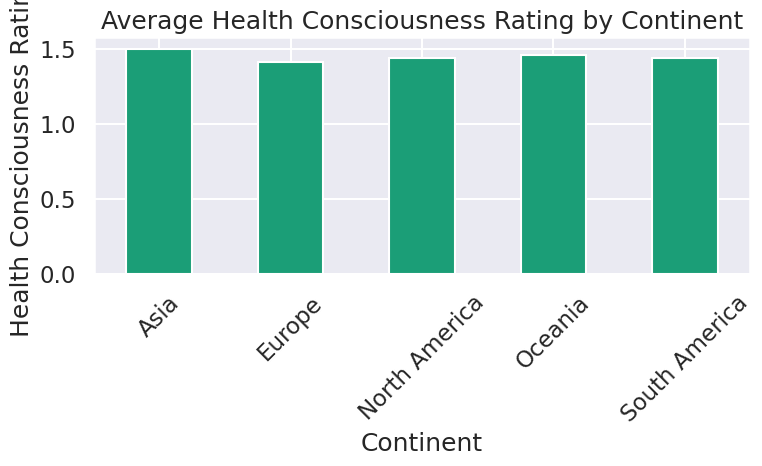

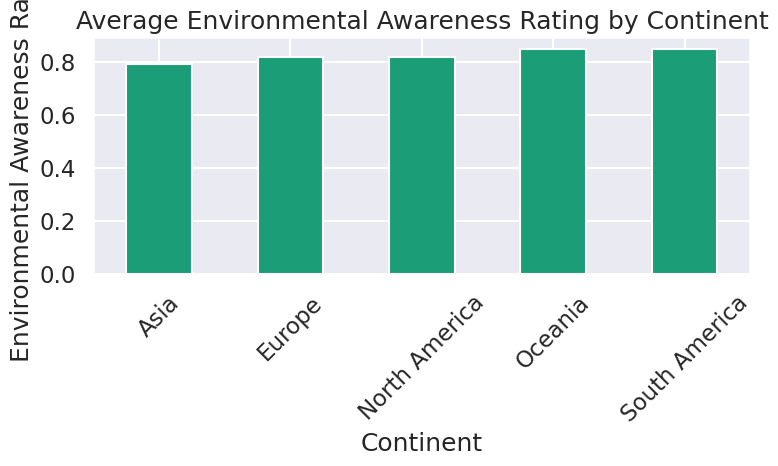

In [159]:
# Choose metrics to analyze
metrics = [
    "well_being_level",
    "avg_weekly_exercise_hours",
    "financial_wellness_index",
    "stress_management_score",
    "social_media_influence_score",
    "investments_risk_appetite",
    "investments_risk_tolerance",
    "health_consciousness_rating",
    "environmental_awareness_rating"
]

# Group and aggregate
continent_summary = data.groupby("continent")[metrics].mean().round(2)

# Display summary
print("Lifestyle Averages by Continent:\n", continent_summary)

# Plot metrics
for metric in metrics:
    plt.figure(figsize=(8, 5))
    continent_summary[metric].plot(kind='bar', title=f'Average {metric.replace("_", " ").title()} by Continent')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('Continent')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

By averaging lifestyle-related metrics by continent, we can't identify clear patterns that vary geographically, however we found :

  **Well-Being & Stress**: All regions report relatively similar well-being levels (~4.7–4.8), but South America has the highest stress management score (3.36), suggesting stronger coping strategies. Europe and Oceania show slightly lower scores here.

  **Exercise & Health**: South America leads in avg. weekly exercise hours (0.82), aligning with its high well-being and stress scores. Asia, while leading in health consciousness (1.50), has slightly lower actual exercise time, suggesting awareness doesn't always translate into behavior.

  **Financial Wellness**: All continents cluster around similar values, but South America has the highest financial wellness index (108.79), possibly contributing to its high lifestyle satisfaction metrics.

  **Environmental Awareness**: Europe and South America score highest in environmental awareness (~0.82), aligning with known eco-conscious movements in both regions.

  **Social Media & Investment**: North America is most active online (highest influence score: 6.20) and has one of the highest investment appetites, reinforcing its reputation for high digital and financial engagement. South America, however, shows the highest risk tolerance, suggesting confidence or risk-taking tendencies.

Furthermore we decided to explore the relationship between financial wellness and average weekly exercise hours.

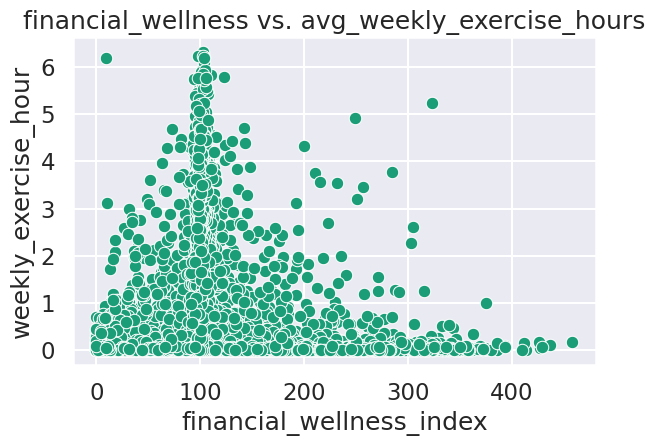

In [160]:
sns.scatterplot(data=data, x='financial_wellness_index', y='avg_weekly_exercise_hours')
plt.title("financial_wellness vs. avg_weekly_exercise_hours")
plt.xlabel("financial_wellness_index")
plt.ylabel("weekly_exercise_hour")
plt.grid(True)
plt.tight_layout()
plt.show()

There is a noticeable concentration of higher financial wellness scores around individuals who exercise moderately (0–3 hours/week).

## Investigating citizen behaviors

We picked the 4 highest correlations and investigated them

### Well-Being vs. Stress Management (0.75)

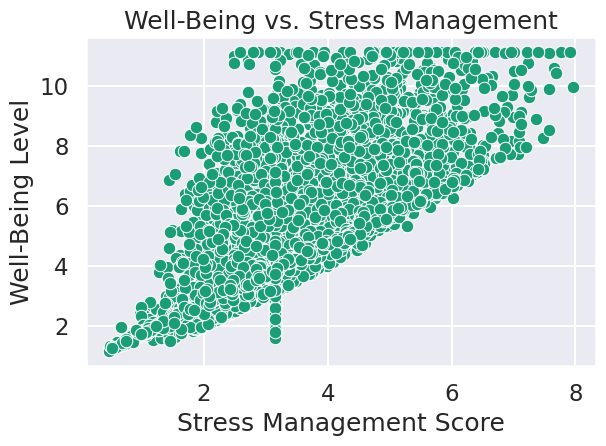

In [161]:
sns.scatterplot(data=data, x='stress_management_score', y='well_being_level')
plt.title("Well-Being vs. Stress Management")
plt.xlabel("Stress Management Score")
plt.ylabel("Well-Being Level")
plt.grid(True)
plt.tight_layout()
plt.show()

This was the strongest correlation in our dataset. The scatterplot shows a clear positive relationship: individuals with higher stress management scores consistently report higher well-being levels. This could be an insightfull analysis as governments or organizations can promote stress management courses or other alternatives

### Well-Being vs. Health Consciousness (0.67)

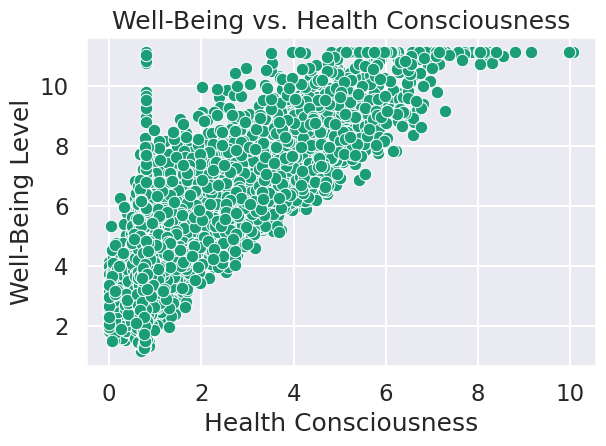

In [162]:
sns.scatterplot(data=data, x='health_consciousness_rating', y='well_being_level')
plt.title("Well-Being vs. Health Consciousness")
plt.xlabel("Health Consciousness")
plt.ylabel("Well-Being Level")
plt.grid(True)
plt.tight_layout()
plt.show()

Another strong trend. We can see that based on the data, health-conscious individuals tend to have higher well-being levels.

### Investments Risk Tolerance vs. Investments Risk Appetite (0.53)

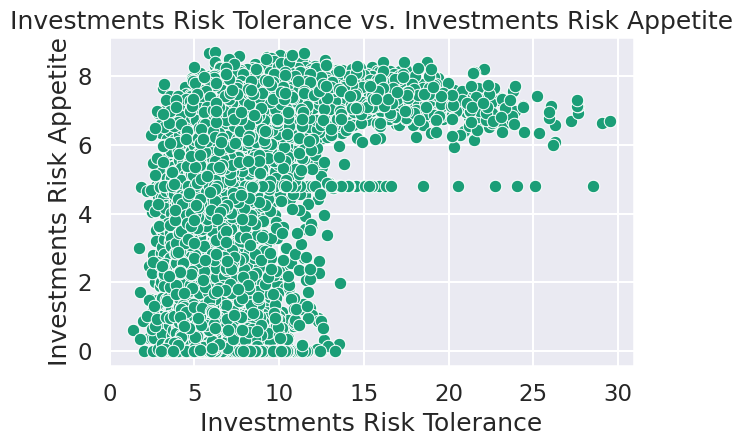

In [163]:
sns.scatterplot(data=data, x='investments_risk_tolerance', y='investments_risk_appetite')
plt.title("Investments Risk Tolerance vs. Investments Risk Appetite")
plt.xlabel("Investments Risk Tolerance")
plt.ylabel("Investments Risk Appetite")
plt.grid(True)
plt.tight_layout()
plt.show()

Although there is a general positive relationship between investments risk tolerance and risk appetite, the data reveals a plateau effect: after a tolerance threshold of approximately 10–15, increases in tolerance are not matched by corresponding increases in appetite. This can mean a behavioral limit, where individuals acknowledge high risk capacity but choose to be careful. This can be usefull for understanding financial decision-making in lifestyle segmentation, especially if we cluster citizens based on investment behavior

### Stress Management vs. Monthly Entertainment Expenses (0.47)

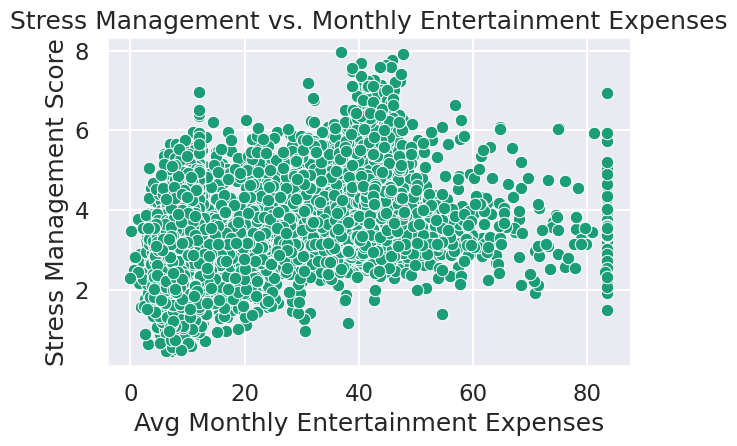

In [164]:
sns.scatterplot(data=data, x='avg_monthly_entertainment_expenses', y='stress_management_score')
plt.title("Stress Management vs. Monthly Entertainment Expenses")
plt.xlabel("Avg Monthly Entertainment Expenses")
plt.ylabel("Stress Management Score")
plt.grid(True)
plt.tight_layout()
plt.show()

The graph shows that people who spend more on fun activities (like movies, dining out, or hobbies) tend to handle stress better, but only up to a point. Stress levels drop as spending increases, with the best results around 60. Beyond that, extra spending doesn’t help much and could even cause money stress.

### Exercise vs. Stress Score

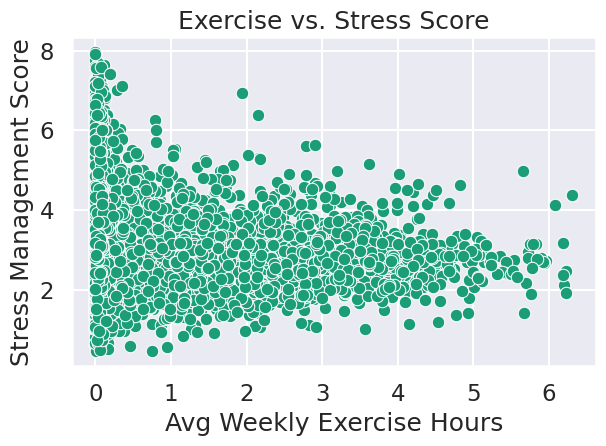

In [165]:
sns.scatterplot(data=data, x='avg_weekly_exercise_hours', y='stress_management_score')
plt.title("Exercise vs. Stress Score")
plt.xlabel("Avg Weekly Exercise Hours")
plt.ylabel("Stress Management Score")
plt.grid(True)
plt.tight_layout()
plt.show()



We can see that the scatterplot has a **clear negative correlation**, which means more weekly exercise hours are associated with lower stress scores.

### Financial wellness vs other metrics

We decided to explore how financial wellness levels impact other lifestyle metrics.

We started with creating **financial wellness bins** (Very Low to Very High) to group people by their financial situation. This helps simplify a continuous variable into categories and allows us to compare average values of other lifestyle metrics across these groups.

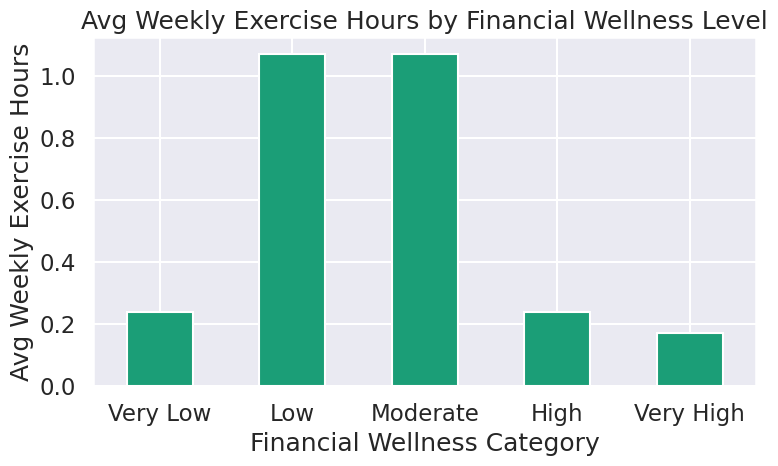

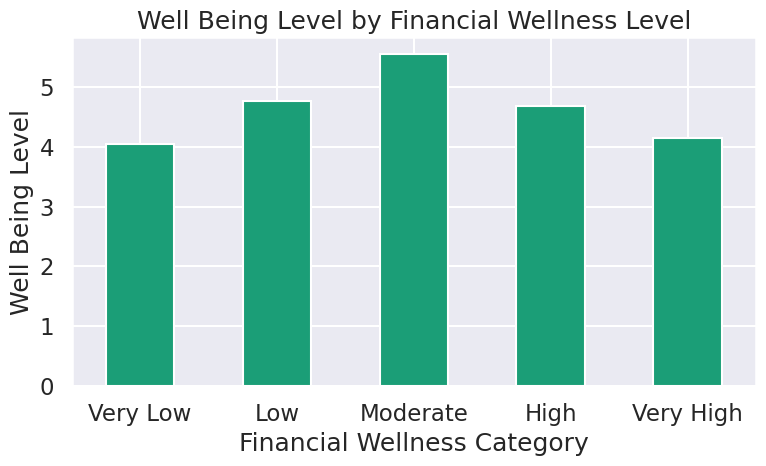

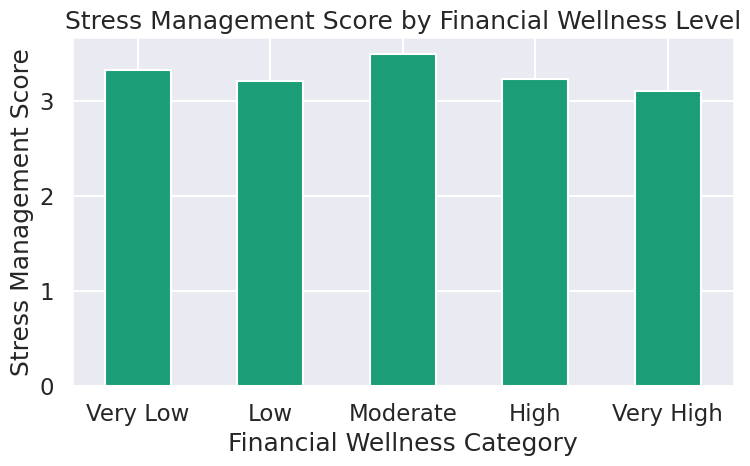

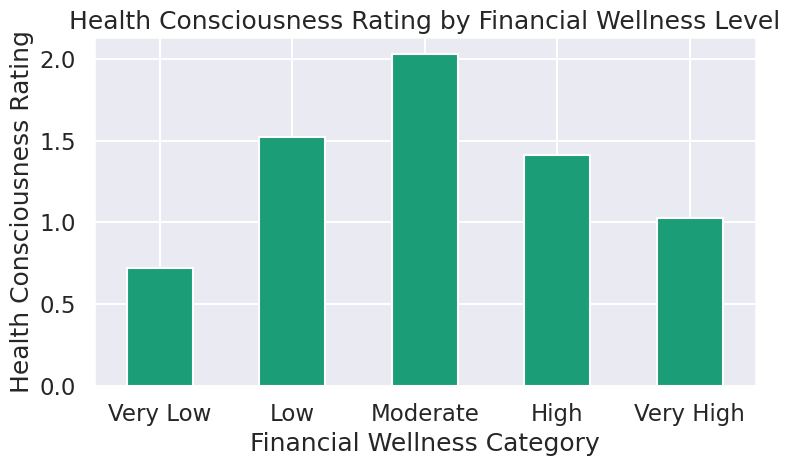

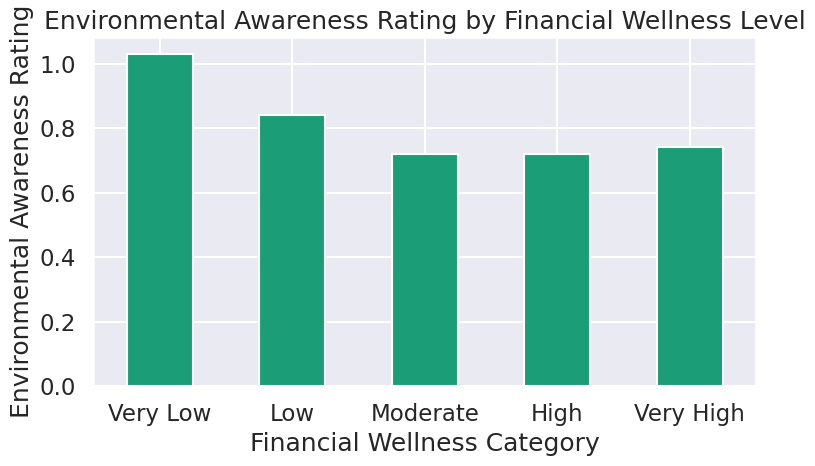

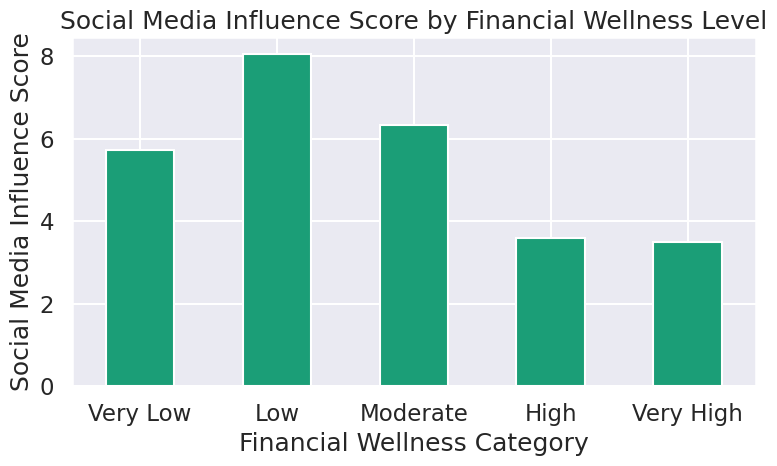

In [166]:
# Define bins for financial wellness
data['financial_bin'] = pd.cut(
    data['financial_wellness_index'],
    bins=[0, 75, 100, 125, 200, 500],
    labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']
)

# Metrics to analyze by financial_bin
compare_metrics = [
    'avg_weekly_exercise_hours',
    'well_being_level',
    'stress_management_score',
    'health_consciousness_rating',
    'environmental_awareness_rating',
    'social_media_influence_score'
]

# Group and calculate mean per bin
financial_groups = data.groupby('financial_bin')[compare_metrics].mean().round(2)

for metric in compare_metrics:
    plt.figure(figsize=(8, 5))
    financial_groups[metric].plot(kind='bar', title=f'{metric.replace("_", " ").title()} by Financial Wellness Level')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('Financial Wellness Category')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

From the results we can draw several conclusions related to the financial wellness of people.

1. **Avg Weekly Exercise Hours**

  People in the "Low" and "Moderate" financial wellness categories exercise more on average than those in both "Very Low" and "Very High".

  Suggests that the relationship between financial wellness and exercise is not linear, but instead people in the middle seem most active.

2. **Well-Being Level**

  Well-being peaks at “Moderate” financial wellness.

  Declines slightly in "High" and even more in "Very High".

  Possibly implies that having more money doesn’t necessarily equal more happiness.

3. **Stress Management Score**

  Highest in the “Moderate” group.

  Drops again at the “Very High” level, similar to the well-being trend.

  Indicates that stress management might worsen when financial pressure is too low or too high.

4. **Health Consciousness Rating**

  Also follows a bell curve: highest in “Moderate”, lower in both extremes.

  Those with extreme financial conditions (good or bad) may neglect health awareness, either from lack of access or shifting priorities.

5. **Environmental Awareness Rating**

  Interestingly, the “Very Low” group shows the highest environmental awareness.

  Suggests that people with fewer resources might be more eco-conscious, possibly due to frugality or higher exposure to sustainability issues.

6. **Social Media Influence Score**

  Peaks in the “Low” group.

  Decreases steadily with rising financial wellness.

  Might suggest that individuals with less financial stability rely more on social platforms for expression, influence, or side income.

### Lifestyle Averages by Education Category

By examining lifestyle-related metrics across different education levels, we uncover nuanced patterns that help us understand how education might shape well-being, health behaviors, financial attitudes, and environmental values. These insights are particularly useful for organizations like WHO-Life aiming to promote holistic well-being strategies tailored to socio-educational backgrounds.

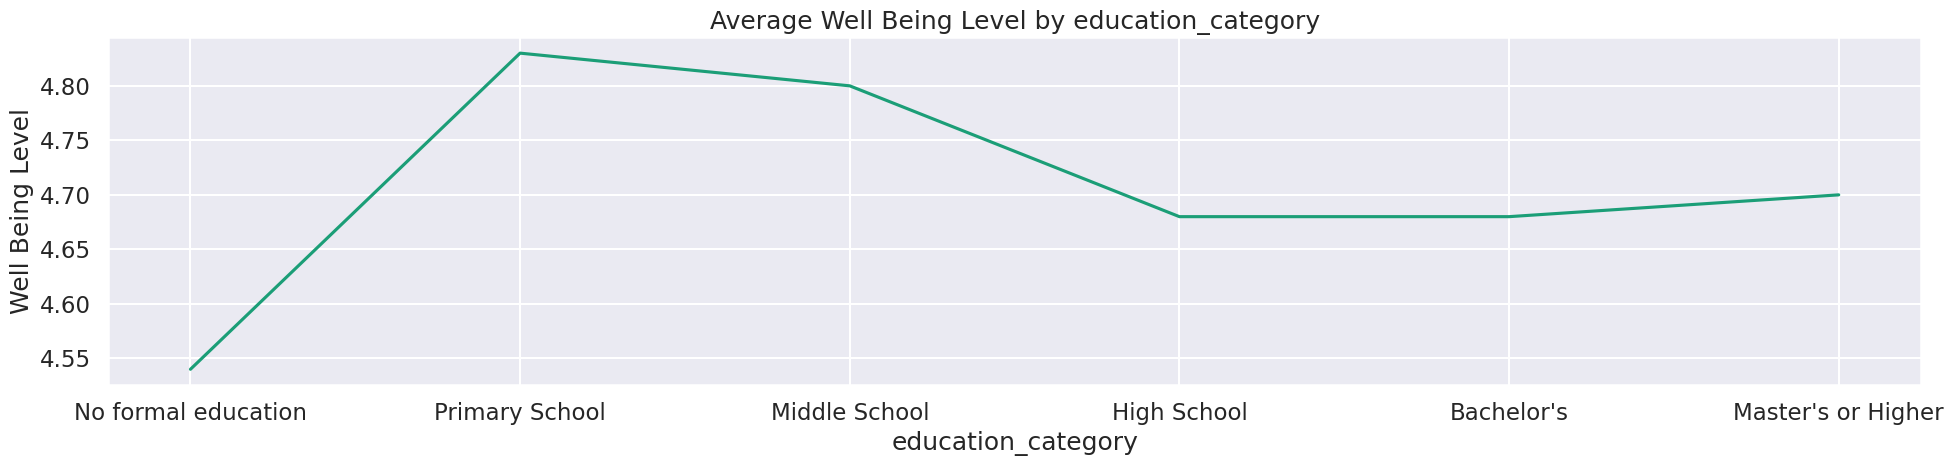

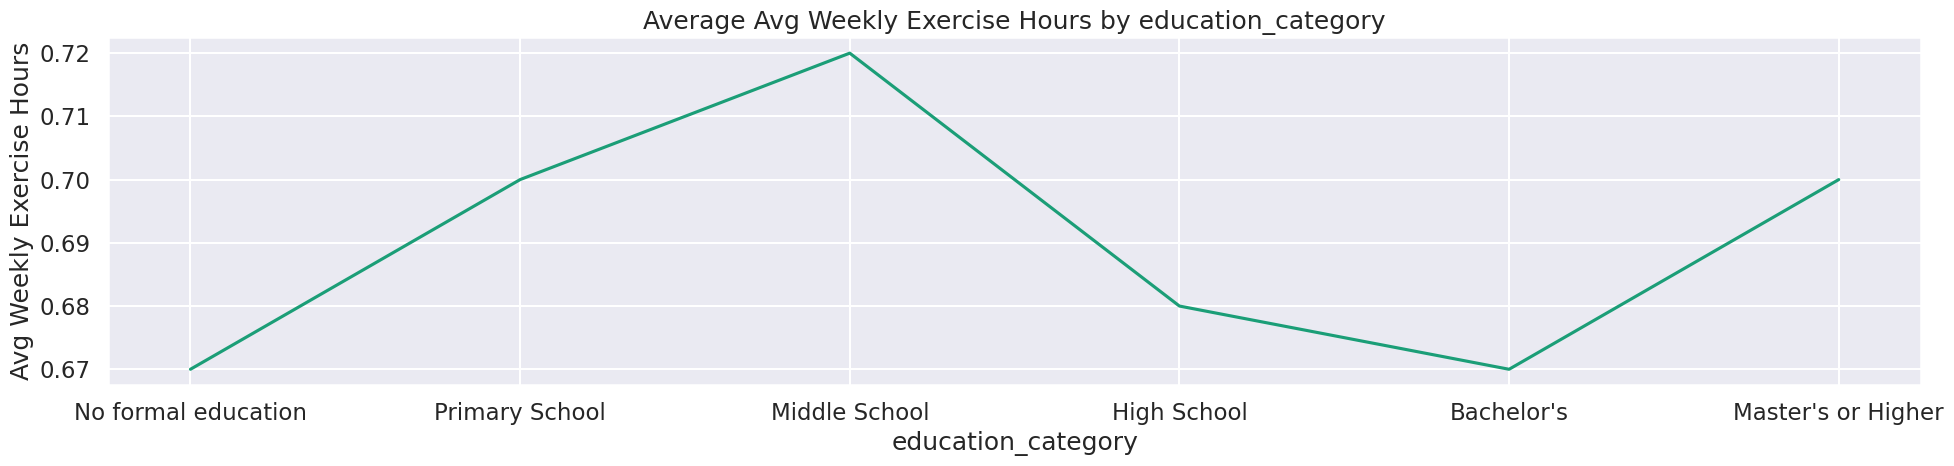

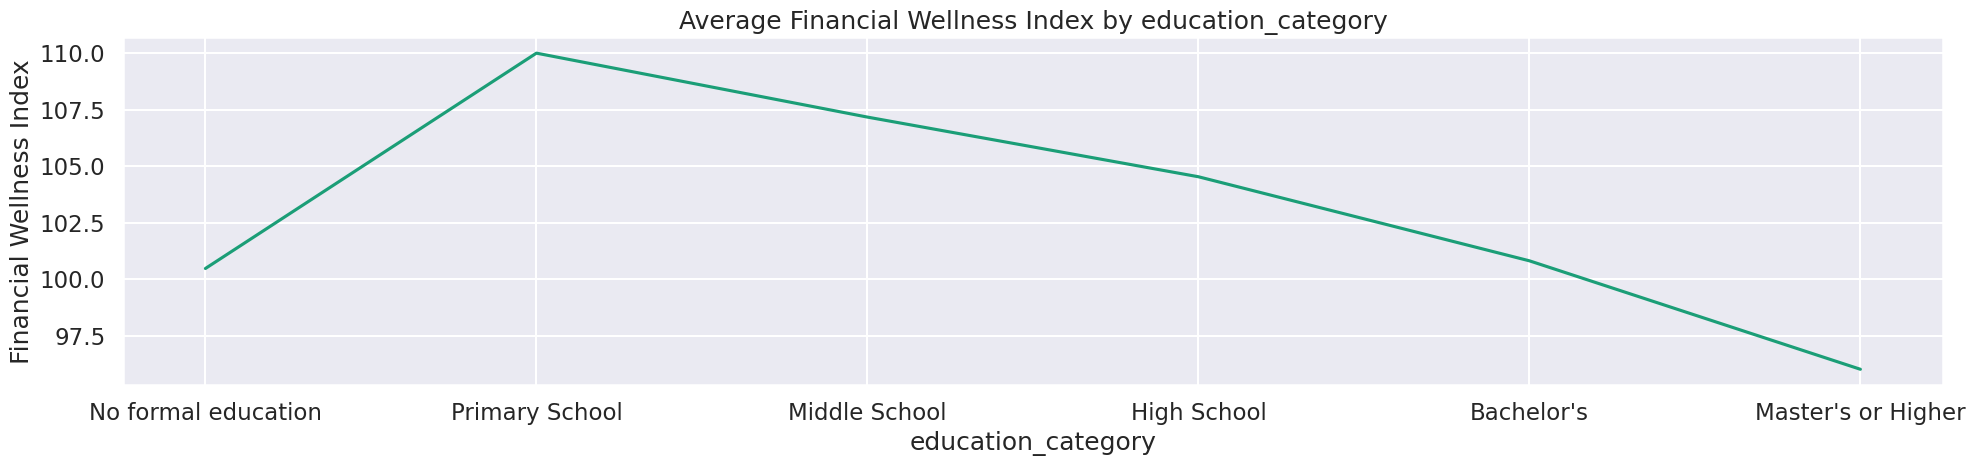

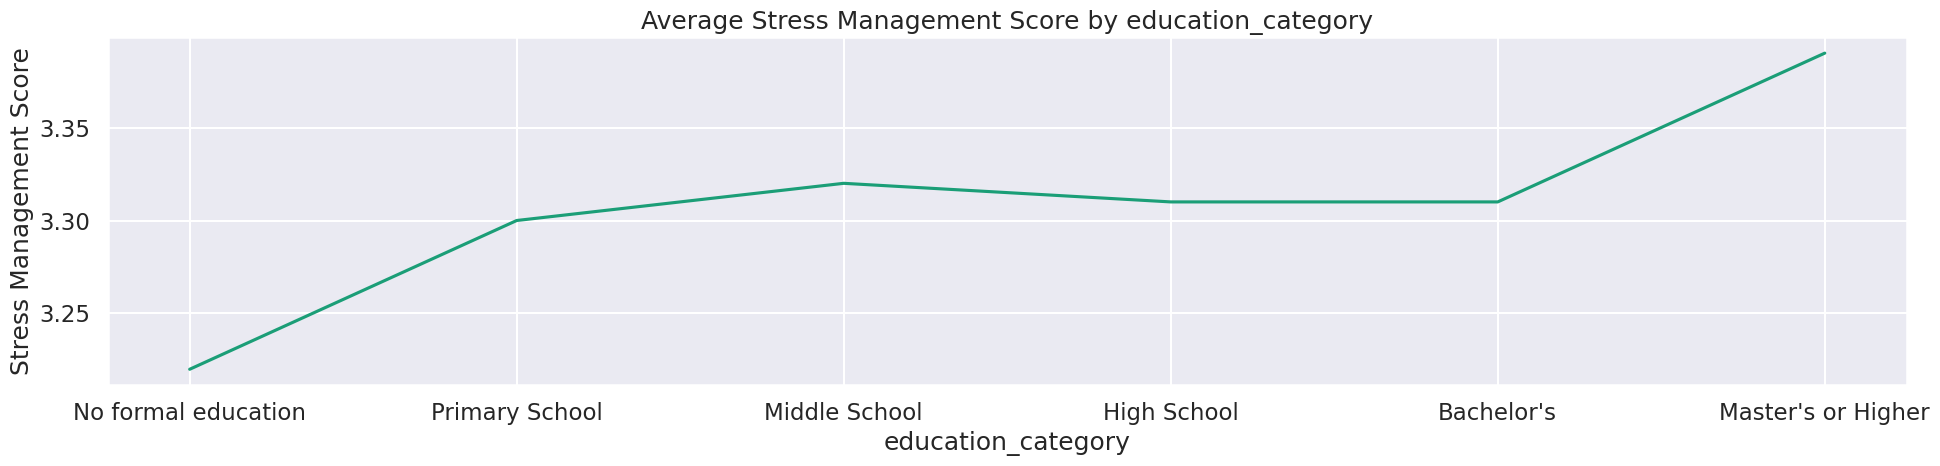

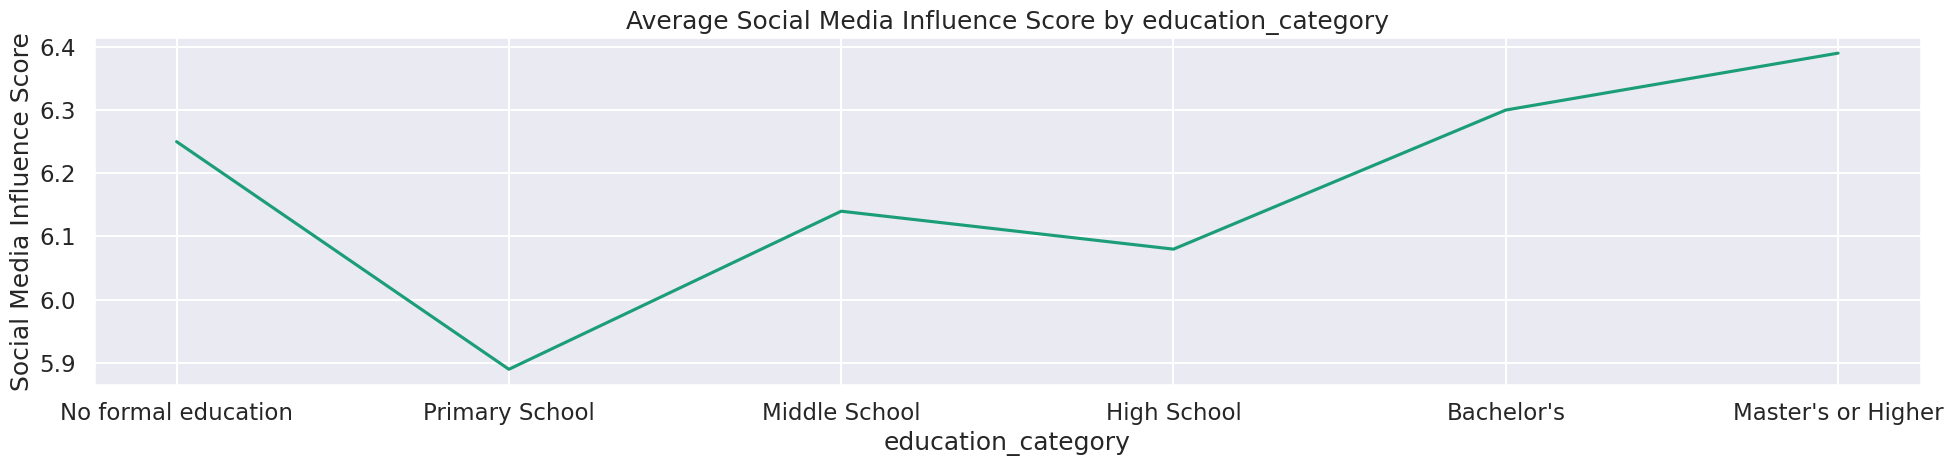

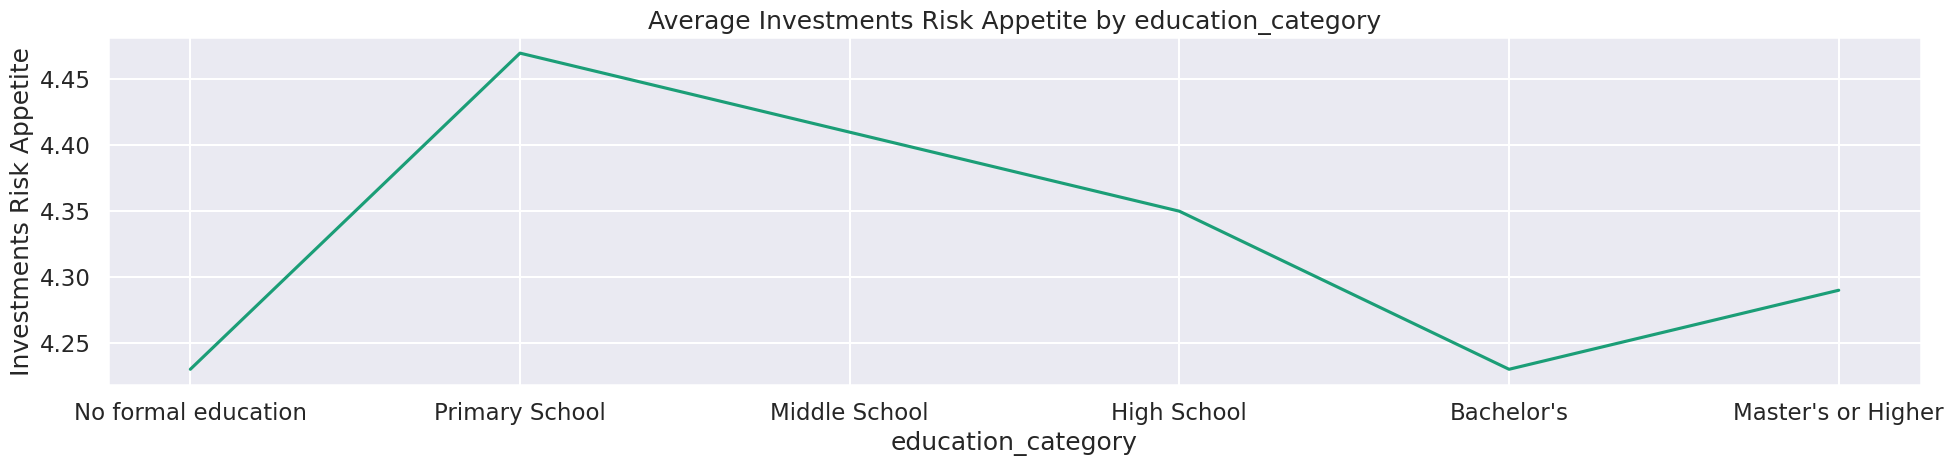

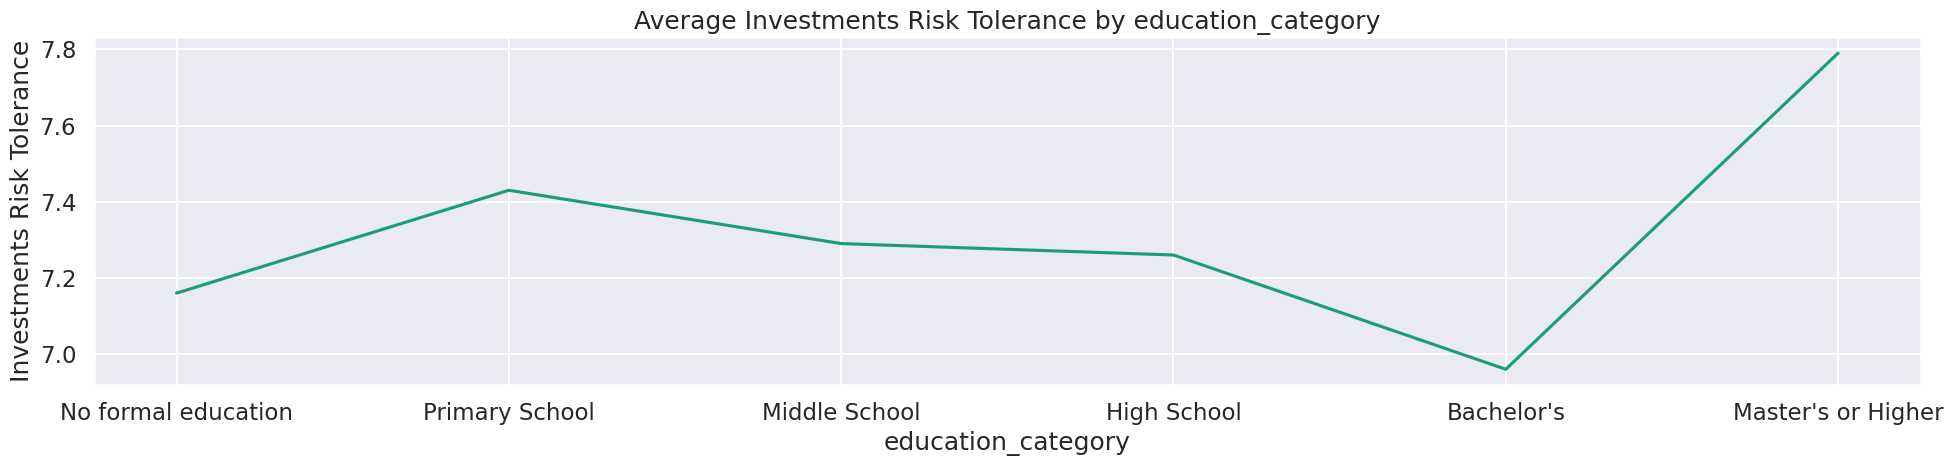

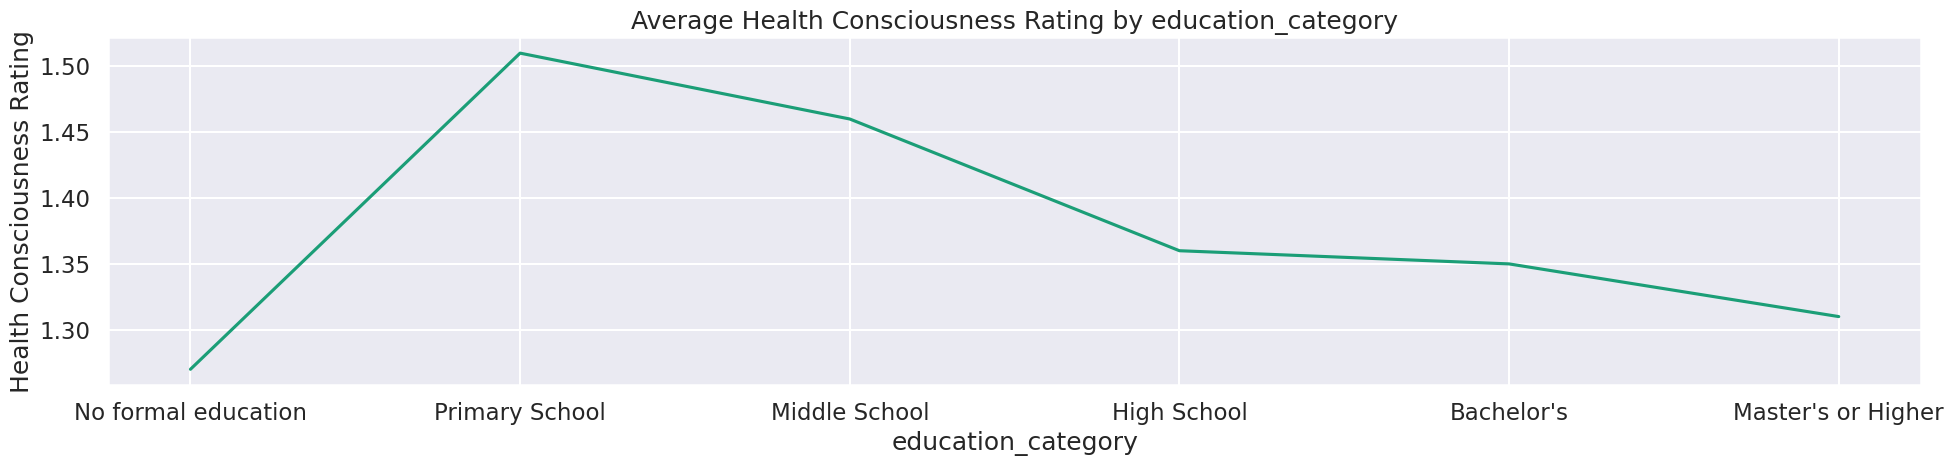

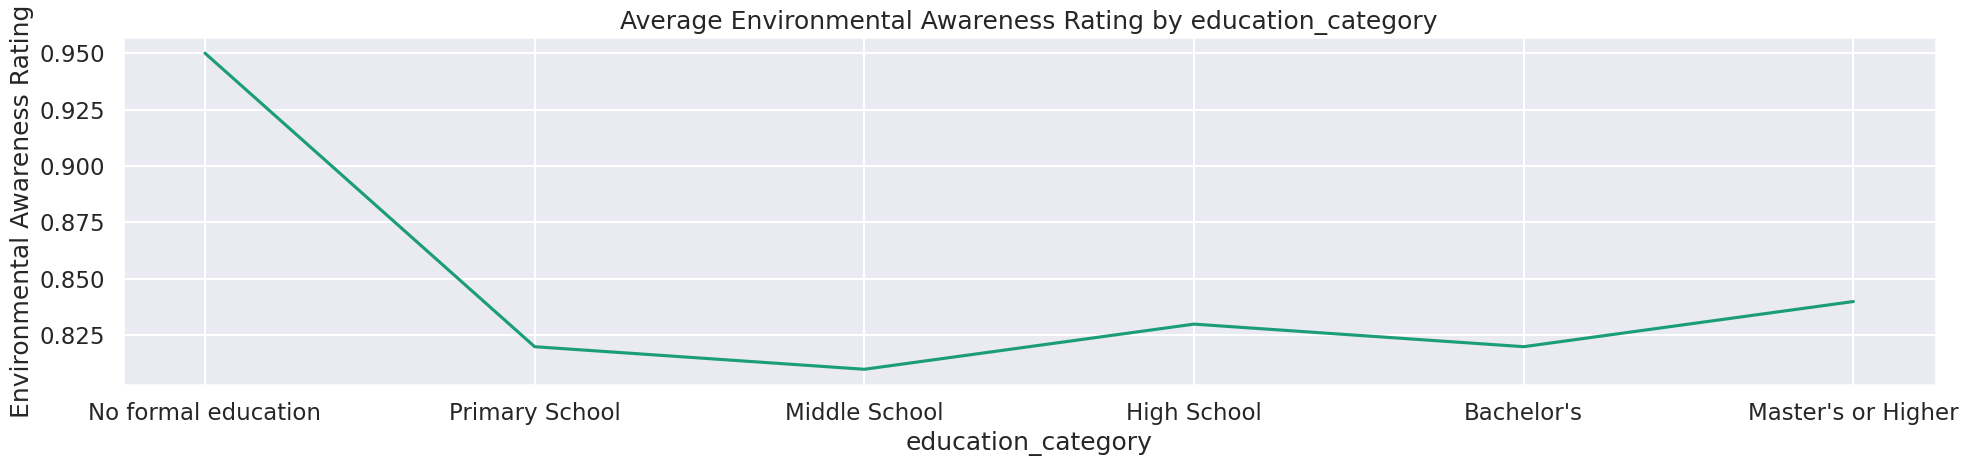

In [167]:
# Group by education_category
education_category_summary = data.groupby("education_category")[metrics].mean().round(2)

# Plot metrics
for metric in metrics:
    plt.figure(figsize=(20, 5))
    education_category_summary[metric].plot(kind='line', title=f'Average {metric.replace("_", " ").title()} by education_category')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('education_category')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

1. **Well-Being Level**

  Peaks at Primary School and Middle School levels, then slightly declines for High School, Bachelor’s, and Master’s or Higher.

  Suggests that higher education doesn’t necessarily correlate with increased subjective well-being. Simpler lifestyles or community ties at moderate education levels might play a positive role in happiness.

2. **Average Weekly Exercise Hours**

  Follows a bell-shaped trend: highest among those with Middle School education.

  Slightly lower at both ends. No formal education and Bachelor’s degree holders exercise the least.

  Implies that moderate education levels may correspond to healthier, more active lifestyles, while those in higher education might struggle with sedentary work or time constraints.

3. **Financial Wellness Index**

  Peaks at the Primary School level, then gradually declines with higher education.

  Could reflect either reduced financial pressure in lower-income, low-cost-living settings or possible dissatisfaction at higher income levels with rising expenses or expectations.

4. **Stress Management Score**

  Gradually increases with education, reaching the highest level at Master’s or Higher.

  Indicates that more education may equip individuals with better emotional regulation and stress-coping skills—possibly due to greater exposure to health and psychology knowledge.

5. **Social Media Influence Score**

  Rises steadily with education level, highest among Master’s or Higher.

  Suggests educated individuals may be more engaged in digital networks, possibly for professional branding, networking, or advocacy.

6. **Investments Risk Appetite**

  Peaks at Primary School level and then decreases across education levels.

  Indicates that less educated individuals might be more open to financial risk—possibly due to lack of awareness, or a “nothing to lose” mentality, while more educated individuals may adopt more conservative investment strategies.

7. **Investment Risk Tolerance**

  Highest for those with Master’s or Higher education.

  Demonstrates a contrast with risk appetite: while more educated individuals may not want risk, they’re able to handle it more confidently—possibly due to better financial literacy and planning tools.

8. **Health Consciousness Rating**

  Also peaks at Primary School, then steadily declines.

  Unexpected trend—could suggest that health messaging is more culturally or practically integrated in early education or that those with higher education may deprioritize health due to work or stress.

9. **Environmental Awareness Rating**

  Highest among those with No formal education, dips in the middle levels, and slightly recovers at the top.

  May indicate a stronger reliance on natural resources or sustainable habits among less-educated populations, while educated groups might be environmentally aware in principle, but less in practice.

## New data

We decided to add data about **Population** and **GDP Per Capita** for every country to further enhance our insights on different lifestyle patterns.

### Number of people per Country in thousands (World Bank)

In [168]:
# Load and prepare population data
population = pd.read_csv(path + "Data/total_population.csv")
population = population[['Country Name', '2023']]
population.columns = ['country', 'population']

# Merge into main dataframe
data = data.merge(population, on='country', how='left')

# Check result
print(data[['country', 'population']].head())

       country   population
0       Brazil  211140729.0
1  New Zealand    5223100.0
2      Germany   83280000.0
3      Germany   83280000.0
4       Turkey   85325965.0


In [169]:
# Load GDP CSV (adjust filename if needed)
gdp = pd.read_csv(path + "Data/gdp_per_capita.csv")

# Keep only relevant columns and rename them
gdp = gdp[['Country Name', '2023']]
gdp.columns = ['country', 'gdp_per_capita']

# Merge with our main data
data = data.merge(gdp, on='country', how='left')

# Check the result
print(data[['country', 'gdp_per_capita']].head())

       country  gdp_per_capita
0       Brazil        10294.87
1  New Zealand        48280.81
2      Germany        54343.23
3      Germany        54343.23
4       Turkey        13105.66


We decided to explore the relationship between GDP per capita and population with average monthly entertainment expenses. We visualize these insights with the following plots:


First, we create a summary table (`country_comparison`) that contains the average entertainment spending along with GDP per capita and population for each country:

In [170]:
country_comparison = data.groupby('country').agg({
    'avg_monthly_entertainment_expenses': 'mean',
    'gdp_per_capita': 'first',
    'population': 'first'  # use first since population is fixed per country
}).dropna().sort_values(by='gdp_per_capita')

1. **Bubble Chart: Entertainment Spending vs GDP per Capita**

We created a bubble chart that plots countries based on their average **monthly entertainment expenses** (y-axis) and **GDP per capita** (x-axis). Each bubble's size reflects the **country's population**, allowing us to simultaneously visualize three variables.**bold text**

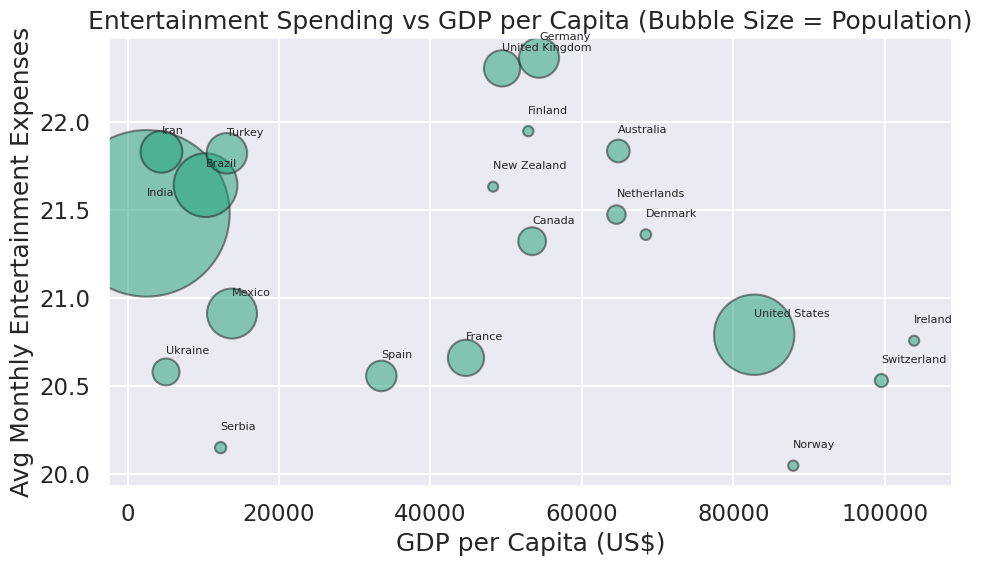

In [171]:
# Bubble Chart
plt.figure(figsize=(10, 6))
plt.scatter(
    data=country_comparison,
    x='gdp_per_capita',
    y='avg_monthly_entertainment_expenses',
    s=country_comparison['population'] / 100000,  # scale for better visuals
    alpha=0.5,
    edgecolor='k'
)
for country, row in country_comparison.iterrows():
    plt.text(row['gdp_per_capita'], row['avg_monthly_entertainment_expenses'] + 0.1, country, fontsize=8)

plt.title("Entertainment Spending vs GDP per Capita (Bubble Size = Population)")
plt.xlabel("GDP per Capita (US$)")
plt.ylabel("Avg Monthly Entertainment Expenses")
plt.grid(True)
plt.tight_layout()
plt.show()

From this chart we can conclude:

* High-income countries such as **Germany**, the **United Kingdom**, and **Finland** tend to have higher entertainment spending, which aligns with expectations based on disposable income levels.

* **India** has the lowest GDP per capita among the countries but one of the largest populations, resulting in a significant visual presence despite modest entertainment spending.

* The **United States**, while having a very high GDP per capita, shows moderate entertainment spending, possibly due to broader economic diversity and spending preferences within the country.

2. **Top 10 Countries by Population**

This horizontal bar chart highlights the top 10 countries by population within our dataset.

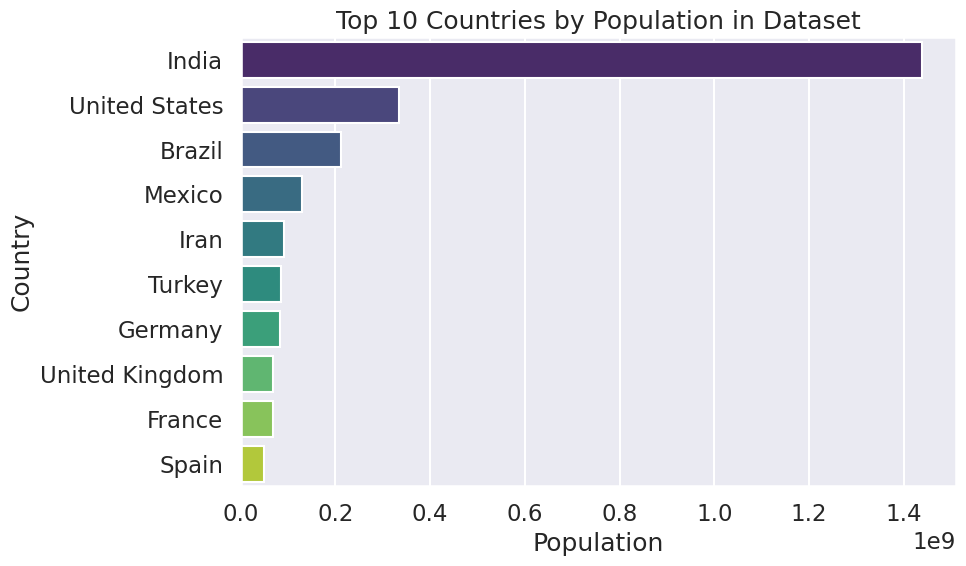

In [172]:
# Top 10 by Population
top_population = country_comparison.sort_values('population', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_population, x='population', y=top_population.index, palette='viridis')
plt.title("Top 10 Countries by Population in Dataset")
plt.xlabel("Population")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

* **India** is by far the most populous country in our data, followed by the United States and Brazil.

* These countries naturally carry more weight in aggregate statistics, which is important to keep in mind when interpreting global averages or trends.

3. **Top 10 Countries by Entertainment Spending Per 1,000 People**

This chart normalizes entertainment spending by population, showing the top 10 countries by entertainment spending per 1,000 people.

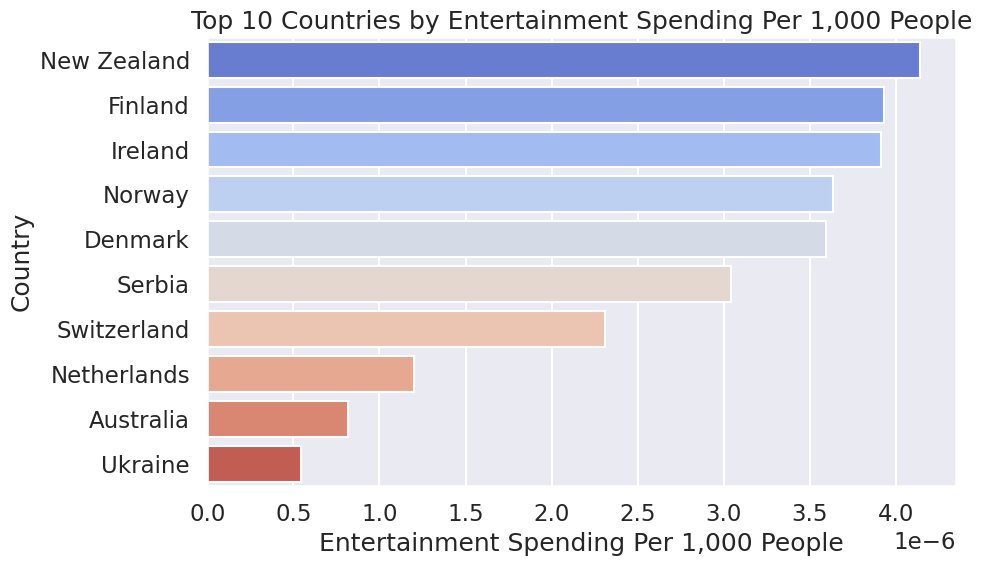

In [173]:
# Spending per 1,000 People
country_comparison['entertainment_per_1000_people'] = country_comparison['avg_monthly_entertainment_expenses'] / (country_comparison['population'])

top_per_capita = country_comparison.sort_values('entertainment_per_1000_people', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_per_capita, x='entertainment_per_1000_people', y=top_per_capita.index, palette='coolwarm')
plt.title("Top 10 Countries by Entertainment Spending Per 1,000 People")
plt.xlabel("Entertainment Spending Per 1,000 People")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

* **New Zealan**d, **Finland**, and **Ireland** top the list, suggesting a higher per-capita focus on leisure and entertainment, despite having smaller overall populations.

* **Norway** and **Switzerland**, with their strong economies and high living standards, also appear among the leaders.

* **Serbia** is a surprising inclusion, possibly indicating localized cultural preferences or cost-of-living factors that make entertainment more accessible.

### GDP per Capita (World Bank)

4. **Scatter Plot: GDP per Capita vs Entertainment Spending**

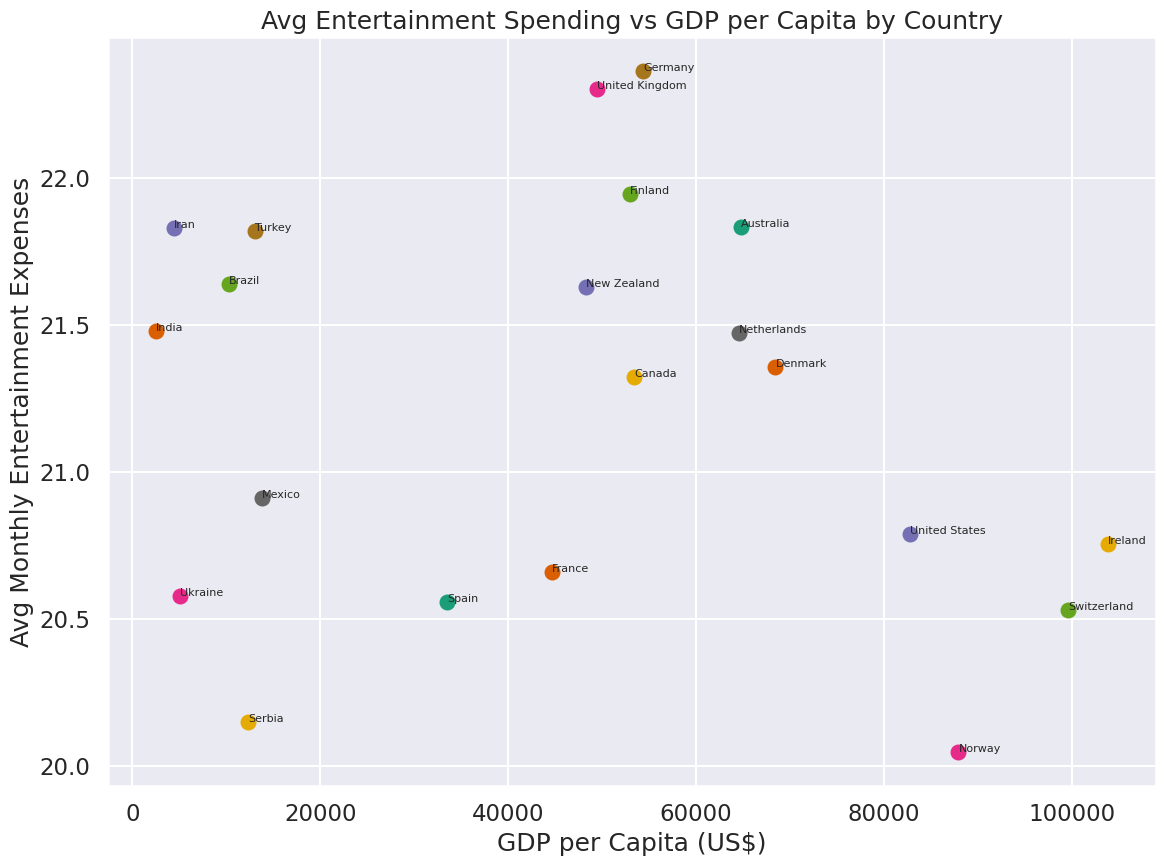

In [174]:
# Group by country: calculate mean entertainment spending and fixed GDP per capita
country_comparison = data.groupby('country').agg({
    'avg_monthly_entertainment_expenses': 'mean',
    'gdp_per_capita': 'first'  # assumes GDP is the same per country
}).sort_values(by='gdp_per_capita')

# Plot
plt.figure(figsize=(12, 9))
sns.scatterplot(
    data=country_comparison,
    x='gdp_per_capita',
    y='avg_monthly_entertainment_expenses',
    hue=country_comparison.index,
    palette='tab20',
    legend=False
)

# Annotate country names on points
for i, row in country_comparison.iterrows():
    plt.annotate(i, (row['gdp_per_capita'], row['avg_monthly_entertainment_expenses']), fontsize=8)
    plt.scatter(row['gdp_per_capita'], row['avg_monthly_entertainment_expenses'], s=100)

plt.title("Avg Entertainment Spending vs GDP per Capita by Country")
plt.xlabel("GDP per Capita (US$)")
plt.ylabel("Avg Monthly Entertainment Expenses")
plt.grid(True)
plt.tight_layout()
plt.show()


* **Germany**, **UK**, and **Finland** show relatively high entertainment spending for their GDP levels.

* On the other hand, **Norway** and **Switzerland** spend notably less than expected given their wealth.

* **Serbia** and **Ukraine** exhibit low GDP and low spending, following expected patterns. and Ukraine exhibit low GDP and low spending, following expected patterns.

**Conclusion**:

From analysing the data we can conlcude that there is **no linear correlation** between GDP per capita and entertainment spending. Countries with higher GDP per capita generally have more resources, they don't always spend more on entertainment. On the other hand countries like India and Brazil, despite economic challenges, still show moderate to high levels of lifestyle spending. This indicates that lifestyle behaviors are deeply cultural, not just financial.

Smaller nations like Finland, New Zealand, and Ireland top the charts in entertainment spending per 1,000 people. These countries may prioritize mental health, work-life balance, and community life.

Based on these findings we would suggest that the WHO:

* Profile and study high-performing small nations as models for lifestyle success and share best practices on how these countries promote active, balanced lifestyles.

* Promote community-driven, low-cost lifestyle programs that align with cultural habits.

* Investigate cultural or psychological barriers to lifestyle-enhancing behaviors in high-income countries.

* Promote policies that encourage the use of disposable income for well-being.

# Descriptive Modeling

Now we are moving in the culstering the data.

The goal of descriptive modeling here was to segment citizens into lifestyle-based clusters, using unsupervised learning methods. This helps us discover natural groupings and understand behavioral profiles without any pre-defined labels.
We split this part into 3 profiles based on different perspectives, one based on health related columns, another based on financial based columns and a third one with a mixture of different areas.

## Profile 1- Health profile

For the health profile we chose the following columns.

In [175]:
health_features = ['environmental_awareness_rating_scaled', 'health_consciousness_rating_scaled', 'avg_weekly_exercise_hours_scaled', 'stress_management_score', 'well_being_level']

In [176]:
#import and use minmax scaler in every column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[health_features] = scaler.fit_transform(data[health_features])

Min-max scaling ensures all values are between 0 and 1.

### Setting k

Now, we are going to train KMeans for `k = 1` to `12` and plot inertia (sum of squared distances to cluster centers).

100%|██████████| 12/12 [00:00<00:00, 50.31it/s]


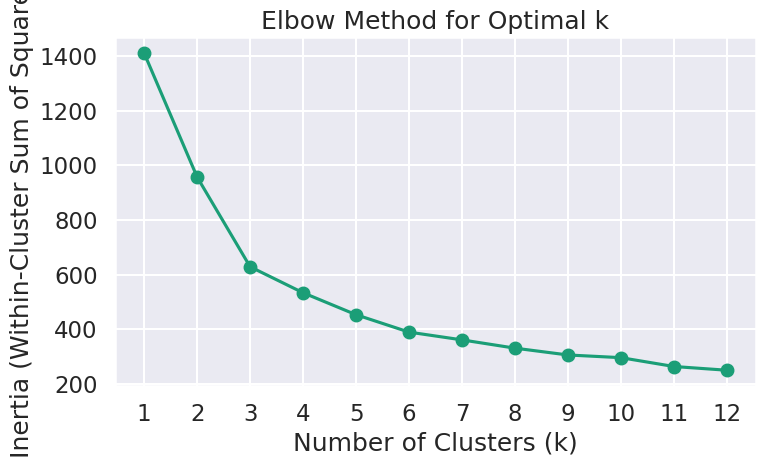

In [177]:
ks = range(1, 13)
inertias = []

for k in tqdm(ks):
    model = KMeans(n_clusters=k, random_state=50)
    model.fit(data[health_features])
    inertias.append(model.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(ks)
plt.grid(True)
plt.tight_layout()
plt.show()

The "elbow" (point where inertia drop slows down) is at `k = 3`.

We are going to use Ward’s method to build a dendrogram to double-check clustering structure and validate `k` visually (dendrograms reveal natural splits in data).

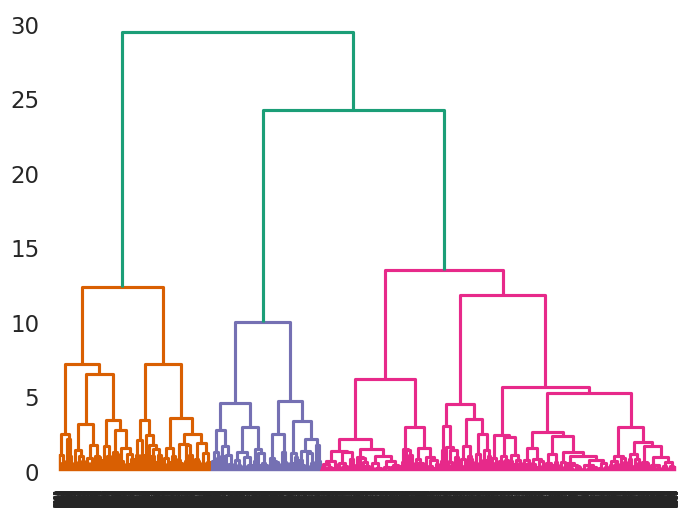

In [178]:
clusters = hierarchy.linkage(data[health_features], method="ward")

plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

This method also pointed us in the direction of k=3

To add quantitative validation to the elbow method, we are running a silhouette analysis to measure how well points fit within their clusters. Higher silhouette = cleaner clusters.

100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


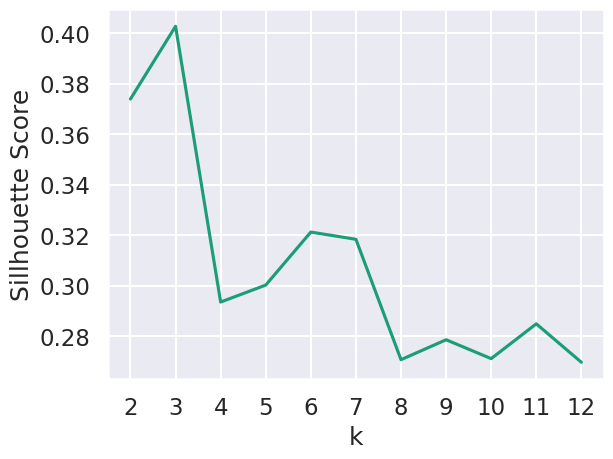

In [179]:
ks = range(2, 13)
sil_score = []

for k in tqdm(ks):
    model = KMeans(n_clusters=k, random_state=50)

    model.fit_predict(data[health_features])

    sil_score.append(silhouette_score(data[health_features], model.labels_, metric='euclidean'))


plt.plot(ks, sil_score)

plt.xlabel('k')
plt.ylabel('Sillhouette Score')
plt.xticks(ks)
plt.show()

The silhouette score peaked around  `k = 3`, further supporting our choice from the elbow method for optimal k.

In [180]:
k = 3
kmeans_1 = KMeans(n_clusters = k).fit(data[health_features])
data['health_cluster'] = kmeans_1.predict(data[health_features])

Based on the our analysis, we settled on `k = 3` (3 health based clusters).

### Exploring and Visualizing Results

After clustering individuals based on their health related features, this phase is about interpreting what those clusters mean.

We're basically answering the question:
**“What characterizes each health cluster?”**

Using the `cluster_profiles()` function, we are going to summarize each cluster's average values across selected features and their relative sizes.

  Two main plots are generated:

  **Parallel Coordinates Plot**:
  
  Shows average values of each feature across clusters. Useful to compare how different lifestyle clusters behave on each metric.

  **Bar Plot of Cluster Sizes**:
  
  Gives a quick view of how many individuals fall into each cluster.

In [181]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)

    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)

        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        color = sns.color_palette('Dark2')

        pd.plotting.parallel_coordinates(centroids, label, color=color, ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1], palette = color)

        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=16, fontweight = 'heavy')
        ax[0].legend(handles, cluster_labels)
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=16)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=16)


    plt.subplots_adjust(hspace=0.4, top=0.90, bottom = 0.2)
    plt.suptitle("Cluster Profiling", fontsize=23)
    plt.show()

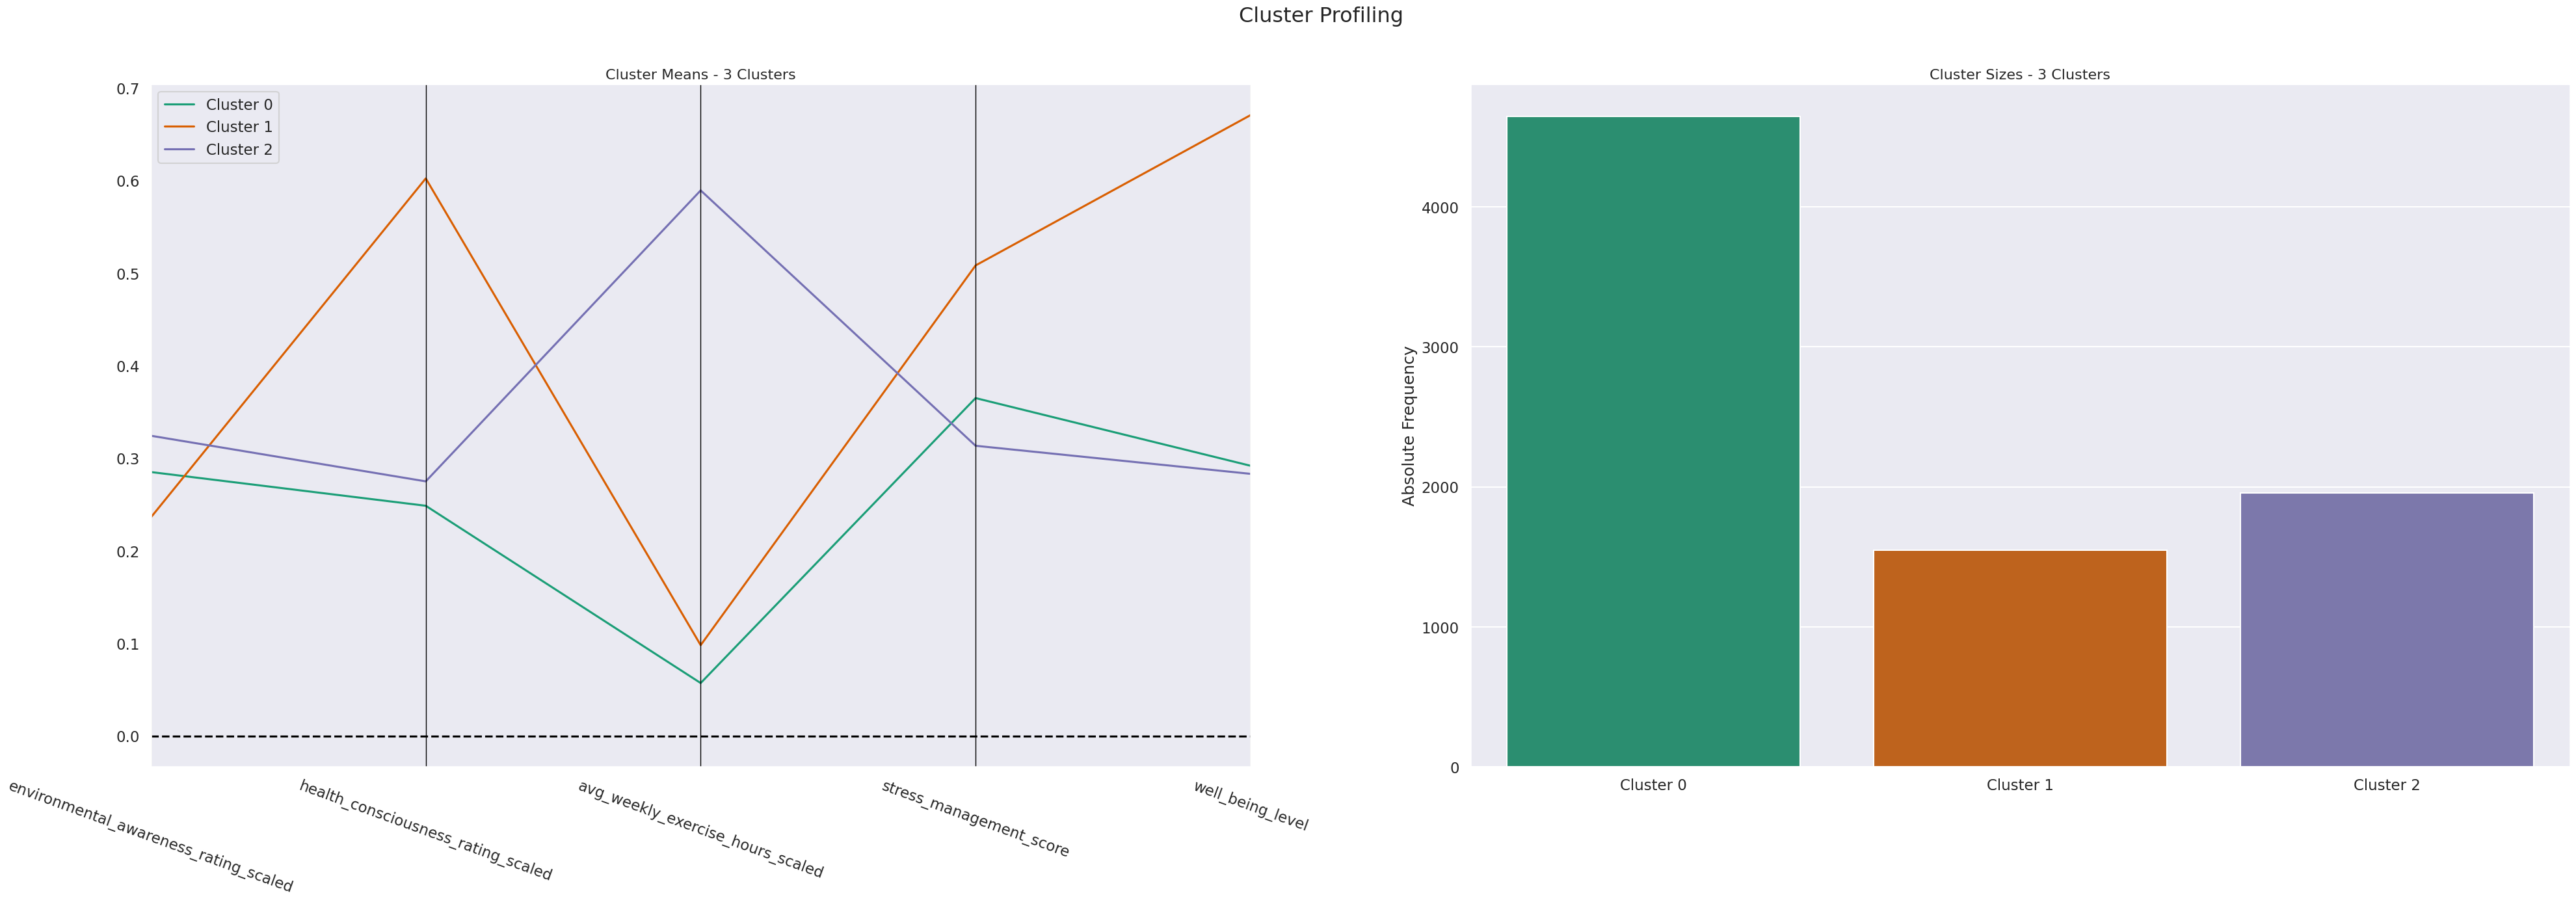

In [182]:
cluster_profiles(data[health_features].join(data['health_cluster']),["health_cluster"],figsize=(48, 15))

**Cluster 0**:

  * Highest well-being scores, stress management, and exercise frequency.

  * Above-average scores in health consciousness and environmental awareness.

  * Engages in a moderate amount of entertainment spending and has a balanced digital influence.

This group represents an ideal lifestyle model with holistic health practices: active, mentally balanced, and environmentally conscious.

**Cluster 1**:

  * High in social media influence and entertainment expenses.

  * Lowest in weekly exercise, stress management, and well-being.

  * Health consciousness and environmental awareness also lag behind.

This group might prioritize digital and consumer lifestyles over physical and mental wellness. Potential risk for burnout or lifestyle-related health issues.

**Cluster 2**:

  * Moderate across most features, but stands out with higher exercise levels and moderate to high well-being.

  * Lower on digital/social influence and entertainment spending.

  * Decent scores in health and stress management.

This cluster resembles people who live healthy but more private or low-profile lifestyles. They’re not highly visible online but focus on personal wellness quietly.

  0%|          | 0/5 [00:00<?, ?it/s]

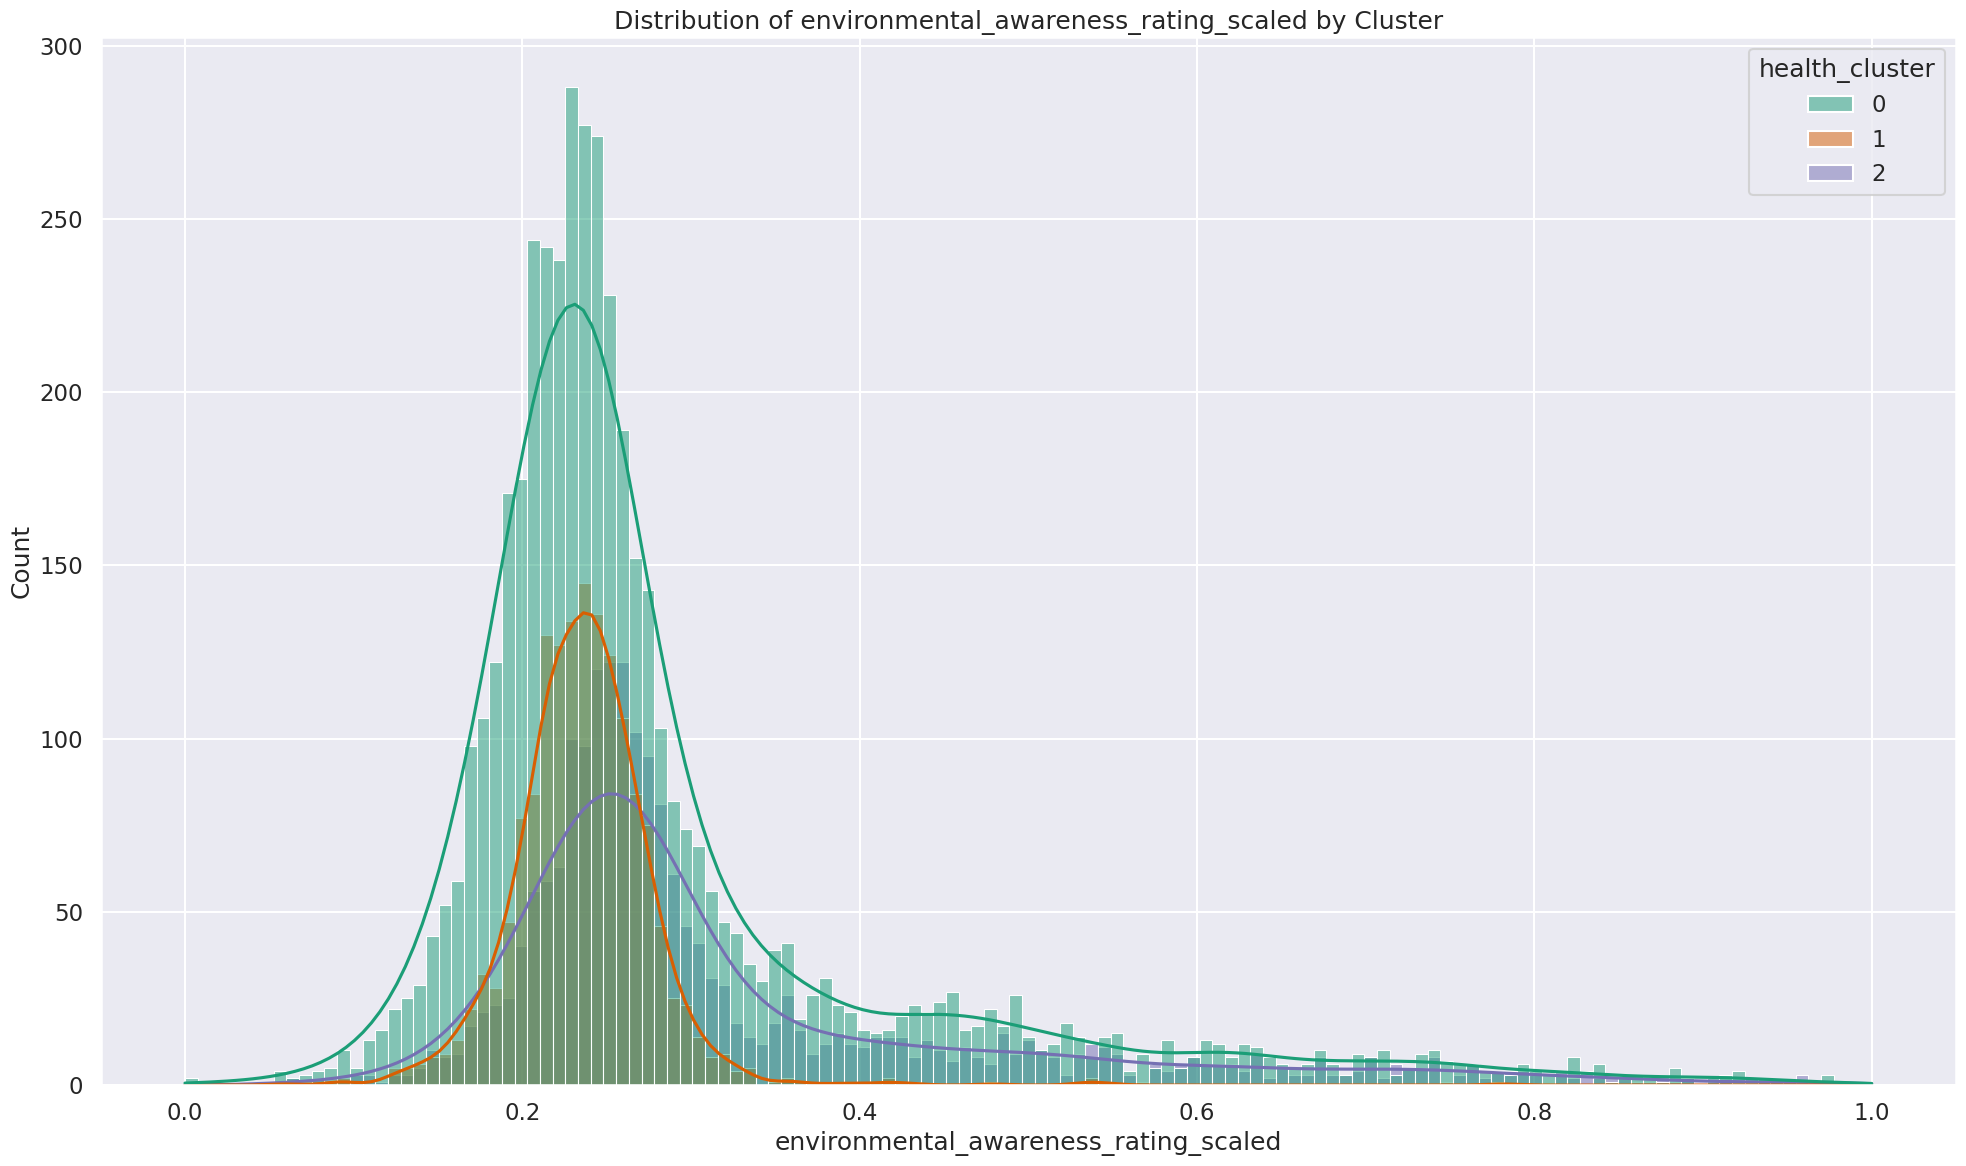

 20%|██        | 1/5 [00:01<00:04,  1.01s/it]

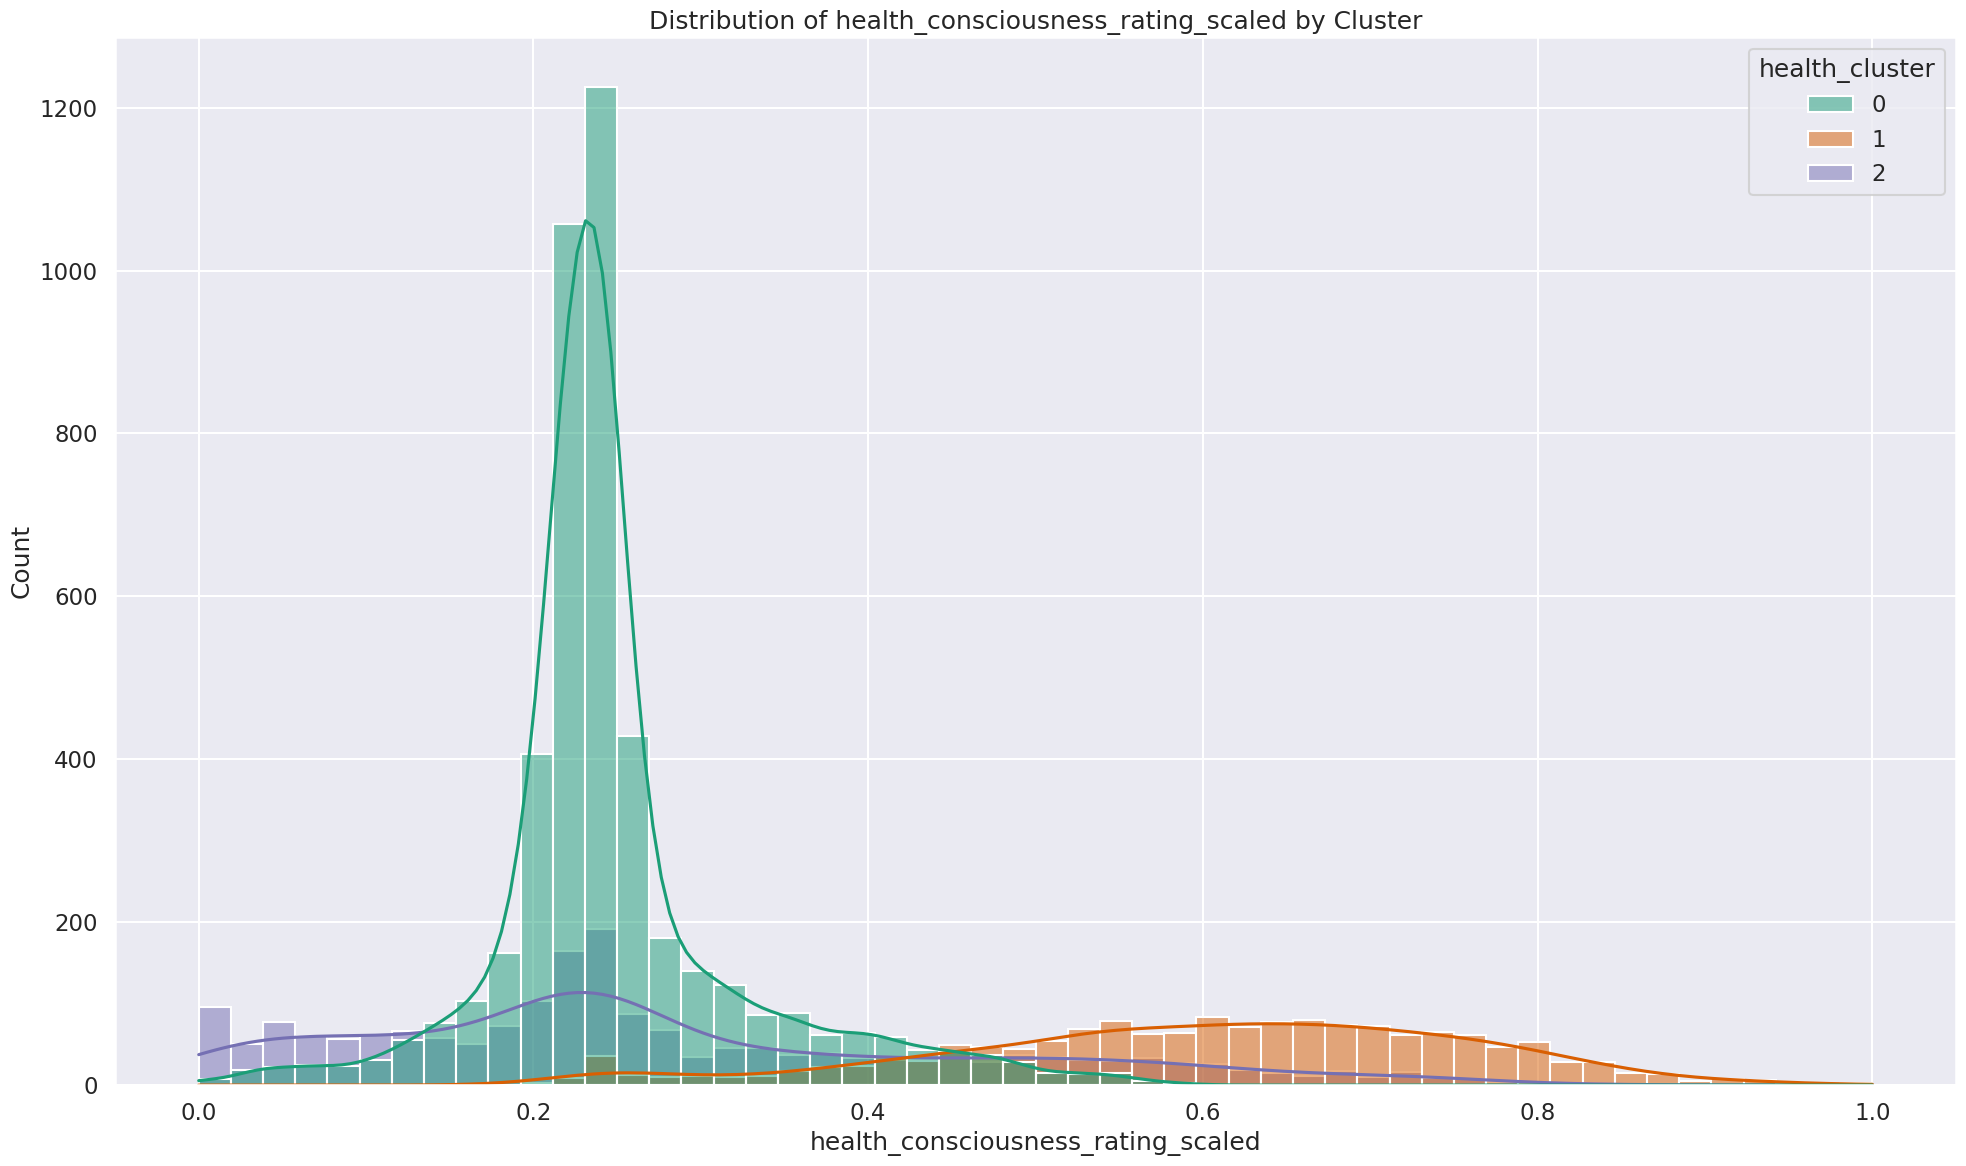

 40%|████      | 2/5 [00:01<00:02,  1.25it/s]

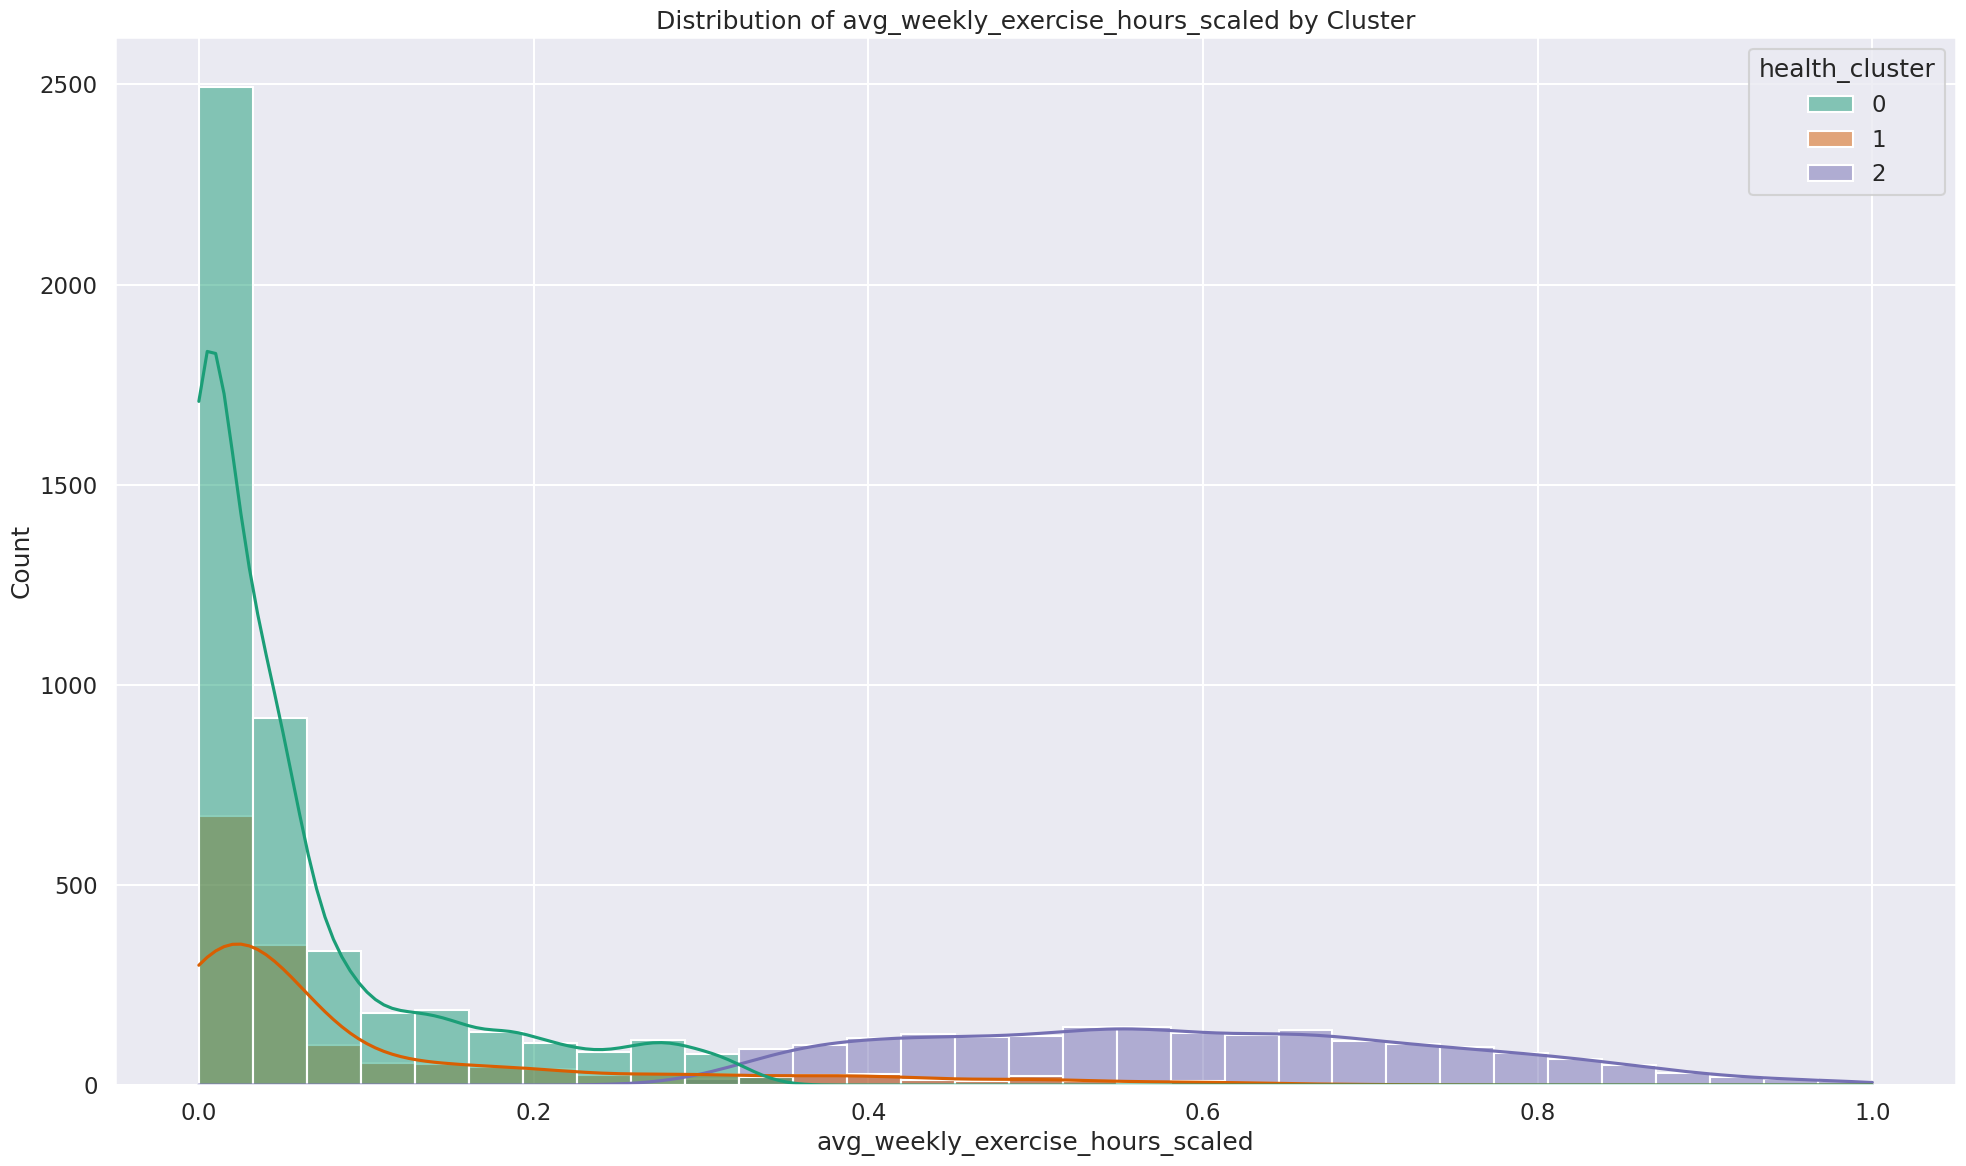

 60%|██████    | 3/5 [00:02<00:01,  1.45it/s]

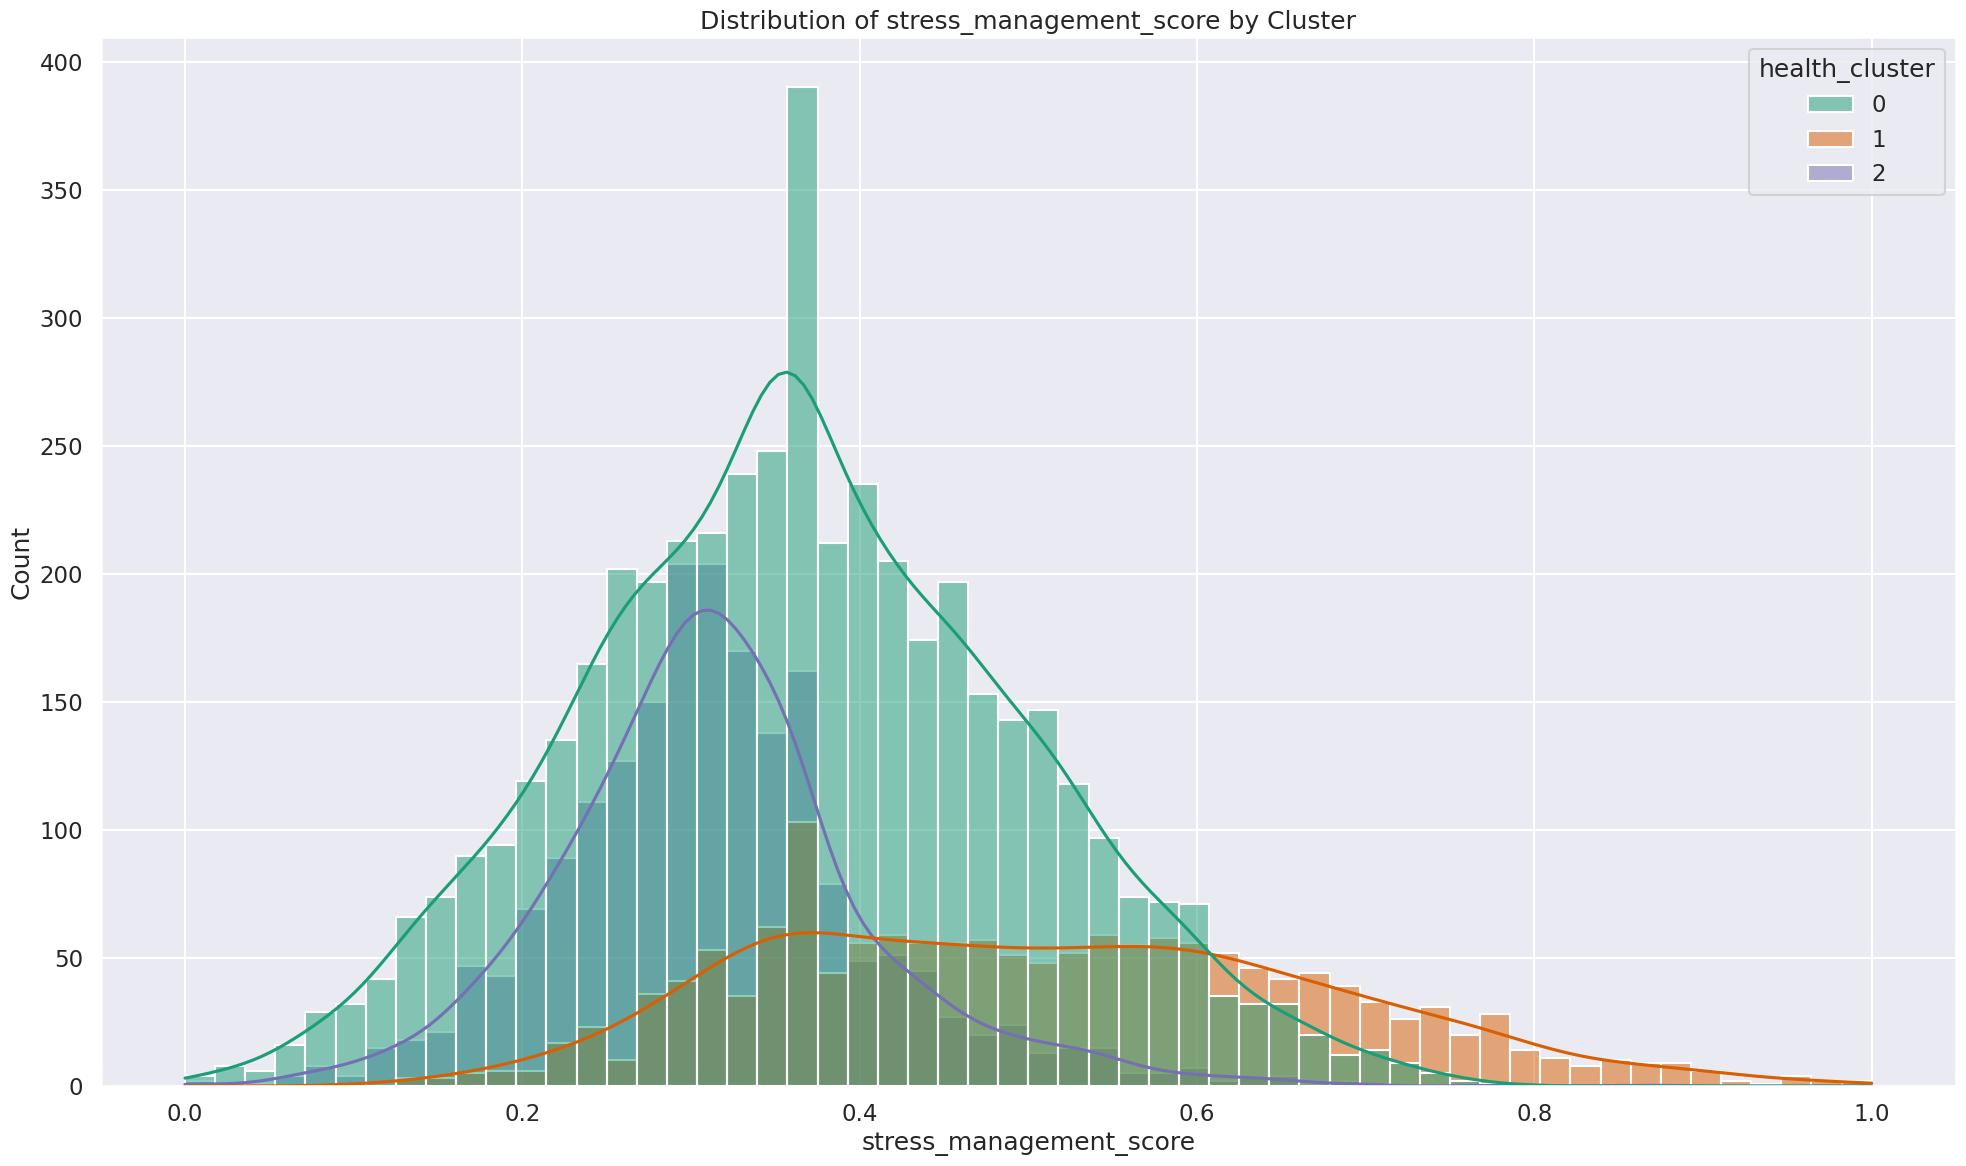

 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

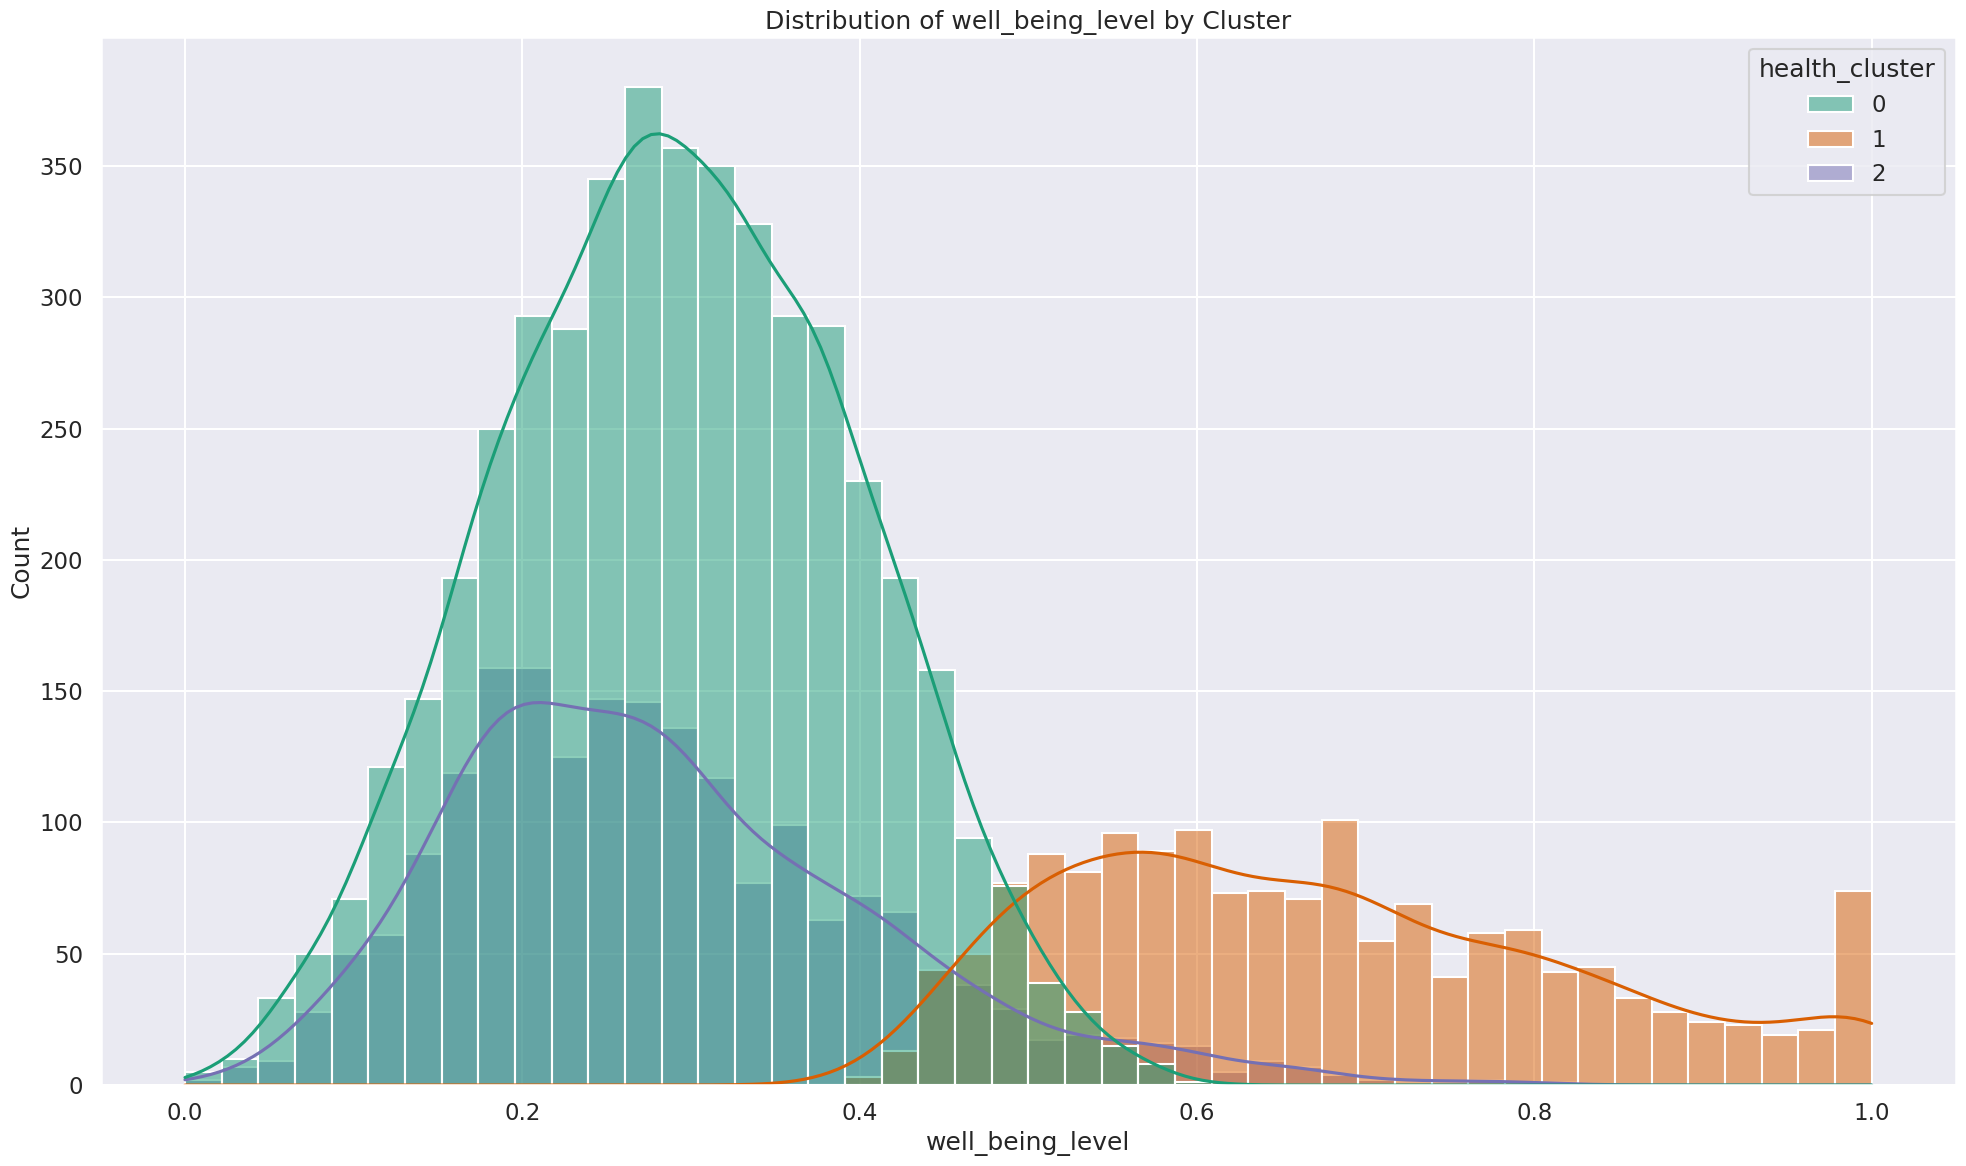

100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


In [183]:
for i in tqdm(health_features):
    plt.figure(figsize=(20, 12))
    sns.histplot(data=data, x=i, hue='health_cluster', kde=True, palette='Dark2', legend=True)
    plt.title(f'Distribution of {i} by Cluster')
    plt.tight_layout()
    plt.show()

From the distribution plots we can spot some trends:

**Environmental & Health Awareness**

  * Cluster 0 and 2 dominate the higher spectrum of both scores.

  * Cluster 1 has a sharp peak at lower awareness values, suggesting limited focus on sustainable and health-conscious habits.

**Exercise & Stress Management**

  * Cluster 2 exhibits the highest exercise frequency.

  * Cluster 0 shows strong stress management and well-being, indicating a healthier emotional state.

  * Cluster 1 lags across the board.

**Entertainment & Digital Influence**

  * Cluster 1 dominates entertainment spending and social media engagement, reinforcing a consumer-oriented, digital-first lifestyle.

  * Cluster 0 and 2 show a more moderate or minimal use of digital/social channels.

These health lifestyle clusters reveal that there are diverse pathways to wellness. Some find balance through active, eco-conscious living (**Cluster 0**). Others express themselves socially at the expense of their health (**Cluster 1**), and some thrive quietly with disciplined habits and low online exposure (C**luster 2**).

## Profile 2- Financial profile

For the financial profile we chose the following columns.

In [184]:
financial_features = ['avg_monthly_entertainment_expenses','investment_portfolio_value_scaled', 'social_media_influence_score_scaled', 'investments_risk_appetite','investments_risk_tolerance_scaled']

In [185]:
scaler = MinMaxScaler()
data[financial_features] = scaler.fit_transform(data[financial_features])

Min-max scaling ensures all values are between 0 and 1.

### Setting k

Now, we are going to train KMeans for `k = 1` to `12` and plot inertia (sum of squared distances to cluster centers).

100%|██████████| 12/12 [00:00<00:00, 39.64it/s]


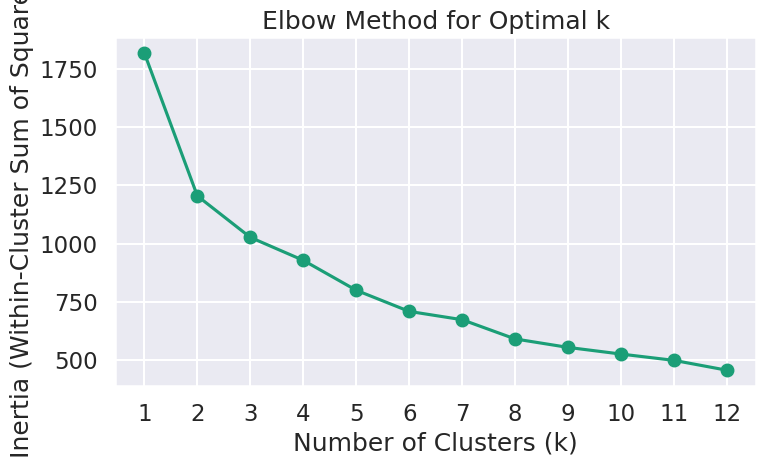

In [186]:
ks = range(1, 13)
inertias = []

for k in tqdm(ks):
    model = KMeans(n_clusters=k, random_state=50)
    model.fit(data[financial_features])
    inertias.append(model.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(ks)
plt.grid(True)
plt.tight_layout()
plt.show()

The "elbow" (point where inertia drop slows down) is at `k = 2`.

We are going to use Ward’s method to build a dendrogram to double-check clustering structure and validate `k` visually (dendrograms reveal natural splits in data).

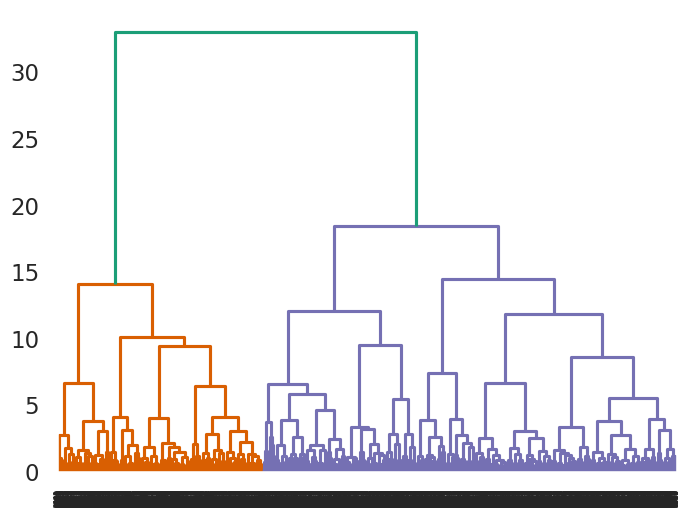

In [187]:
clusters = hierarchy.linkage(data[financial_features], method="ward")

plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

This method also pointed us in the direction of k=2.

To add quantitative validation to the elbow method, we are running a silhouette analysis to measure how well points fit within their clusters. Higher silhouette = cleaner clusters.

100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


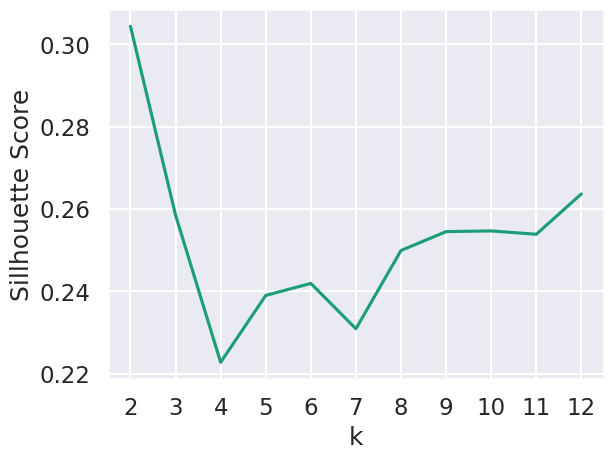

In [188]:
ks = range(2, 13)
sil_score = []

for k in tqdm(ks):
    model = KMeans(n_clusters=k, random_state=50)

    model.fit_predict(data[financial_features])

    sil_score.append(silhouette_score(data[financial_features], model.labels_, metric='euclidean'))


plt.plot(ks, sil_score)

plt.xlabel('k')
plt.ylabel('Sillhouette Score')
plt.xticks(ks)
plt.show()

The silhouette score peaked at `k = 2`, further supporting our choice from the elbow method for optimal k.

In [189]:
k = 2
kmeans_1 = KMeans(n_clusters = k).fit(data[financial_features])
data['financial_cluster'] = kmeans_1.predict(data[financial_features])

Based on the our analysis, we settled on `k = 4` (4 lifestyle clusters).

### Exploring and Visualizing Results

After clustering individuals based on their financial features, this phase is about interpreting what those clusters mean.

We're basically answering the question:
**“What characterizes each lifestyle cluster?”**

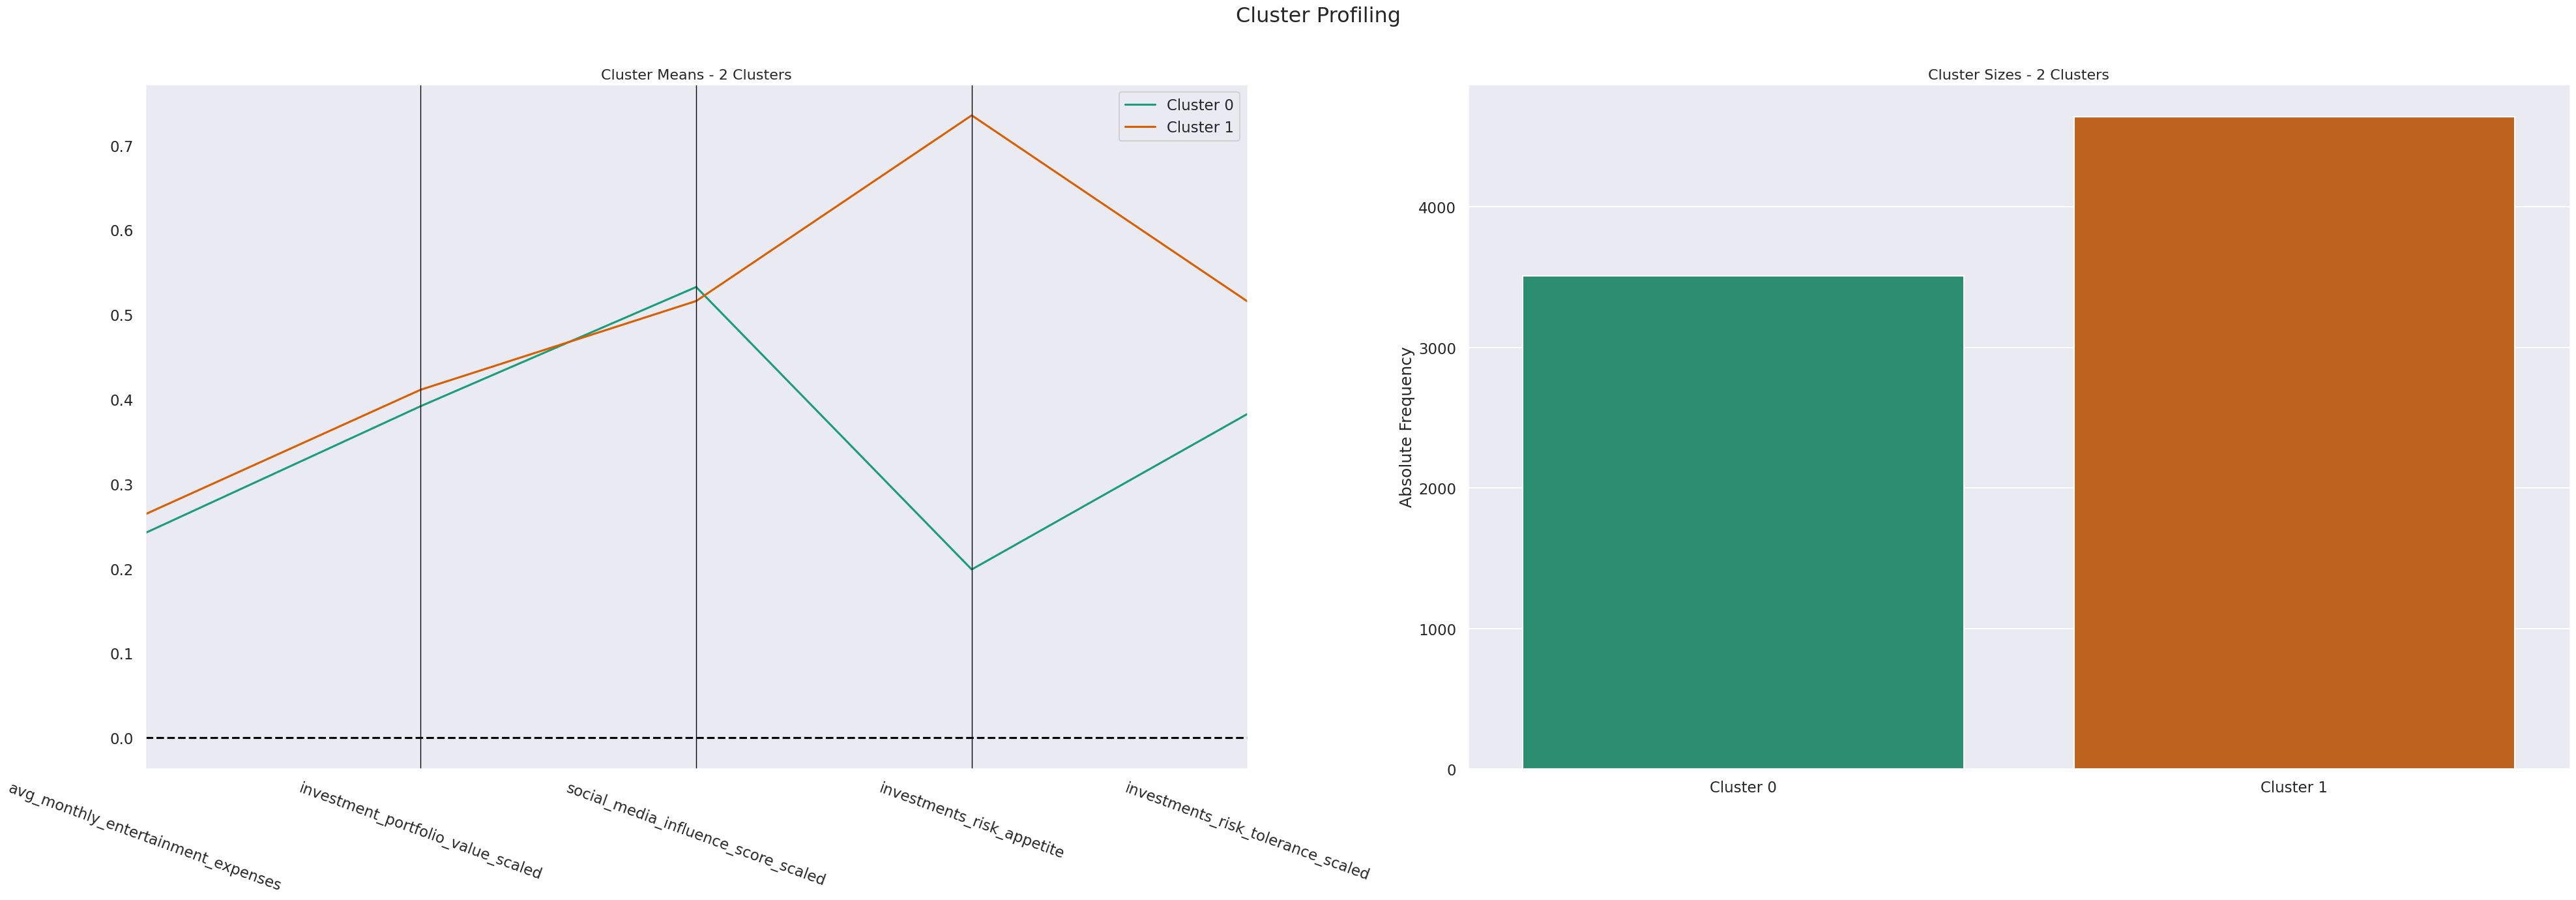

In [190]:
cluster_profiles(data[financial_features].join(data['financial_cluster']),["financial_cluster"],figsize=(48, 15))

**Cluster 0**:

  * High investment risk appetite and tolerance.

  * Higher entertainment spending, portfolio value, and social media influence.

  * Majority cluster in the dataset.

These individuals are comfortable with financial risks, invest more, and likely have stronger financial literacy. They also enjoy spending more on experiences. Financial services could target them for advanced investment products, while also ensuring long-term financial planning advice.

**Cluster 1**:

  * Low in investment risk and tolerance.

  * Lower portfolio value and entertainment spending.

  * Slightly lower on social media influence.

This segment is more cautious, possibly risk-averse due to limited financial literacy or access. Educational initiatives around savings, low-risk investments, and budget-friendly entertainment options could be impactful.

  0%|          | 0/5 [00:00<?, ?it/s]

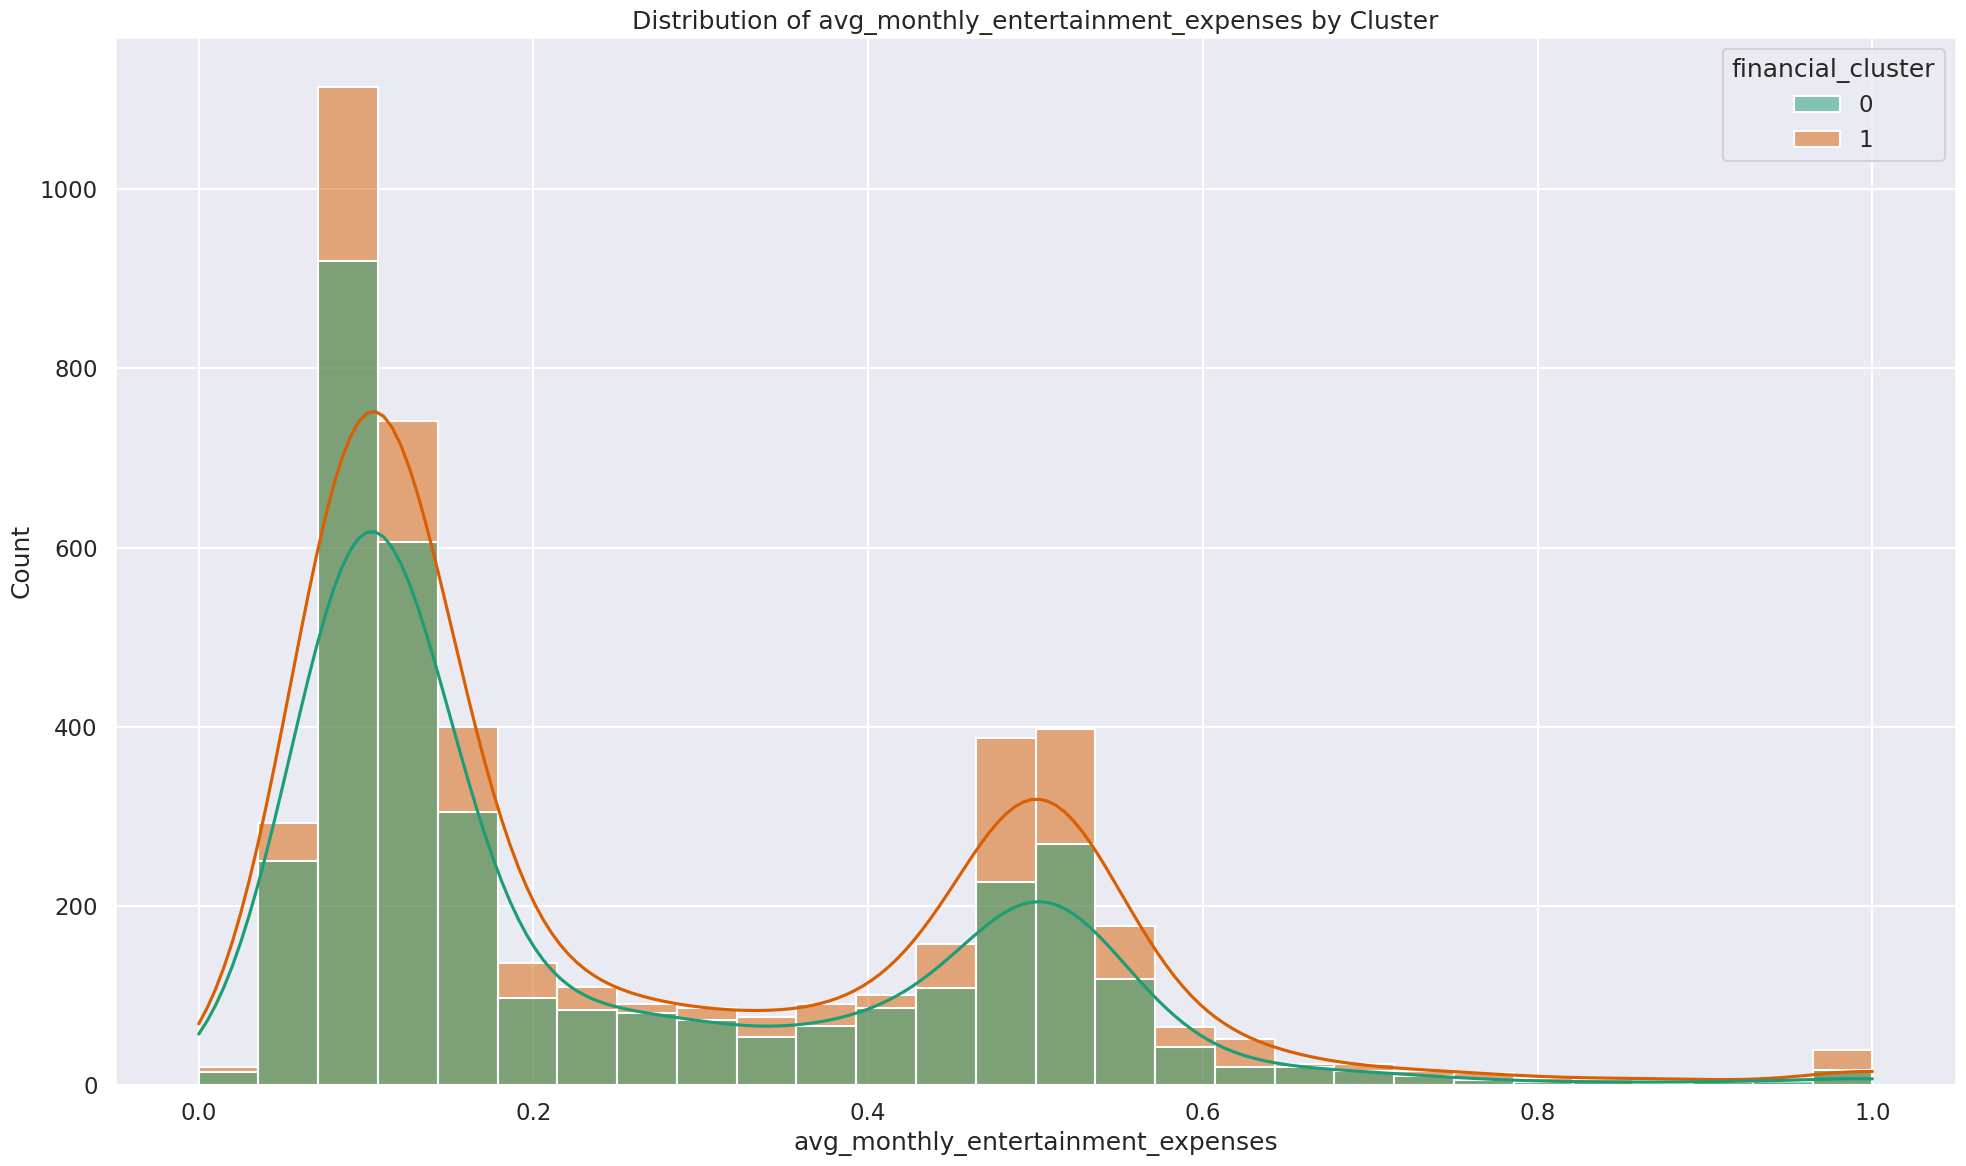

 20%|██        | 1/5 [00:00<00:02,  1.99it/s]

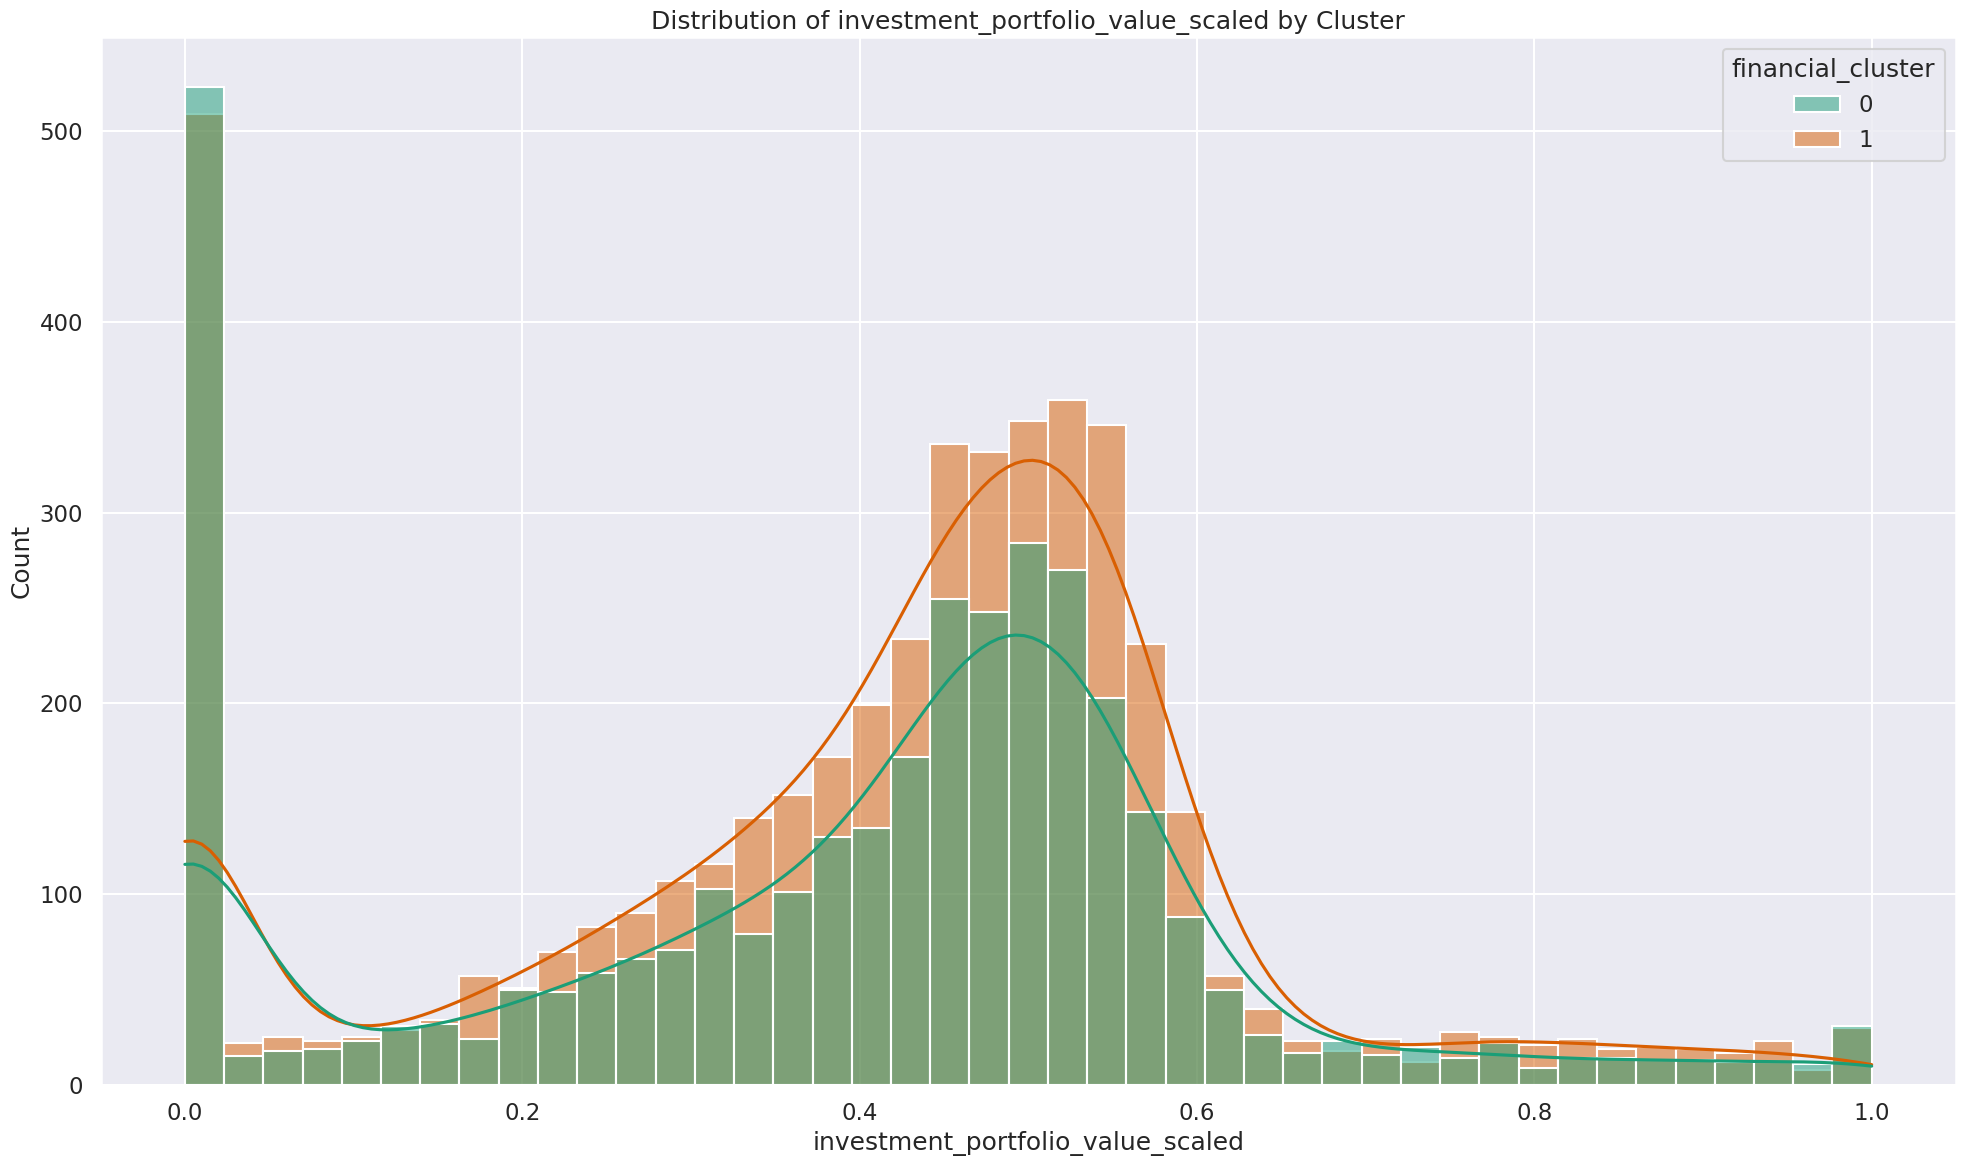

 40%|████      | 2/5 [00:01<00:01,  1.94it/s]

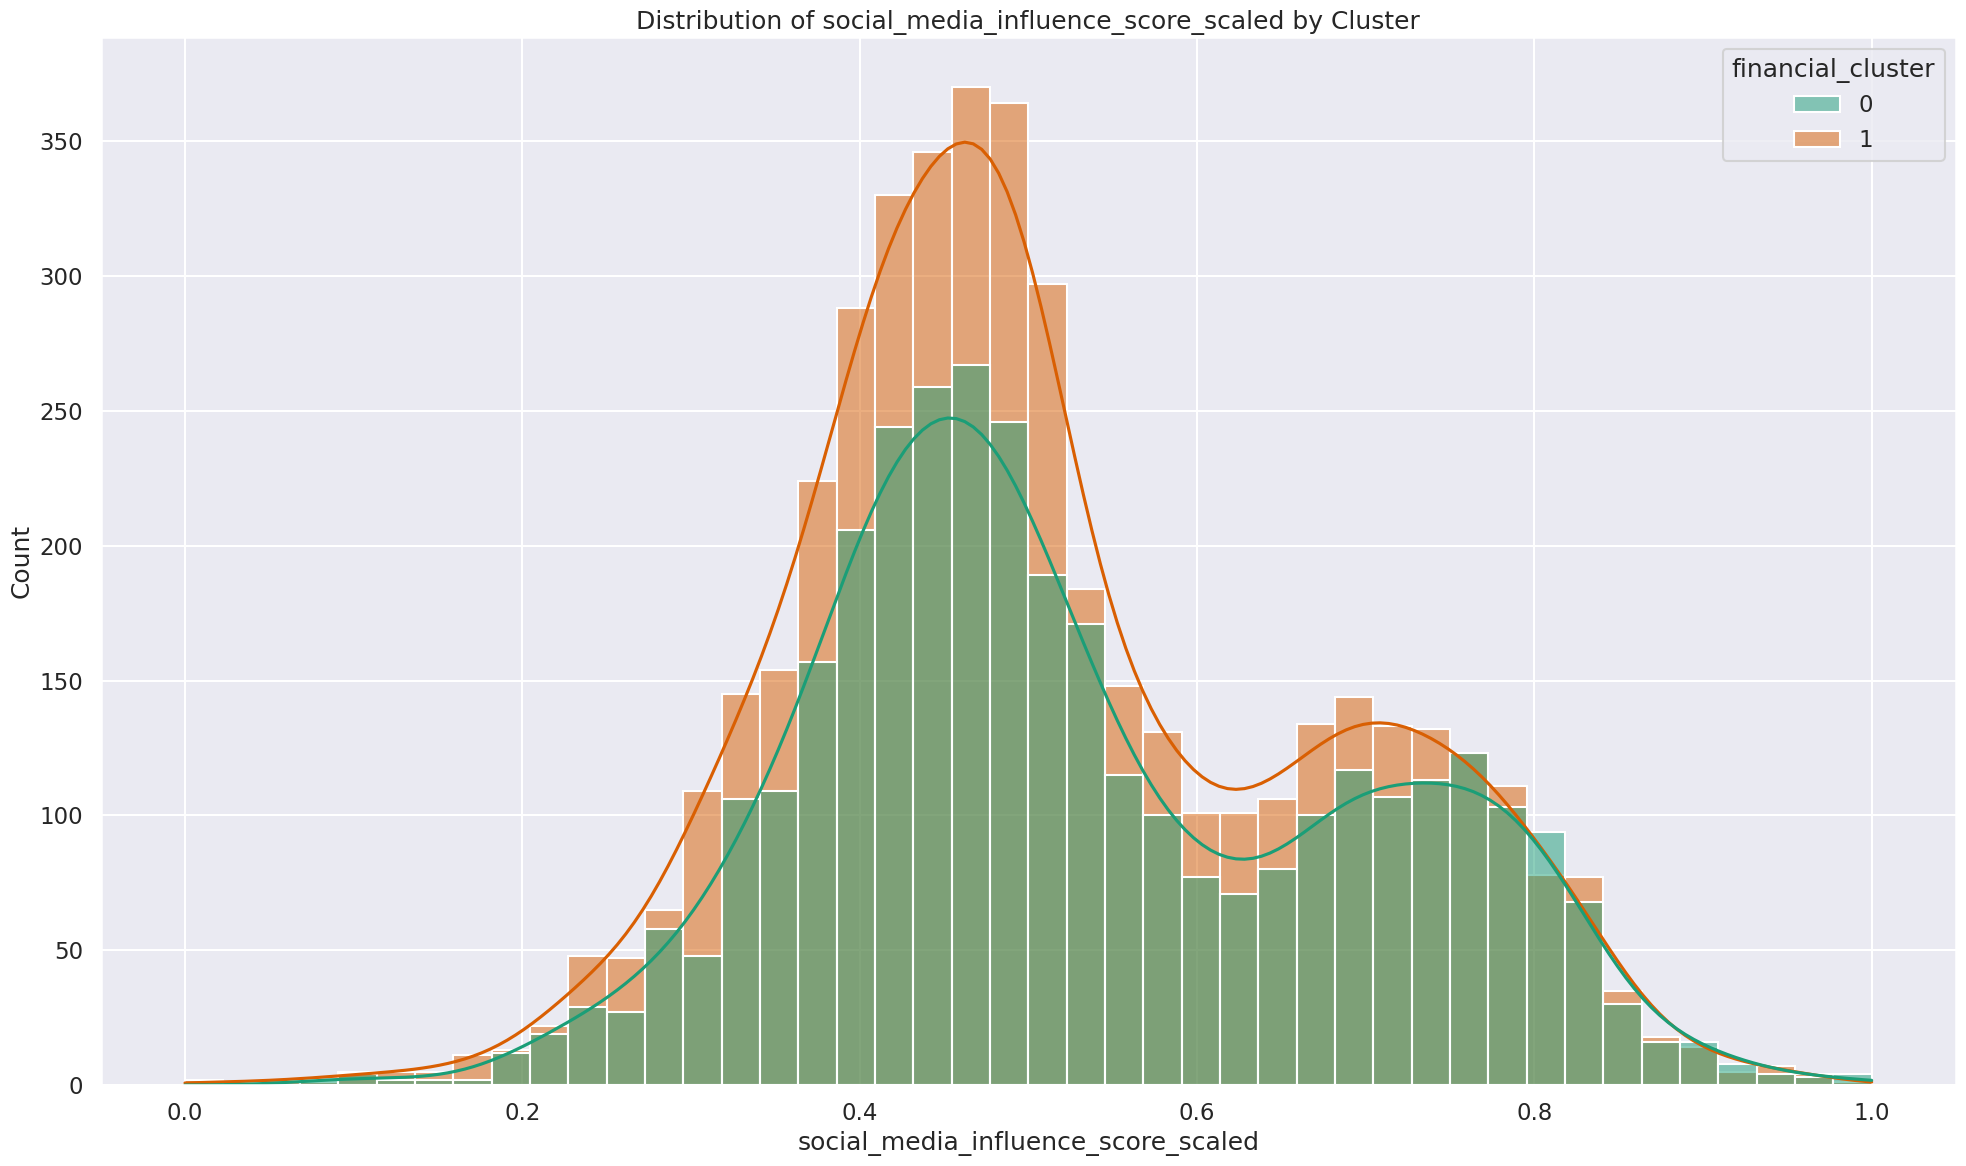

 60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

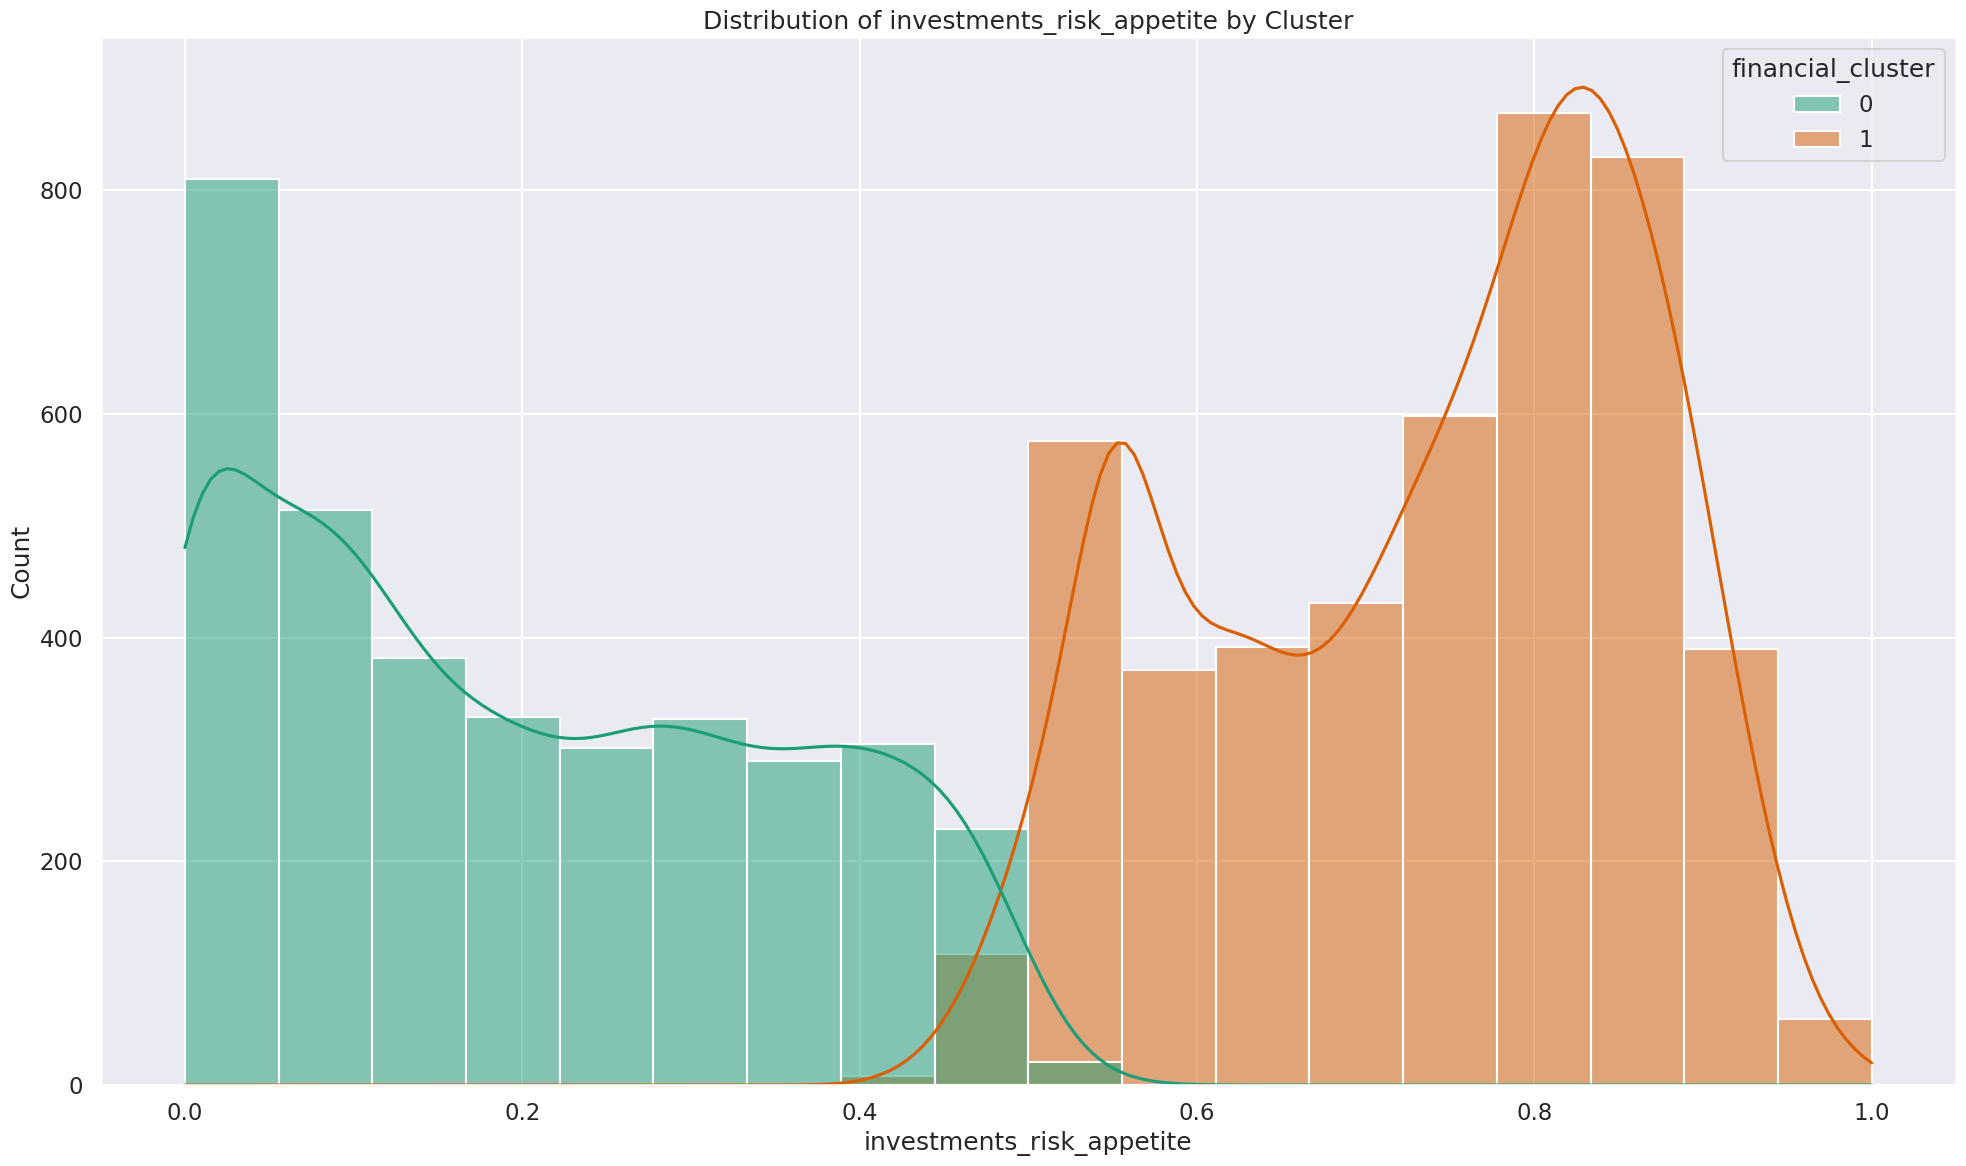

 80%|████████  | 4/5 [00:02<00:00,  1.91it/s]

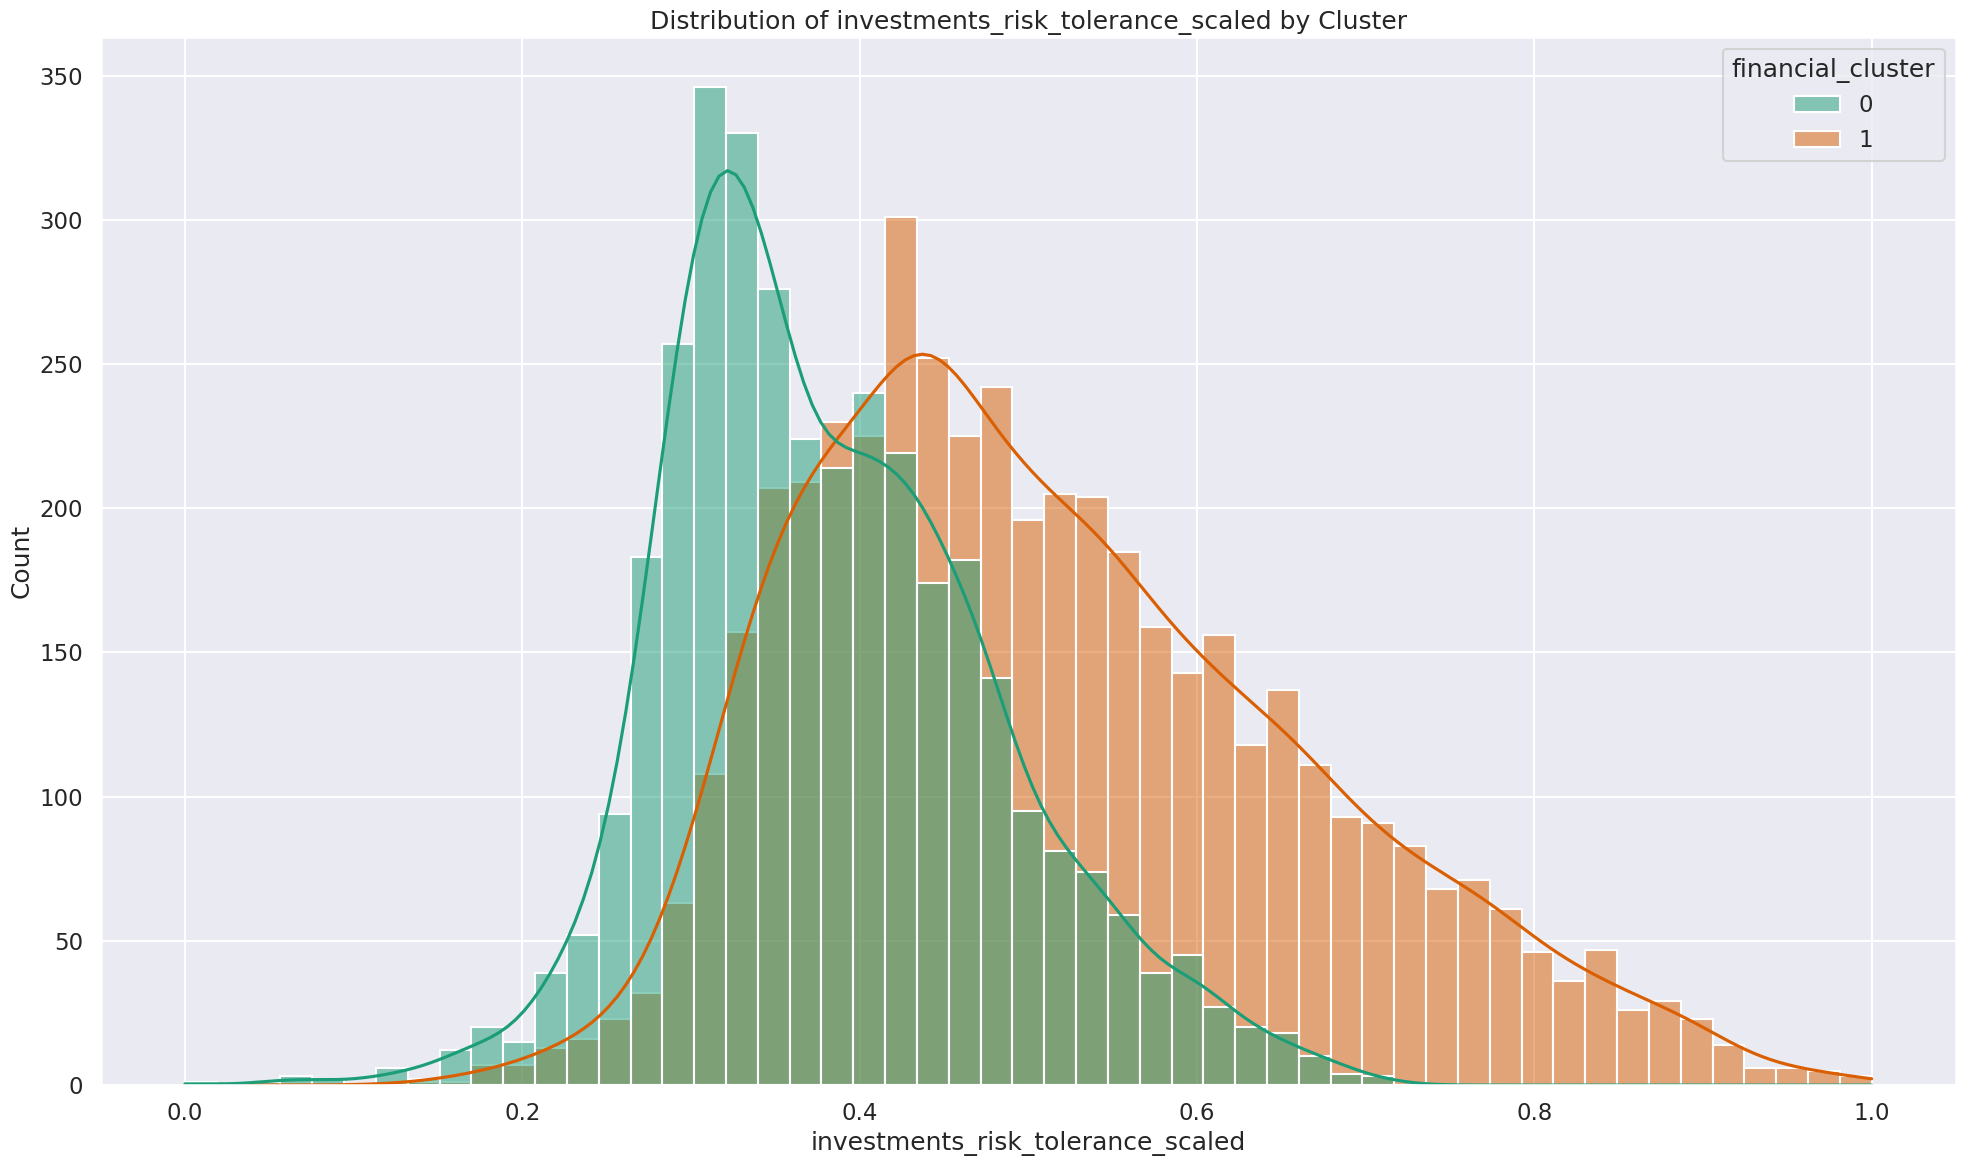

100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


In [191]:
for i in tqdm(financial_features):
    plt.figure(figsize=(20, 12))
    sns.histplot(data=data, x=i, hue='financial_cluster', kde=True, palette='Dark2', legend=True)
    plt.title(f'Distribution of {i} by Cluster')
    plt.tight_layout()
    plt.show()

In these results two main financial personas emerged:

  **Cluster 0** (Green): Higher in investment risk appetite, tolerance, portfolio value, and social media influence.

  **Cluster 1** (Orange): Lower across all those metrics.

**Average Monthly Entertainment Spending**

  * Cluster 0 shows slightly higher variability and spending overall.

  * Cluster 1 concentrates more tightly on the lower end of the distribution.

**Investment Portfolio Value**

  * Cluster 0 dominates the mid-to-upper end of the portfolio value spectrum.

  * Cluster 1 clusters around low values or possibly no investments.

**Social Media Influence Score**

  * Cluster 0 is more polarized — some users score very high.

  * Cluster 1 is more uniformly average or low.

**Investment Risk Appetite**

  Huge contrast between clusters:

  * Cluster 0 skews high — actively willing to take risks.

  * Cluster 1 shows low-to-moderate risk appetite with a steep decline after 0.4.

**Investment Risk Tolerance**

  * Similar trend to risk appetite, but slightly more spread in Cluster 0.

  * Cluster 1 centers tightly around lower tolerance.

In conclusion, individuals belonging to the **Cluster 0** are willing to take bigger financial leaps and are likely more financially literate or supported. On the other hand **Cluster 1** indicates more öower appetite/tolerance for risk. The individuals belonging to this cluster may benefit from more accessible financial education or lower-barrier investment tools.

## Profile 3- Mixed profiles

For the lifestyle profile we chose the following columns which were the best from the previous profiles

In [263]:
lifestyle_features = ['health_consciousness_rating_scaled', 'avg_weekly_exercise_hours_scaled', 'well_being_level', 'social_media_influence_score_scaled']

In [264]:
scaler = MinMaxScaler()
data[lifestyle_features] = scaler.fit_transform(data[lifestyle_features])

Min-max scaling ensures all values are between 0 and 1.

### Setting k

Now, we are going to train KMeans for `k = 1` to `12` and plot inertia (sum of squared distances to cluster centers).

100%|██████████| 12/12 [00:00<00:00, 28.86it/s]


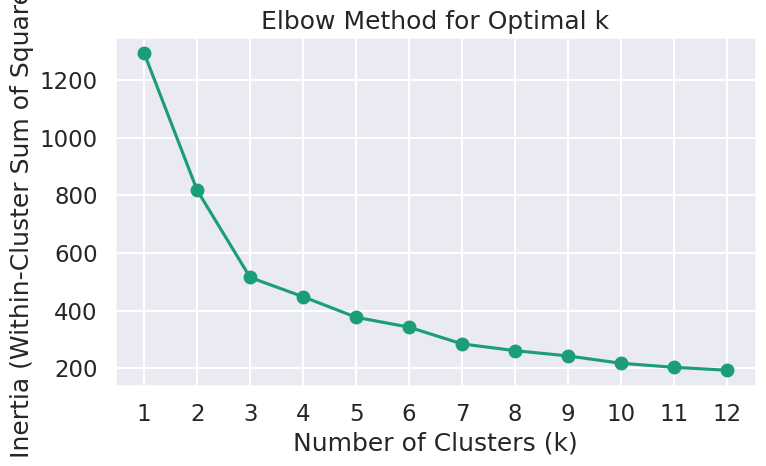

In [265]:
ks = range(1, 13)
inertias = []

for k in tqdm(ks):
    model = KMeans(n_clusters=k, random_state=50)
    model.fit(data[lifestyle_features])
    inertias.append(model.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(ks)
plt.grid(True)
plt.tight_layout()
plt.show()

The "elbow" (point where inertia drop slows down) is at `k = 3`or `k = 4`.

We are going to use Ward’s method to build a dendrogram to double-check clustering structure and validate `k` visually (dendrograms reveal natural splits in data).

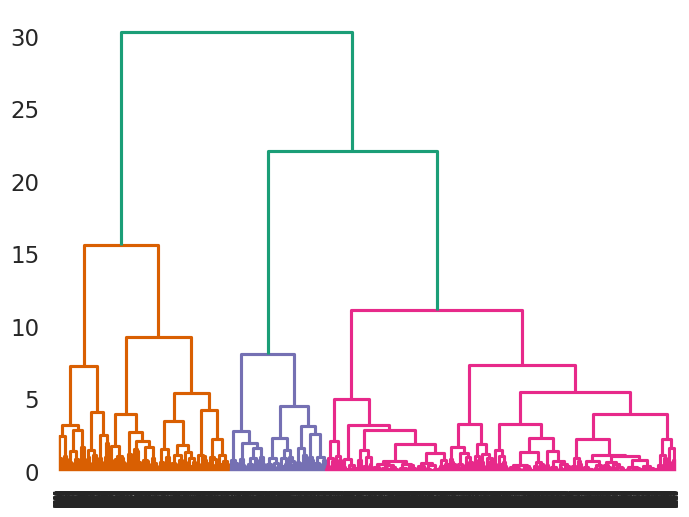

In [266]:
clusters = hierarchy.linkage(data[lifestyle_features], method="ward")

plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

This method also pointed us in the direction of k=3 or k=4

To add quantitative validation to the elbow method, we are running a silhouette analysis to measure how well points fit within their clusters. Higher silhouette = cleaner clusters.

100%|██████████| 11/11 [00:10<00:00,  1.05it/s]


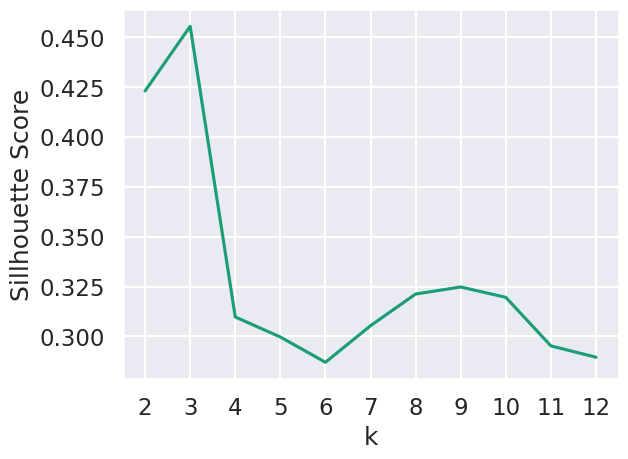

In [267]:
ks = range(2, 13)
sil_score = []

for k in tqdm(ks):
    model = KMeans(n_clusters=k, random_state=50)

    model.fit_predict(data[lifestyle_features])

    sil_score.append(silhouette_score(data[lifestyle_features], model.labels_, metric='euclidean'))


plt.plot(ks, sil_score)

plt.xlabel('k')
plt.ylabel('Sillhouette Score')
plt.xticks(ks)
plt.show()

The silhouette score peaked around  `k = 4`, further supporting our choice from the elbow method for optimal k.

In [268]:
k = 3
kmeans_1 = KMeans(n_clusters = k).fit(data[lifestyle_features])
data['lifestyle_cluster'] = kmeans_1.predict(data[lifestyle_features])

Based on the our analysis, we settled on `k = 4` (4 lifestyle clusters).

### Exploring and Visualizing Results

After clustering individuals based on their lifestyle features, this phase is about interpreting what those clusters mean.

We're basically answering the question:
**“What characterizes each lifestyle cluster?”**

Using the `cluster_profiles()` function, we are going to summarize each cluster's average values across selected features and their relative sizes.

  Two main plots are generated:

  **Parallel Coordinates Plot**:
  
  Shows average values of each feature across clusters. Useful to compare how different lifestyle clusters behave on each metric.

  **Bar Plot of Cluster Sizes**:
  
  Gives a quick view of how many individuals fall into each cluster.

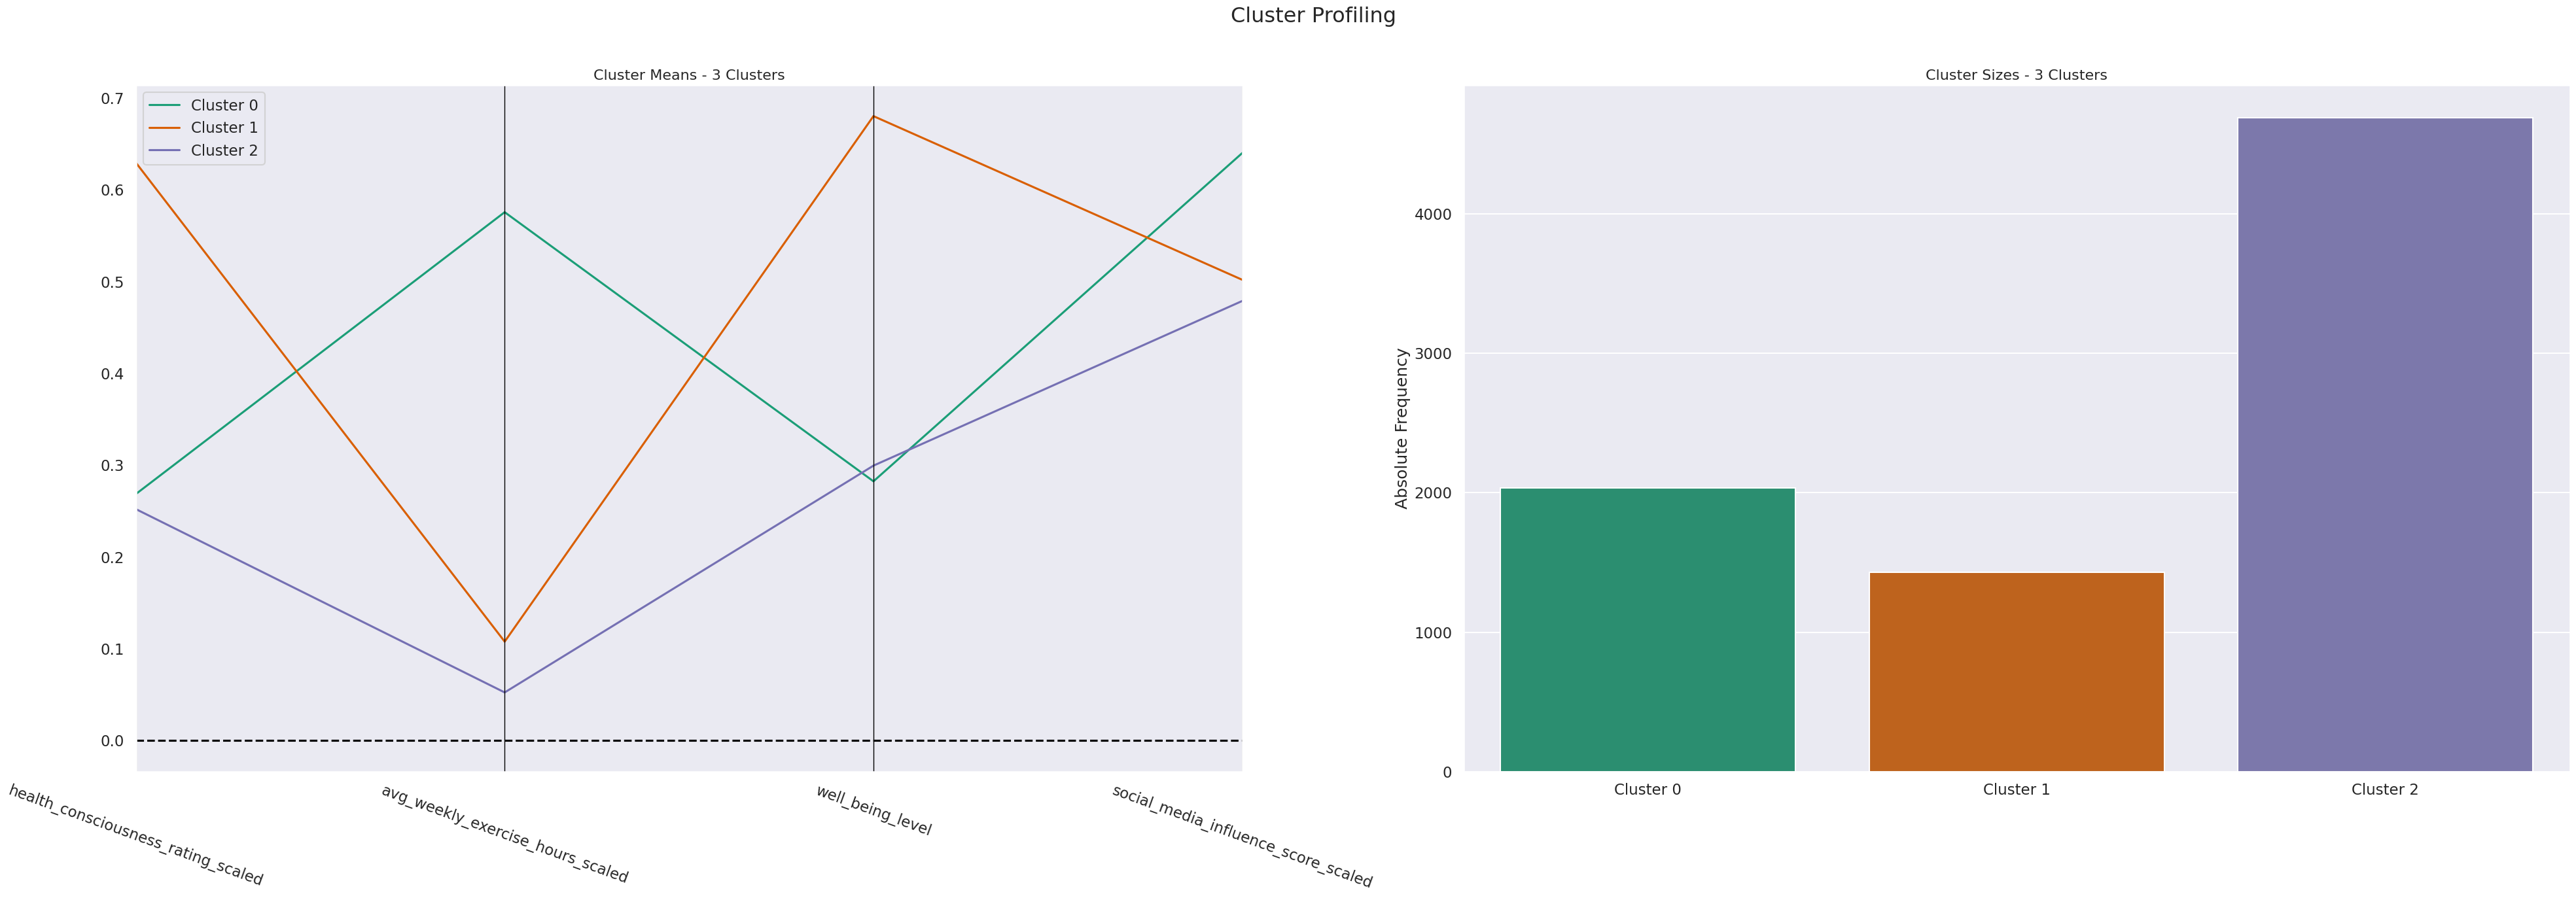

In [269]:
cluster_profiles(data[lifestyle_features].join(data['lifestyle_cluster']),["lifestyle_cluster"],figsize=(48, 15))

  0%|          | 0/4 [00:00<?, ?it/s]

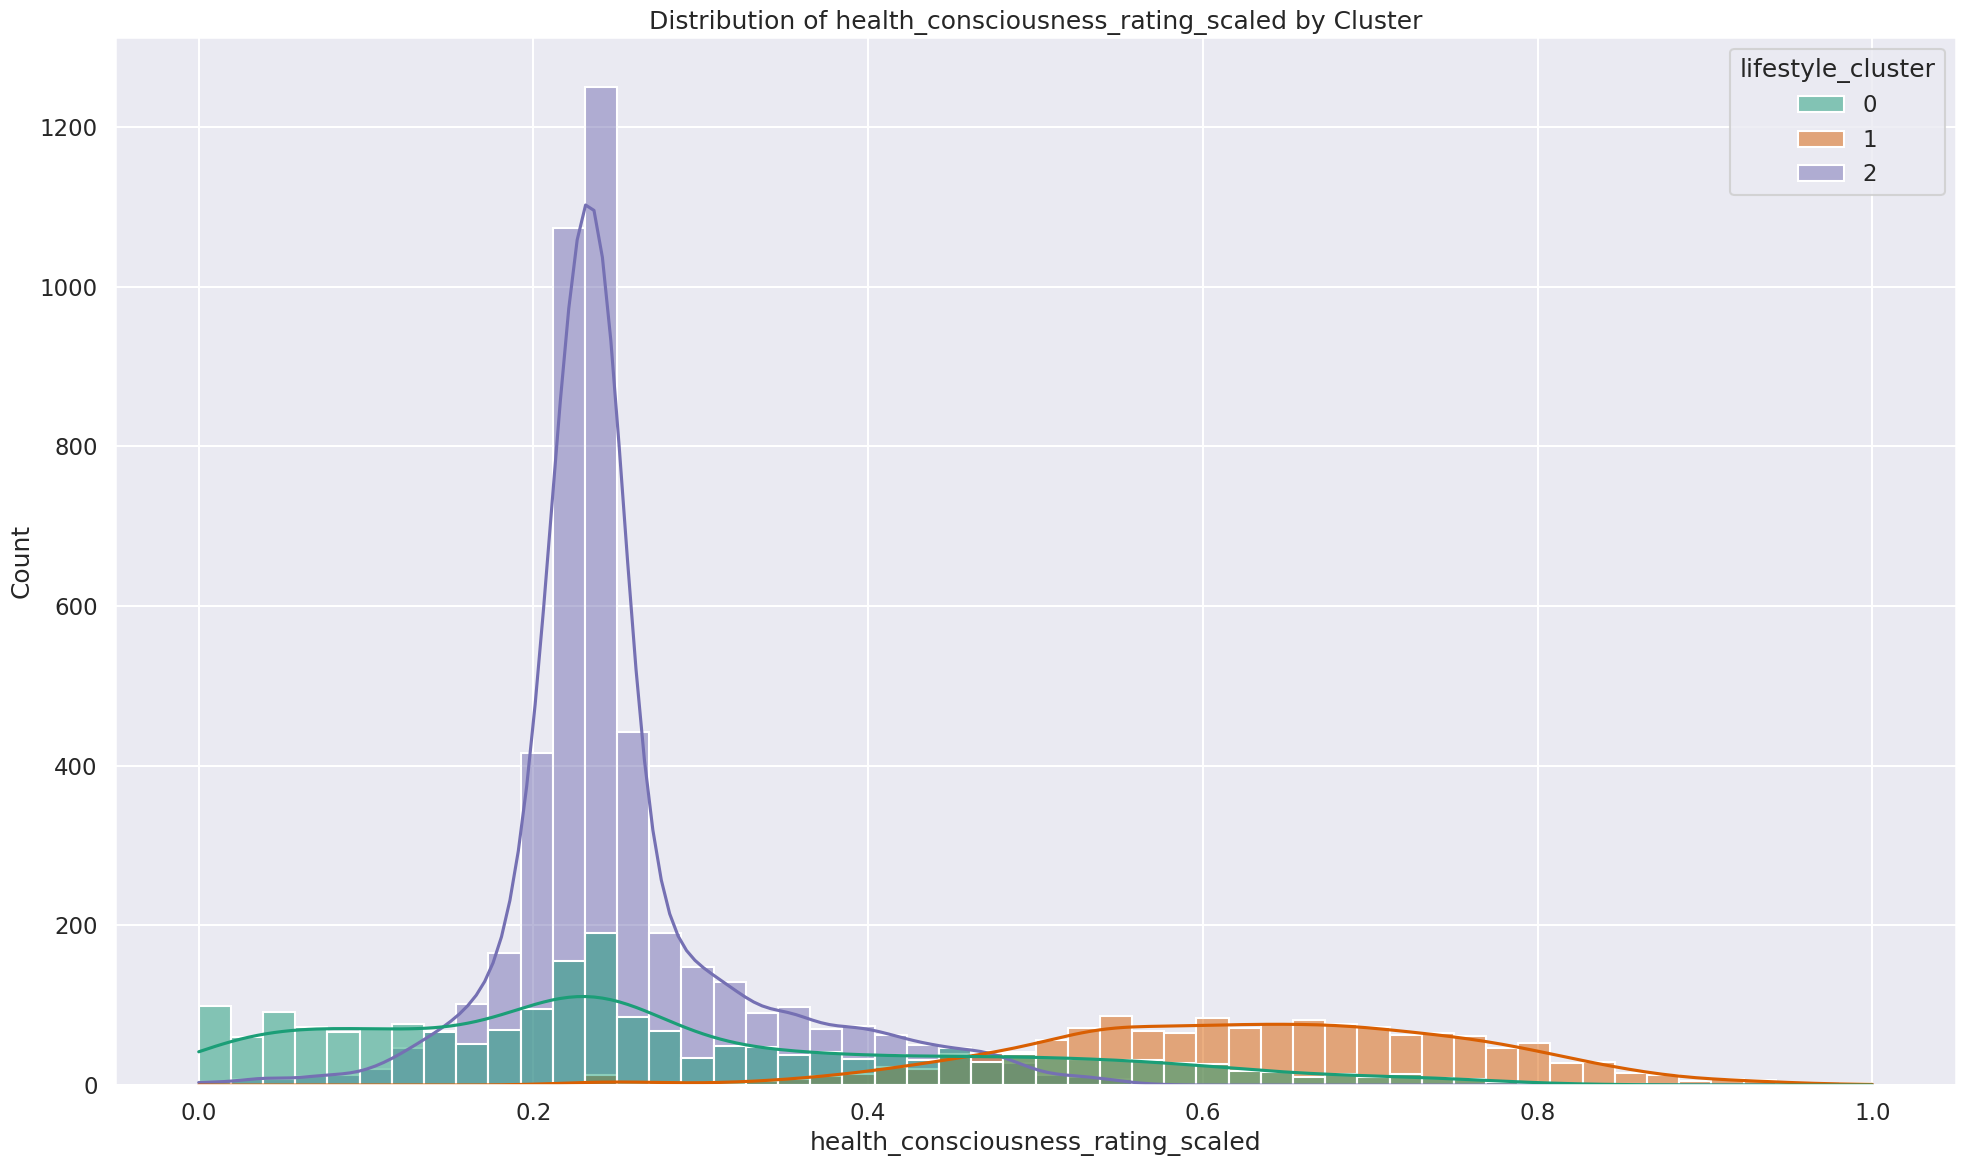

 25%|██▌       | 1/4 [00:01<00:03,  1.09s/it]

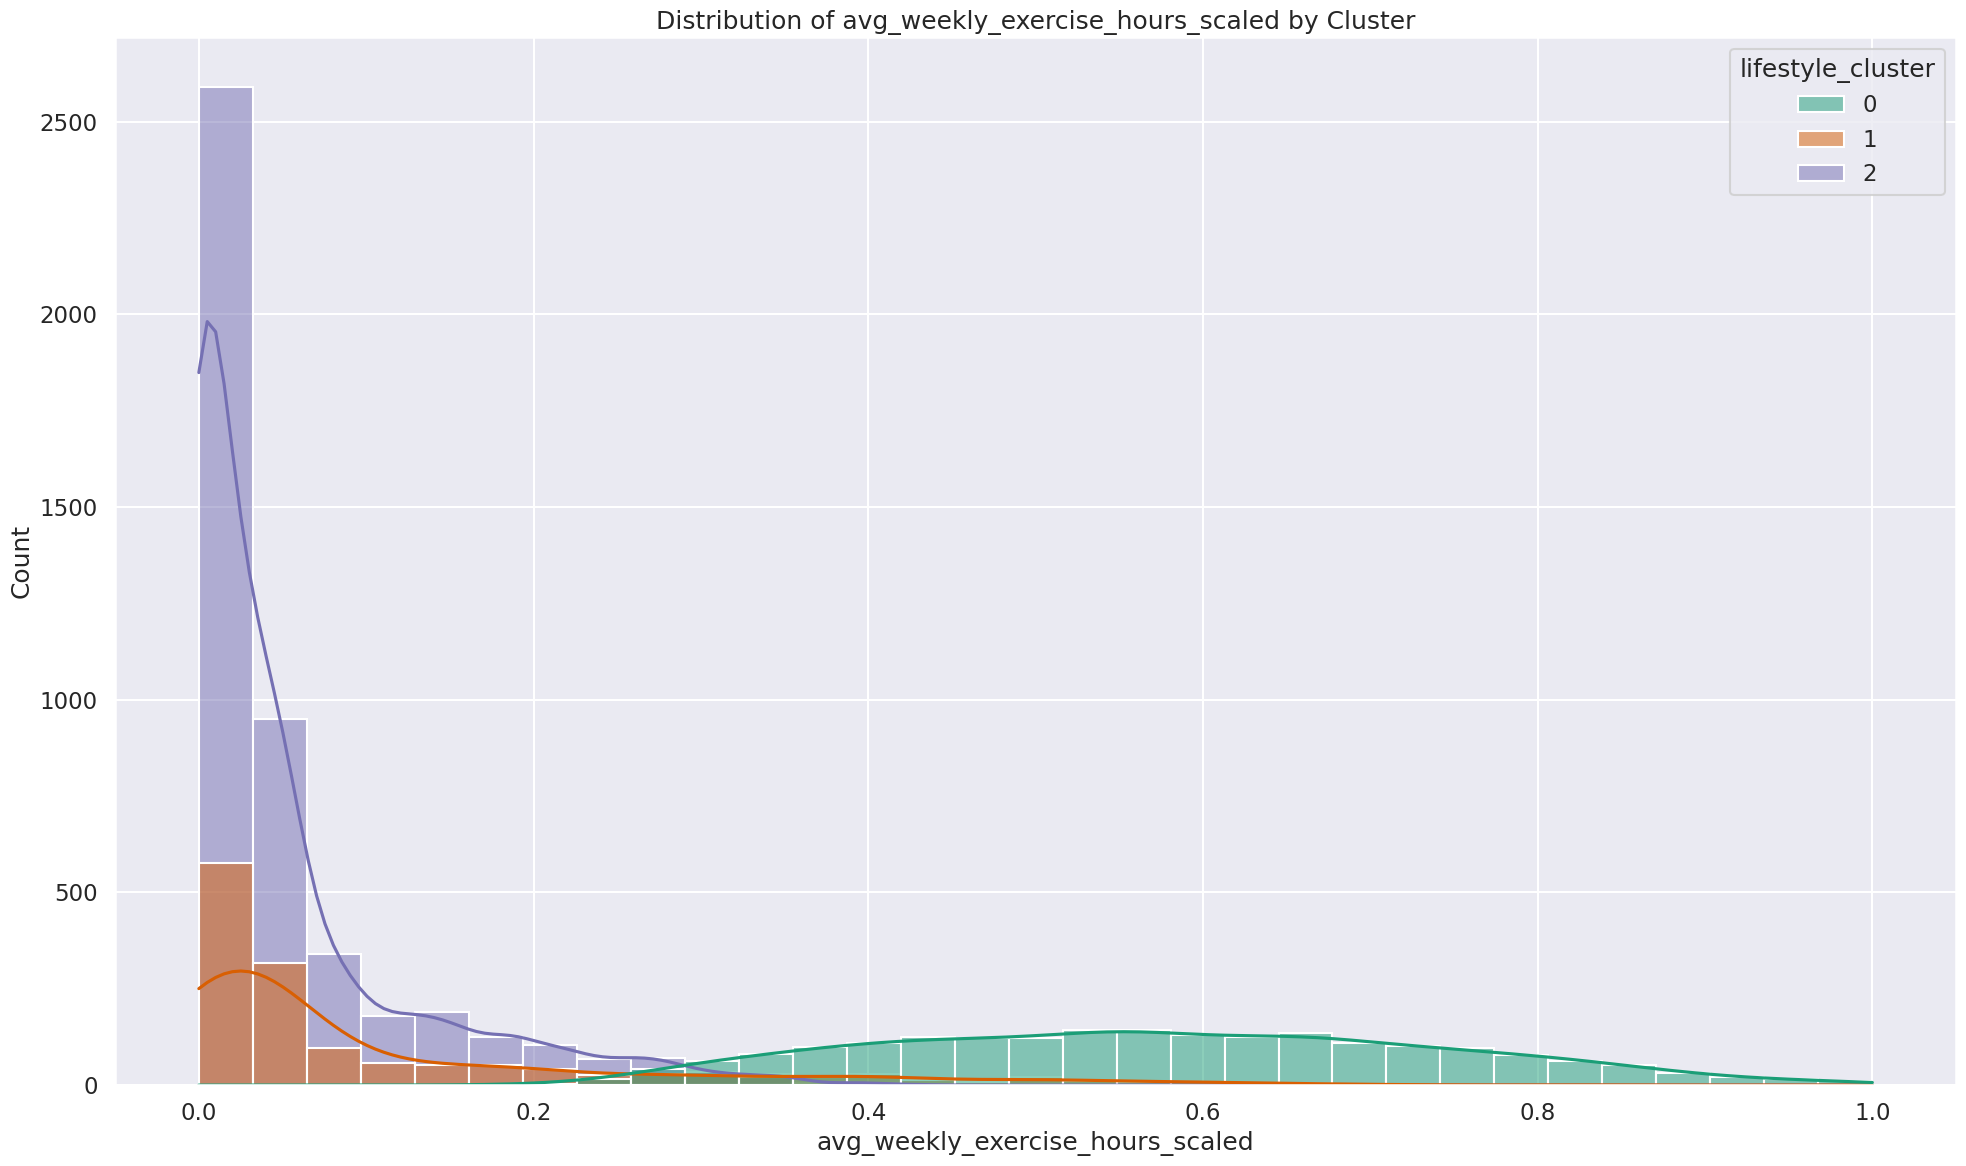

 50%|█████     | 2/4 [00:01<00:01,  1.02it/s]

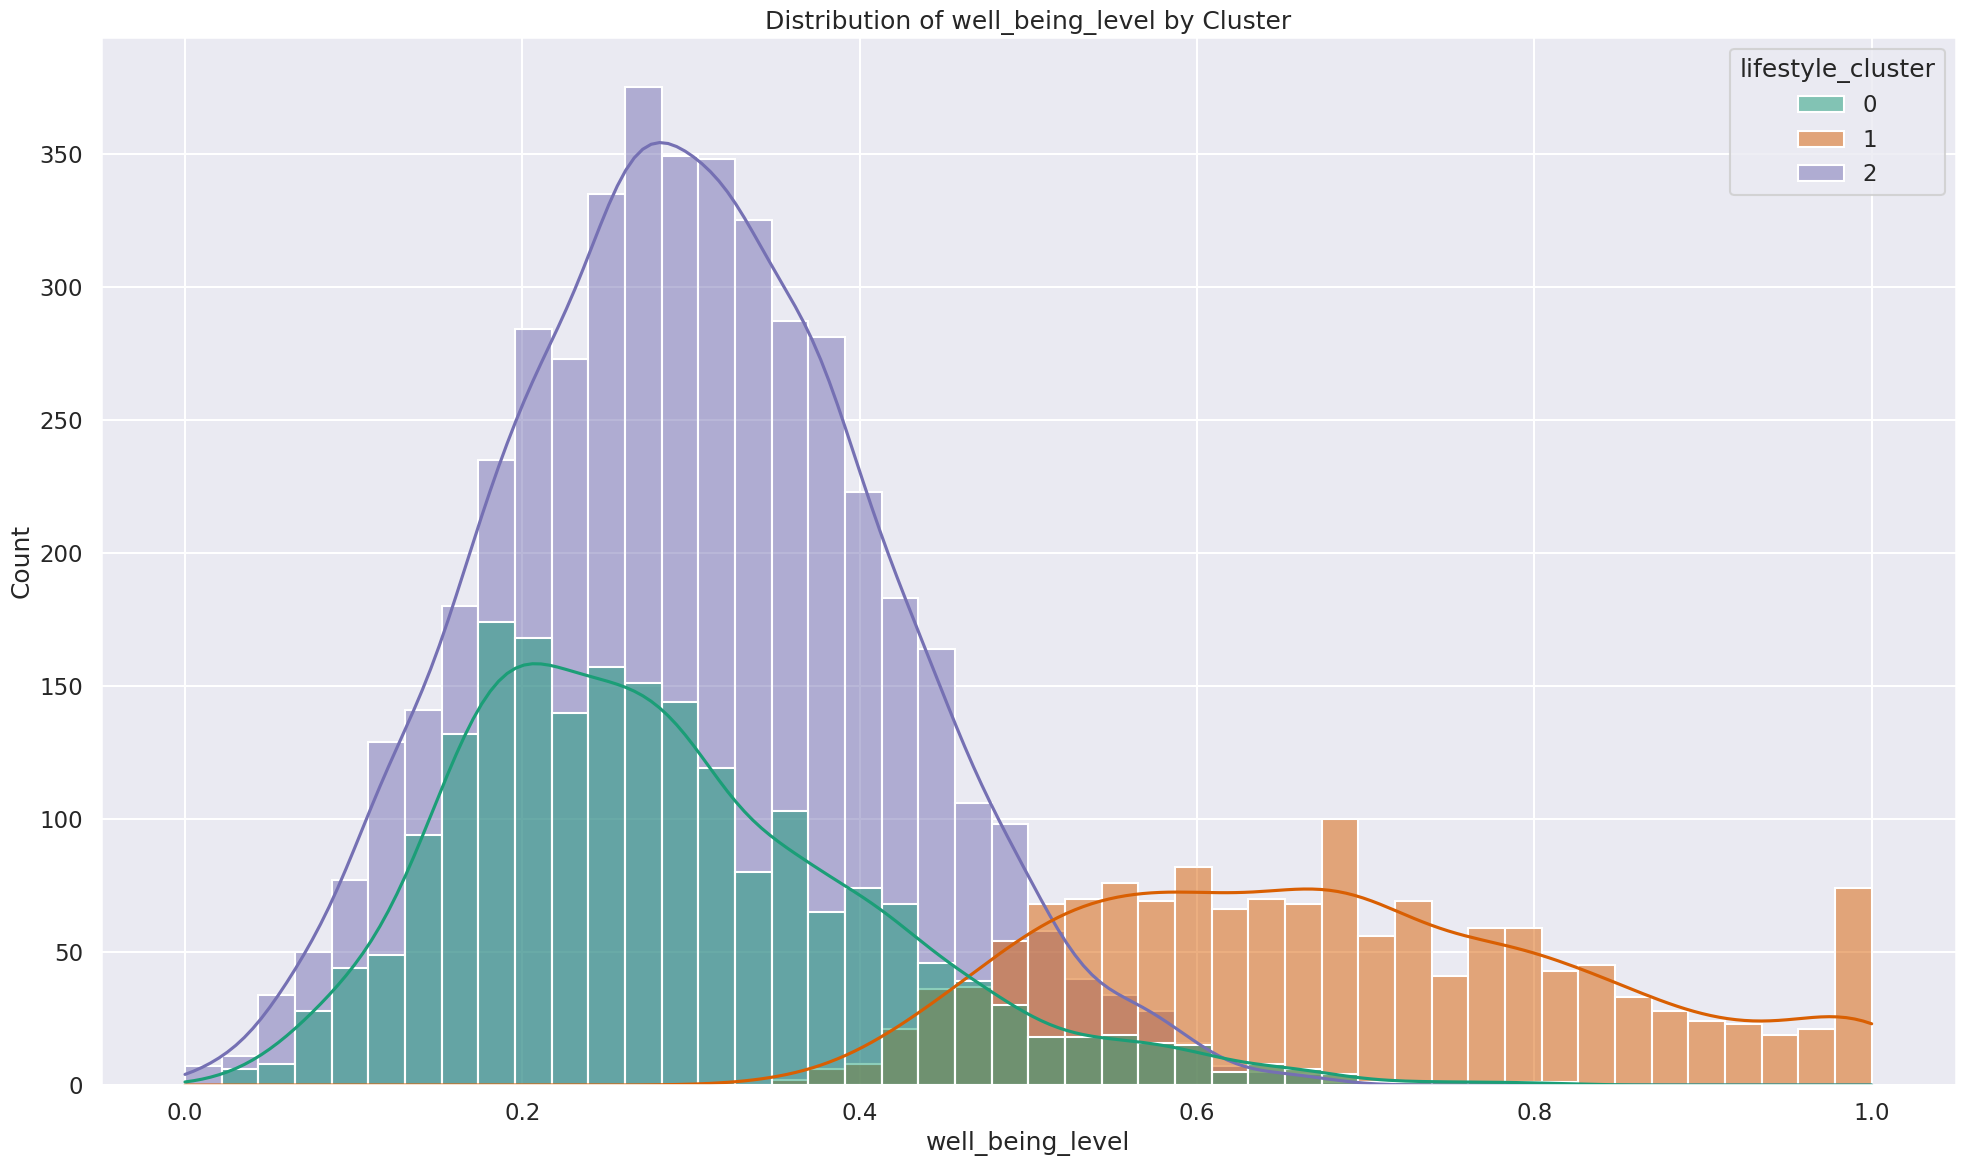

 75%|███████▌  | 3/4 [00:02<00:00,  1.04it/s]

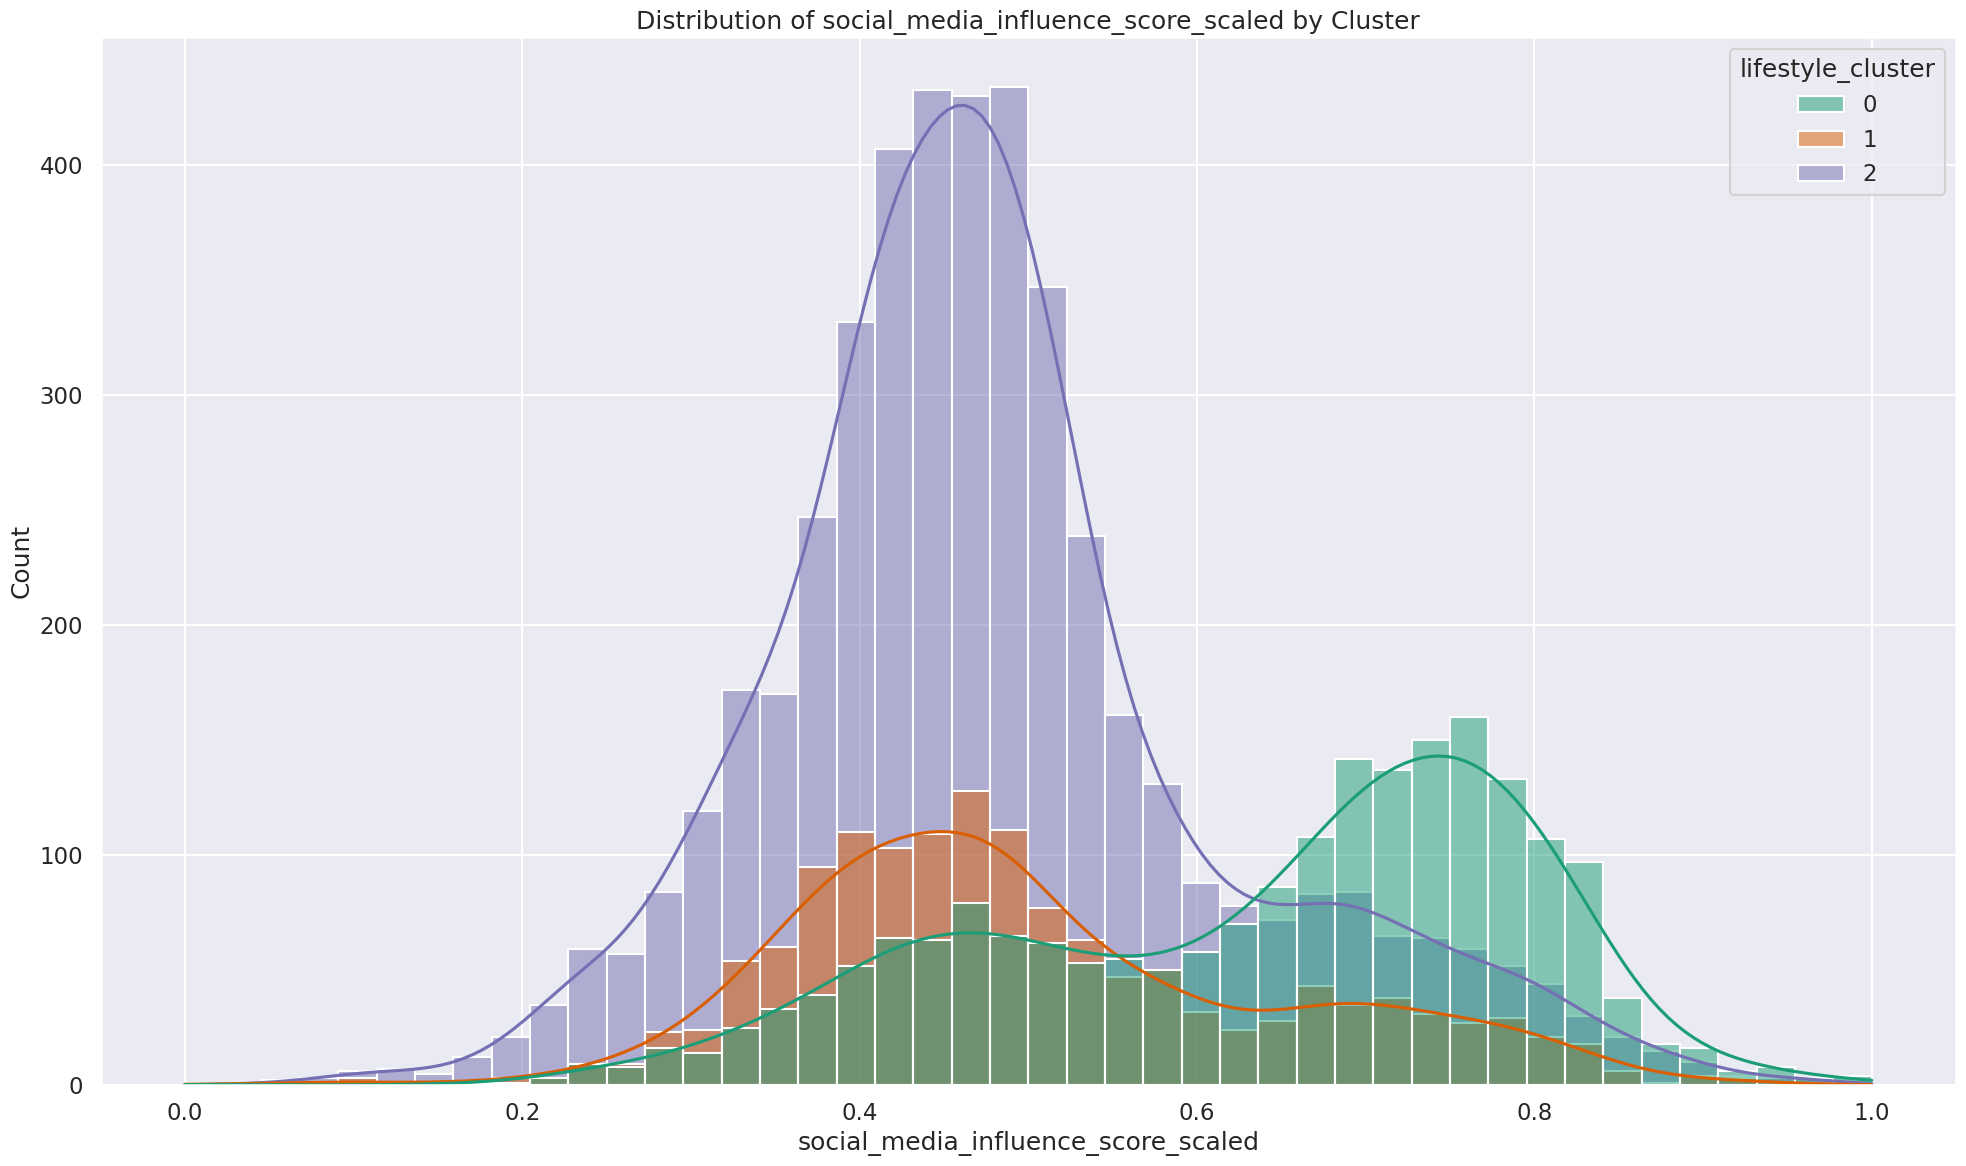

100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


In [270]:
for i in tqdm(lifestyle_features):
    plt.figure(figsize=(20, 12))
    sns.histplot(data=data, x=i, hue='lifestyle_cluster', kde=True, palette='Dark2', legend=True)
    plt.title(f'Distribution of {i} by Cluster')
    plt.tight_layout()
    plt.show()

The results were not what we were expecting and based on them we are now going to reconsider our approach to the descriptive modeling. We are going to look back and reflect if we handled the data well in the preprocessing part, and try new approaches for the clustering like using different cluster profiles based on certain columns and selecting different features to use.